In [1]:
import numpy as np
from astropy.table import Table, Column, join
import subprocess
import wget
import tarfile
import shutil
import os

In [2]:
# function to deredden the flux.

import numpy as np
from uncertainties import ufloat

from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from specutils import extinction


def dered_flux(Av,w,flx):
    ext_lambda= extinction.extinction_ccm89(w * u.angstrom, a_v= Av, r_v= 3.1)
    tau_lambda= ext_lambda/(1*1.086) 
    dered_flx= flx * np.exp(tau_lambda)
    return (dered_flx)

In [3]:
# function to determine the extinction using a smc like extinction model (Pei.1992). Note that For QSOs with z > 1.7 
# a power law reddened using the Small Magellanic Cloud (SMC) must be used. For QSOs at lower redshifts, a fourth or sixth 
# degree polynomial can be used.

def ext_coeff(lamb):
    
    inv_lamba=[0.45,0.61,0.8,1.82,2.27,2.7,3.22,3.34,3.46,3.6,3.75,3.92,4.09,4.28,4.50,4.73,5.00,5.24,5.38,5.52,5.70,5.88,6.07,6.27,6.48,6.72,6.98,7.23,7.52,7.84]
    smc_ext=[-2.61,-2.47,-2.12,0.0,1.0,1.67,2.29,2.65,3.0,3.15,3.49,3.91,4.24,4.53,5.3,5.85,6.38,6.76,6.9,7.17,7.71,8.01,8.49,9.06,9.28,9.84,10.8,11.51,12.52,13.54]
    xy=np.interp(1.0/(lamb*10**(-4)),inv_lamba,smc_ext)
    ext_lamb=(xy+2.98)/3.98 # Rv=2.98
    #return(z,ext_lamb)
    return(ext_lamb)


In [4]:
#Air to vacuum wavelength conversion. 
#The function is used to convert the observed air wavelength in Angstroms in Gemini to the vacuum wavelength
#system of SDSS and BOSS

def air_to_vac(wavl):
    n_air = 1.000277
    s=(10**8)/n_air**2
    n=1.0+0.000064328+0.0294981/(146.0-s)+0.0002554/(41.0-s)
    z=float(wavl*n)
    return (z)



In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = np.asarray(y[0]) - np.abs( y[1:half_window+1][::-1] - np.asarray(y[0]) )
    lastvals = np.asarray(y[-1]) + np.abs(y[-half_window-1:-1][::-1] - np.asarray(y[-1]))
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [6]:
from scipy.integrate import simps
from numpy import trapz

def civ_param(z,wavl,smoothed_signal):
    c_light=299792.0 # speed of light in km/s
    cw=1549.0 # central wavlength for CIV emission line
    velocity=c_light*(np.asarray(wavl)**2-cw**2)/((np.asarray(wavl)**2+cw**2))

    vel=[]
    signal=[]
    wavle=[]
    #f=open('test.txt','w')
    i=1
    while i < len(wavl):
        if -30000 < velocity[i] < -3000 and smoothed_signal[i] <= 0.9:
                signal.append(smoothed_signal[i])
                vel.append(velocity[i])
                wavle.append(wavl[i])
                
                #f.write(str(wavl[i])+'\t'+str(velocity[i])+'\t'+str(smoothed_signal[i])+'\t'+'\n')
        i=i+1
#     f.close()
#     f1=open('test1.txt','w')
    i=1
    vel_diff=[]
    while i < len(vel):
        vel_diff.append(float(vel[i]-vel[i-1]))
#         f1.write(str(float(vel[i]-vel[i-1]))+'\n')
        i=i+1
#     f1.close()

    pos=[]
    lw_wavl=[]
    uw_wavl=[]
    for i in range(len(vel_diff)):
        if float(vel_diff[i]) >= 195 :
            pos.append(i)

    if len(pos) > 1:
        for i in range(len(pos)):
            lw_wavl.append(wavle[pos[i]])
            uw_wavl.append(wavle[pos[i]]+1)
        diff=[]
        i=1
        while i < len(pos):
            diff.append(pos[i]-pos[i-1])
            i=i+1
        for i in range(len(diff)):
            if diff[i] == max(diff):
                maxi=i

        wavle[pos[maxi]+1] # lower wavelength
        wavle[pos[maxi+1]] # upper wavelength

        r_signal=[]
        r_wavl=[]
        r_vel=[]
        for i in range(len(wavle)):
            if  wavle[pos[maxi]+1] <= wavle[i] <= wavle[pos[maxi+1]]:
                r_signal.append(signal[i])
                r_wavl.append(wavle[i])
                r_vel.append(vel[i])

    elif len(pos) == 1:
        r_signal=[]
        r_wavl=[]
        r_vel=[]
        for i in range(len(wavle)):
            if  wavle[i] <= wavle[pos[0]]:
                r_signal.append(signal[i])
                r_wavl.append(wavle[i])
                r_vel.append(vel[i])

    elif len(pos) == 0:
        r_signal=signal
        r_wavl=wavle
        r_vel=vel

    else:
        print ("Check!")

    if r_wavl==[]:
        bal_ind=[0]
        ew=[0]
        r_vel=[0]
        r_wavl=[0]

    elif float(max(r_vel)-min(r_vel)) < 2000:
        bal_ind=[0]
        ew=[0]
        r_vel=[0]
        r_wavl=[0]

    else:
                #ew=integrate.cumtrapz(np.subtract(1,r_signal), r_wavl)
    #         func1=np.subtract(1,np.divide(r_signal,0.9))
    #         bal_ind=trapz(np.array(func1), dx=194)
        x=0
        for i in range(len(r_vel)):
            if i < len(r_vel)-1:
                x=x+0.5*(np.subtract(1,np.divide(r_signal[i],0.9))+np.subtract(1,np.divide(r_signal[i+1],0.9)))*(r_vel[i+1]-r_vel[i])
        bal_ind=x

        #bal_ind=integrate.cumtrapz(np.subtract(1,np.divide(r_signal,0.9)), r_vel)
        x=0
        for i in range(len(r_wavl)):
            if i < len(r_wavl)-1:
                x=x+0.5*(np.subtract(1,r_signal[i])+np.subtract(1,r_signal[i+1]))*(r_wavl[i+1]-r_wavl[i])
        ew=x
            
    return (bal_ind,ew,max(r_vel),min(r_vel),min(r_wavl),max(r_wavl))

In [6]:
# for estimation of error in ew--using this!
from scipy.integrate import simps
from numpy import trapz

def civ_param(z,wavl,smoothed_signal,contflux,flux,err):
    c_light=299792.0 # speed of light in km/s
    cw=1549.0 # central wavlength for CIV emission line
    velocity=c_light*(np.asarray(wavl)**2-cw**2)/((np.asarray(wavl)**2+cw**2))

    vel=[]
    signal=[]
    wavle=[]
    orig_flux=[]
    cont_flux=[]
    error=[]
    #f=open('test.txt','w')
    i=1
    while i < len(wavl):
        if -30000 < velocity[i] < -3000 and smoothed_signal[i] <= 0.9:
                signal.append(smoothed_signal[i])
                vel.append(velocity[i])
                wavle.append(wavl[i])
                cont_flux.append(contflux[i])
                orig_flux.append(flux[i])
                error.append(err[i])
                
                #f.write(str(wavl[i])+'\t'+str(velocity[i])+'\t'+str(smoothed_signal[i])+'\t'+'\n')
        i=i+1
#     f.close()
#     f1=open('test1.txt','w')
    i=1
    vel_diff=[]
    while i < len(vel):
        vel_diff.append(float(vel[i]-vel[i-1]))
#         f1.write(str(float(vel[i]-vel[i-1]))+'\n')
        i=i+1
#     f1.close()

    pos=[]
    lw_wavl=[]
    uw_wavl=[]
    for i in range(len(vel_diff)):
        if float(vel_diff[i]) >= 195 :
            pos.append(i)

    if len(pos) > 1:
        for i in range(len(pos)):
            lw_wavl.append(wavle[pos[i]])
            uw_wavl.append(wavle[pos[i]]+1)
        diff=[]
        i=1
        while i < len(pos):
            diff.append(pos[i]-pos[i-1])
            i=i+1
        for i in range(len(diff)):
            if diff[i] == max(diff):
                maxi=i

        wavle[pos[maxi]+1] # lower wavelength
        wavle[pos[maxi+1]] # upper wavelength

        r_signal=[]
        r_wavl=[]
        r_vel=[]
        r_contflux=[]
        r_flux=[]
        r_err=[]
        for i in range(len(wavle)):
            if  wavle[pos[maxi]+1] <= wavle[i] <= wavle[pos[maxi+1]]:
                r_signal.append(signal[i])
                r_wavl.append(wavle[i])
                r_vel.append(vel[i])
                r_contflux.append(cont_flux[i])
                r_flux.append(orig_flux[i])
                r_err.append(error[i])

    elif len(pos) == 1:
        r_signal=[]
        r_wavl=[]
        r_vel=[]
        r_contflux=[]
        r_flux=[]
        r_err=[]
        for i in range(len(wavle)):
            if  wavle[i] <= wavle[pos[0]]:
                r_signal.append(signal[i])
                r_wavl.append(wavle[i])
                r_vel.append(vel[i])
                r_contflux.append(cont_flux[i])
                r_flux.append(orig_flux[i])
                r_err.append(error[i])
    elif len(pos) == 0:
        r_signal=signal
        r_wavl=wavle
        r_vel=vel
        r_contflux=cont_flux
        r_flux=orig_flux
        r_err=error
    else:
        print ("Check!")

    if r_wavl==[]:
        bal_ind=[0]
        ew=[0]
        sigmaew=[0]
        r_vel=[0]
        r_wavl=[0]

        
    elif float(max(r_vel)-min(r_vel)) < 2000:
        bal_ind=[0]
        ew=[0]
        sigmaew=[0]
        r_vel=[0]
        r_wavl=[0]

    else:
                #ew=integrate.cumtrapz(np.subtract(1,r_signal), r_wavl)
    #         func1=np.subtract(1,np.divide(r_signal,0.9))
    #         bal_ind=trapz(np.array(func1), dx=194)
        x=0
        for i in range(len(r_vel)):
            if i < len(r_vel)-1:
                x=x+0.5*(np.subtract(1,np.divide(r_signal[i],0.9))+np.subtract(1,np.divide(r_signal[i+1],0.9)))*(r_vel[i+1]-r_vel[i])
        bal_ind=x

        #bal_ind=integrate.cumtrapz(np.subtract(1,np.divide(r_signal,0.9)), r_vel)
        x=0
        for i in range(len(r_wavl)):
            if i < len(r_wavl)-1:
                x=x+0.5*(np.subtract(1,r_signal[i])+np.subtract(1,r_signal[i+1]))*(r_wavl[i+1]-r_wavl[i])
        ew=x
        
        x=0
        y=0
        
        for i in range(len(r_wavl)):
            if i < len(r_wavl)-1:
                x=x + (r_wavl[i+1]-r_wavl[i])*(r_flux[i]/r_contflux[i])
                y=y + ((r_wavl[i+1]-r_wavl[i])*(r_err[i]/r_contflux[i]))**2
        sigmaew=((x*np.std(r_contflux)/np.mean(r_contflux))**2+y)**(0.5)
            
    return (bal_ind,ew,sigmaew,max(r_vel),min(r_vel),min(r_wavl),max(r_wavl))

In [8]:
# extracting from the APO file.

from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from specutils import extinction
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.time import Time
from pylab import *
from sherpa.data import Data1D
from sherpa.models import PowLaw1D
from sherpa.stats import Chi2DataVar
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
from scipy import integrate
import powerlaw
from scipy import optimize
from outliers import smirnov_grubbs as grubbs
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy
from pylab import *
import pyfits
from numpy import *
from scipy import *
import math
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from specutils import extinction
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.time import Time
from astropy.io import fits
from pylab import *
import matplotlib.pyplot as plt
import powerlaw
from scipy import optimize
from outliers import smirnov_grubbs as grubbs
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from sherpa.data import Data1D
from sherpa.models import PowLaw1D
from sherpa.stats import Chi2DataVar
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
from scipy import integrate
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
from scipy.optimize import fsolve
import numpy  

plt.close('all')
%matplotlib notebook


f1_array=['J074650.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['07h46m50.6s +18d20m28.7s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-02-08']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
p=1.9163
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
r=0.1162 #sfd-1998


pos = coords.SkyCoord('07h46m50.6s +18d20m28.7s', frame='icrs')   
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)

flx=sp[0][1].data.field(0)
w = 10.**(sp[0][1].data.field(1))
error= sp[0][1].data.field(2)

flx_err=unumpy.uarray((flx,error))  # flx with error attached to it

flux=[]
flux_err=[]
wavl=[]
err=[]

    
for j,k,lm in zip(flx,w,error):
            #deredden the flux
    flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
    wavl.append(k/(1.0+p))
    if lm == 0:
        err.append(dered_flux(r,k,j)/100.0)
    else:
        err.append(lm)

for j,k in zip(flx_err,w):
            #deredden the flux
    flux_err.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
brightpix=[]
for v in range(len(sp[0][1].data.field(3))):
    if log(sp[0][1].data.field(3)[v])/log(2) == 23:
        brightpix.append(v)

wavl_reduced=wavl
flux_reduced=flux
flux_err_reduced=flux_err
err_reduced=err
# creating arrays with deleted brightpixels

wavl_reduced=np.delete(wavl_reduced,brightpix)
flux_reduced=np.delete(flux_reduced,brightpix)
flux_err_reduced=np.delete(flux_err_reduced,brightpix)
err_reduced=np.delete(err_reduced,brightpix)

wavl=wavl_reduced
flux=flux_reduced
flux_err=flux_err_reduced
err=err_reduced


red_datum=[]
#datum_err=list(zip(wavl,flux))
datum=list(zip(wavl,flux,err))

m=0
while m<len(datum):
#if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
    if (1350 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
#if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
        red_datum.append(datum[m])
    
    m=m+1
    

amp=1.0
index=-1.0
coeff=0.05
test_amp=[]
test_index=[]
test_coeff=[]
x=pow_fita(red_datum,amp,index)
xm=0
while xm!=1:
    fluxar=[]
    wavlar=[]
    errar=[]
    k=[]
    for z,y in zip(wavl,range(len(wavl))):
        if 1350 <= z <= 1380:
            k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
        dev=np.std(k)
        for z,y in zip(wavl,range(len(wavl))):     
            if 1350 <= z <= 1380:
                #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                    fluxar.append(flux[y])
                    wavlar.append(wavl[y])
                    errar.append(err[y])
    
    k=[]
    for z,y in zip(wavl,range(len(wavl))):
        if 1700 <= z <= 1800:
            k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
        dev=np.std(k)
        for z,y in zip(wavl,range(len(wavl))):     
            if 1700 <= z <= 1800:
                #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                    fluxar.append(flux[y])
                    wavlar.append(wavl[y])
                    errar.append(err[y])
                    
    k=[]
    for z,y in zip(wavl,range(len(wavl))):
        if 1950 <= z <= 2200:
            k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
        dev=np.std(k)
        for z,y in zip(wavl,range(len(wavl))):     
            if 1950 <= z <= 2200:
                #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                    fluxar.append(flux[y])
                    wavlar.append(wavl[y])
                    errar.append(err[y])
                    
    k=[]
    for z,y in zip(wavl,range(len(wavl))):
        if 2650 <= z <= 2710:
            k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
        dev=np.std(k)
        for z,y in zip(wavl,range(len(wavl))):     
            if 2650 <= z <= 2710: 
                #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                    fluxar.append(flux[y])
                    wavlar.append(wavl[y])
                    errar.append(err[y])
                    
    k=[]
    for z,y in zip(wavl,range(len(wavl))):
        if 2950 <= z <= 3200:
            k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
        dev=np.std(k)
        for z,y in zip(wavl,range(len(wavl))):     
            if 2950 <= z <= 3200:
                #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                    fluxar.append(flux[y])
                    wavlar.append(wavl[y])
                    errar.append(err[y])


    if len(test_amp) <=2:
        fittar=list(zip(wavlar,fluxar,errar))
        try:
            x=pow_fita(fittar,x[0][0],x[0][1])
            final_x=x
            test_amp.append(x[0][0])
            test_index.append(x[0][1])
            test_coeff.append(1)
            print (test_amp,test_index,test_coeff)
        except:
            print ("Issue with"+str(t))
            test_amp.append(x[0][0])
            test_index.append(x[0][1])
            test_coeff.append(1)
            print (test_amp,test_index,test_coeff)

    else: 
        fittar=list(zip(wavlar,fluxar,errar))
        try:
            x=pow_fita(fittar,x[0][0],x[0][1])
            final_x=x
            test_amp.append(x[0][0])
            test_index.append(x[0][1])
            test_coeff.append(1)
            print (test_amp,test_index,test_coeff)
        except:
            print ("Issue with"+str(t))
            test_amp.append(x[0][0])
            test_index.append(x[0][1])
            test_coeff.append(1)
            print (test_amp,test_index,test_coeff)
    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
        xm=1

normalized=[]
for b, c in zip(wavl, flux_err):
    normalized.append(c/(unumpy.uarray(x[0][0],final_x[1][0][0]) * 1 * ext_coeff(b) * np.power(b,unumpy.uarray(x[0][1],final_x[1][1][1]))))
    #normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
print ("Okay till here!-One")
smoothed_signal= savitzky_golay(normalized, 3, 1, deriv=0, rate=1)
#smoothed_signal = savgol_filter(normalized, 3, 1)[0]

print ("Okay till here!-two")

f=open('filename.txt','w')
for i in range(len(wavl)):
    f.write(str(wavl[i]/1000.)+'\t'+str(smoothed_signal[i])+'\n')
f.close()

c_light=299792.0 # speed of light in km/s
#c_light=300000.0 # speed of light in km/s
cw=1549.0 # central wavlength for CIV emission line

velocity=c_light*(np.asarray(wavl)**2-cw**2)/((np.asarray(wavl)**2+cw**2))
#velocity=np.multiply(np.divide(np.subtract(wavl,cw),cw),c_light)

vel=[]
signal=[]
wavle=[]
f=open('test.txt','w')
i=1
while i < len(wavl):
    if -30000 < velocity[i] < -3000 and smoothed_signal[i] <= 0.9:
            signal.append(smoothed_signal[i])
            vel.append(velocity[i])
            wavle.append(wavl[i])
            f.write(str(wavl[i])+'\t'+str(velocity[i])+'\t'+str(smoothed_signal[i])+'\t'+'\n')
    i=i+1
f.close()
f1=open('test1.txt','w')
i=1
vel_diff=[]
while i < len(vel):
    vel_diff.append(float(vel[i]-vel[i-1]))
    f1.write(str(float(vel[i]-vel[i-1]))+'\n')
    i=i+1
f1.close()

pos=[]
lw_wavl=[]
uw_wavl=[]
for i in range(len(vel_diff)):
    if float(vel_diff[i]) >= 193.54 :
        pos.append(i)

if len(pos) > 1:
    for i in range(len(pos)):
        lw_wavl.append(wavle[pos[i]])
        uw_wavl.append(wavle[pos[i]]+1)
    diff=[]
    i=1
    while i < len(pos):
        diff.append(pos[i]-pos[i-1])
        i=i+1
    for i in range(len(diff)):
        if diff[i] == max(diff):
            maxi=i

    wavle[pos[maxi]+1] # lower wavelength
    wavle[pos[maxi+1]] # upper wavelength
                
    r_signal=[]
    r_wavl=[]
    r_vel=[]
    for i in range(len(wavle)):
        if  wavle[pos[maxi]+1] <= wavle[i] <= wavle[pos[maxi+1]]:
            r_signal.append(signal[i])
            r_wavl.append(wavle[i])
            r_vel.append(vel[i])
    
elif len(pos) == 1:
    r_signal=[]
    r_wavl=[]
    r_vel=[]
    for i in range(len(wavle)):
        if  wavle[i] <= wavle[pos[0]]:
            r_signal.append(signal[i])
            r_wavl.append(wavle[i])
            r_vel.append(vel[i])
    
elif len(pos) == 0:
    r_signal=signal
    r_wavl=wavle
    r_vel=vel

else:
    print ("Check!")

if r_wavl==[]:
    bal_ind=[0]
    ew=[0]
    r_vel=[0]
    r_wavl=[0]

elif float(max(r_vel)-min(r_vel)) < 2000:
    bal_ind=[0]
    ew=[0]
    r_vel=[0]
    r_wavl=[0]

else:
    x=0
    for i in range(len(r_vel)):
        if i < len(r_vel)-1:
            x=x+0.5*(np.subtract(1,np.divide(r_signal[i],0.9))+np.subtract(1,np.divide(r_signal[i+1],0.9)))*(r_vel[i+1]-r_vel[i])
    bal_ind=x

    #bal_ind=integrate.cumtrapz(np.subtract(1,np.divide(r_signal,0.9)), r_vel)
    x=0
    for i in range(len(r_wavl)):
        if i < len(r_wavl)-1:
            x=x+0.5*(np.subtract(1,r_signal[i])+np.subtract(1,r_signal[i+1]))*(r_wavl[i+1]-r_wavl[i])
    ew=x

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:93: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:117: RuntimeWarning: divide by zero encountered in log


IndexError: tuple index out of range

In [18]:
print(pow_fita(red_datum,1,-1))
print(pow_fita(red_datum,1,-1))

(array([  1.05654771e+03,  -6.71761195e-01]), array([[  1.98240780e+06,  -2.58989552e+02],
       [ -2.58989552e+02,   3.38451079e-02]]))
(array([ 115.05864421,   -0.35141614]), array([[  4.80428094e+02,  -5.75740560e-01],
       [ -5.75740560e-01,   6.90154699e-04]]))


In [7]:
# considering whole range in a RLF
def pow_fita(red_datum,amp,index): 
    from lmfit import minimize, Parameters, fit_report, Minimizer
    import numpy as np
    import scipy.optimize as optimization

    x=[x[0] for x in red_datum]
    data=[x[1] for x in red_datum]
    eps_data=[x[2] for x in red_datum]
    wt=[x[3] for x in red_datum]
    
    x0=[amp,index]
    xdata=np.asarray(x)
    ydata=np.asarray(data)
    sigma=np.asarray(eps_data)
    sigma=np.multiply(wt,sigma)
    
    def func(xdata, amp, index):
        return amp*ext_coeff(xdata)*np.power(xdata,index)
    
    popt, pcov = optimization.curve_fit(func, xdata, ydata, x0, sigma)
    #popt, pcov = optimization.curve_fit(func, xdata, ydata, x0)
    
    return (popt,pcov)    

In [10]:
e=[1,2,3,4,60,62,65,67,150,151,153,160]
f=[100,50,30,10,5,4,3,2,1,0.5,0.25,0.1]
g=[0.1,0.2,0.5,0.7,0.1,0.3,0.25,0.14,0.22,0.11,0.17,0.18]
data=list(zip(e,f,g))

# k=0
# m=0
# for i,j in zip(f,g):
#     k=k+i/(j*j)
#     m=m+1/(j*j)
    
# print (k/m)
# print ((1/m)**(0.5))


In [8]:
def pointchoose(data):
    e=[x[0] for x in data]
    f=[x[1] for x in data]
    g=[x[2] for x in data]
    
    d=[]
    i=1
    d.append(0)
    while i<len(e):
        if e[i]-e[i-1]>50:
            d.append(i)
        i=i+1
    d.append(len(e))
    i=0
    s1=[]
    s2=[]
    s3=[]
    while i<len(d)-1:
        s=e[d[i]:d[i+1]]
        x=f[d[i]:d[i+1]]
        y=g[d[i]:d[i+1]]
        if len(s) % 2 == 0:
            s=s[int(len(s)/2)]
            x=x[int(len(x)/2)]
            y=y[int(len(y)/2)]
            s1.append(s)
            s2.append(x)
            s3.append(y)
        else:
            s=s[int((len(s)+1)/2)]
            x=x[int((len(x)+1)/2)]
            y=y[int((len(y)+1)/2)]
            s1.append(s)
            s2.append(x)
            s3.append(y)
        i=i+1
    o=list(zip(s1,s2,s3))
    return (o)
        

In [11]:
pointchoose(data)
amp=1.0
index=-1.0
pow_fita(pointchoose(data),amp,index)

(array([ 18.88466955,  -0.87252541]), array([[ 17.79888275,  -0.653891  ],
        [ -0.653891  ,   0.02911811]]))

In [89]:
o=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
pos = coords.SkyCoord(o[0], frame='icrs')   
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)

print(len(sp))
int(sp[0][3].data[5][11])

4


0

In [11]:
# getting line parameters
o=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
pos = coords.SkyCoord(o[0], frame='icrs')   
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)

for i in o:
    fpar=open('lineinfo'+str(i)+'.txt','w')
    fpar.write("PLATE"+'\t'+"MJD"+'\t'+"LINENAME"+'\t'+"LINEZ"+'\t'+"LINEEW"+'\t'+"LINEEW_ERR"+'\t'+"BAL-type"+'\n')
    pos = coords.SkyCoord(i, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    for j in range(len(sp)):
        if int(sp[j][3].data[1][11]) == 0:
            fpar.write(str(sp[j][3].data[1][0])+'\t'+str(sp[j][3].data[1][1])+'\t'+str(sp[j][3].data[1][3])+'\t'+str(sp[j][3].data[1][5])+'\t'+str(sp[j][3].data[1][11])+'\t'+str(sp[j][3].data[1][12])+'\t'+"HiBAL"+'\n')
        else:
            fpar.write(str(sp[j][3].data[1][0])+'\t'+str(sp[j][3].data[1][1])+'\t'+str(sp[j][3].data[1][3])+'\t'+str(sp[j][3].data[1][5])+'\t'+str(sp[j][3].data[1][11])+'\t'+str(sp[j][3].data[1][12])+'\n')
        if int(sp[j][3].data[2][11]) == 0:
            fpar.write(str(sp[j][3].data[2][0])+'\t'+str(sp[j][3].data[2][1])+'\t'+str(sp[j][3].data[2][3])+'\t'+str(sp[j][3].data[2][5])+'\t'+str(sp[j][3].data[2][11])+'\t'+str(sp[j][3].data[2][12])+'\t'+"HiBAL"+'\n')
        else:
            fpar.write(str(sp[j][3].data[2][0])+'\t'+str(sp[j][3].data[2][1])+'\t'+str(sp[j][3].data[2][3])+'\t'+str(sp[j][3].data[2][5])+'\t'+str(sp[j][3].data[2][11])+'\t'+str(sp[j][3].data[2][12])+'\n')
        if int(sp[j][3].data[5][11]) == 0:
            fpar.write(str(sp[j][3].data[5][0])+'\t'+str(sp[j][3].data[5][1])+'\t'+str(sp[j][3].data[5][3])+'\t'+str(sp[j][3].data[5][5])+'\t'+str(sp[j][3].data[5][11])+'\t'+str(sp[j][3].data[5][12])+'\t'+"HiBAL"+'\n')
        else: 
            fpar.write(str(sp[j][3].data[5][0])+'\t'+str(sp[j][3].data[5][1])+'\t'+str(sp[j][3].data[5][3])+'\t'+str(sp[j][3].data[5][5])+'\t'+str(sp[j][3].data[5][11])+'\t'+str(sp[j][3].data[5][12])+'\n') 
        fpar.write('\n')
        
    fpar.close()

In [81]:
sp[j][3].data[5][11]

54.065666

In [13]:
o=['00h40m22.4s +00d59m39.6s']
pos = coords.SkyCoord(o, frame='icrs')   
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)
# sp[0].info()
# sp[0].close()
sp[0][0].header



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4515363386.93 / 1st row - Number of seconds since Nov 17 1858  
RA      =            9.591221  / 1st row - Right ascension of telescope boresigh
DEC     =           -0.011737  / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '03:11:58.65'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                52261 / MJD of observation                             
MJDLIST = '52261   '        

In [15]:
#source 1 ---test!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=[None]

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['00h40m22.4s +00d59m39.6s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['No obs.']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.5650]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0663] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from pylab import *
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    import matplotlib.pyplot as plt
    from uncertainties import ufloat
    from uncertainties.umath import *
    from uncertainties import unumpy
    from pylab import *
    import pyfits
    from numpy import *
    from scipy import *
    import math
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    import uncertainties as unc  
    import uncertainties.unumpy as unumpy  
    from scipy.optimize import fsolve
    import numpy  
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        plt.subplots_adjust(hspace=0.0)
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        plt.subplots_adjust(hspace=0.0)
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        flux_err=[]
        
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        err= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        flx_err=unumpy.uarray((flx,err))  # flx with error attached to it
        
        
        for j,k in zip(flx,w):
            #deredden the flux
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
        for j,k in zip(flx_err,w):
            #deredden the flux
            flux_err.append(dered_flux(r,k,j))
            
        
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        wavl_reduced=wavl
        flux_reduced=flux
        flux_err_reduced=flux_err
        err_reduced=err
        # creating arrays with deleted brightpixels

        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        flux_err_reduced=np.delete(flux_err_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)

        wavl=wavl_reduced
        flux=flux_reduced
        flux_err=flux_err_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        red_datum_mod=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))
        
        ct=[]
        for xx in range(len(datum)):
            if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
        
        for xx in range(len(red_datum)):
            if (1250 <= red_datum[xx][0] <= 1350):
                
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
    
        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
                    
            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
#             k=[]
#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2950 <= z <= 3700:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2950 <= z <= 3700:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        
        print ("Okay here-one")
        smoothed_signal = savitzky_golay(normalized, 3, 1, deriv=0, rate=1)
        print ("Okay here-two")
        axarr1[q].plot(wavl, unumpy.nominal_values(normalized) , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        axarr2[q].plot(wavl, unumpy.nominal_values(smoothed_signal),color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(1000,2950)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2250,2.25,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black',fontweight= 'bold')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,2.25,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,2.25,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,2.25,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        #axarr2.suptitle(str(o), fontsize=20,family='serif', color='black')
        axarr2[0].set_title(str(o), fontsize=20,family='serif', color='black')
        #axarr2[q].text(1900, 2.5, str(o), fontsize= 10, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[3].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        
        axarr3.plot(wavl, unumpy.nominal_values(smoothed_signal), label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, unumpy.nominal_values(normalized) , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            #y=civ_param(p,wavl,smoothed_signal)
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        
        flx_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flx_err.append(float(get_all[i].split()[2]))
            i=i+1
        flux_err=unumpy.uarray((flux,flx_err))
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
             
    
        red_datum=[]
        
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,flx_err,numr))
        
        ct=[]
        for xx in range(len(datum)):
            if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
        
        for xx in range(len(red_datum)):
            if (1250 <= red_datum[xx][0] <= 1350):
                
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
    
        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
        
        
        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))    
                
        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3700):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))    
    
    
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            
            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
                    
            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
                
                
                    
        
        axarr[len(sp)].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
#         for b, c in zip(wavl, flux_err):
#             normalized.append(c/(unumpy.uarray(x[0][0],final_x[1][0][0]) * 1 * ext_coeff(b) * np.power(b,unumpy.uarray(x[0][1],final_x[1][1][1]))))
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))

        
        print ("Okay here-one")
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal =savitzky_golay(normalized, 3, 1, deriv=0, rate=1)
        print ("Okay here-two")
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1000,2950)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 10, family='serif', color='black')
        
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flx_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontweight='bold')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flx_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    #f_bin.tight_layout()
    f_bin.savefig(o+'_binned.pdf',bbox_inches='tight', dpi=400)
    
    f3.savefig(o+'_overplot_binned.png',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:168: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:196: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[2.0220644417881036e-05] [1.493797204281174] [1]
[2.0220644417881036e-05, 1.9428092477691728e-05] [1.493797204281174, 1.4993684969034391] [1, 1]
[2.0220644417881036e-05, 1.9428092477691728e-05, 1.9428092477691728e-05] [1.493797204281174, 1.4993684969034391, 1.4993684969034391] [1, 1, 1]
[2.0220644417881036e-05, 1.9428092477691728e-05, 1.9428092477691728e-05, 1.9428092477691728e-05] [1.493797204281174, 1.4993684969034391, 1.4993684969034391, 1.4993684969034391] [1, 1, 1, 1]
Okay here-one
Okay here-two
[0.0012312871780840687] [0.95328370942431684] [1]
[0.0012312871780840687, 0.0012381277016056686] [0.95328370942431684, 0.95257581025359284] [1, 1]
[0.0012312871780840687, 0.0012381277016056686, 0.0012381334211962179] [0.95328370942431684, 0.95257581025359284, 0.95257519769459487] [1, 1, 1]
[0.0012312871780840687, 0.0012381277016056686, 0.0012381334211962179, 0.0012381331520968976] [0.95328370942431684, 0.95257581025359284, 0.95257519769459487, 0.95257522655317062] [1, 1, 1, 1]
Okay here-on

In [12]:
unumpy.nominal_values(smoothed_signal)

array([ 1.29903845,  0.84829186,  0.87288089, ...,  0.24448695,
        0.05634449,  0.29211545])

In [78]:
#source 1 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=[None]

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['00h40m22.4s +00d59m39.6s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['No obs.']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.5650]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0663] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from pylab import *
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    import matplotlib.pyplot as plt
    from uncertainties import ufloat
    from uncertainties.umath import *
    from uncertainties import unumpy
    from pylab import *
    import pyfits
    from numpy import *
    from scipy import *
    import math
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    import uncertainties as unc  
    import uncertainties.unumpy as unumpy  
    from scipy.optimize import fsolve
    import numpy  
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        plt.subplots_adjust(hspace=0.0)
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        plt.subplots_adjust(hspace=0.0)
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        flux_err=[]
        
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        err= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        flx_err=unumpy.uarray((flx,err))  # flx with error attached to it
        
        
        for j,k in zip(flx,w):
            #deredden the flux
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
        for j,k in zip(flx_err,w):
            #deredden the flux
            flux_err.append(dered_flux(r,k,j))
            
        
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        flux_err_reduced=flux_err
        err_reduced=err
        # creating arrays with deleted brightpixels

        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        flux_err_reduced=np.delete(flux_err_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)

        wavl=wavl_reduced
        flux=flux_reduced
        flux_err=flux_err_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
            if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710)  and datum[m][1]>0:
            #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                red_datum.append(datum[m])
            m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
#             k=[]
#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2950 <= z <= 3700:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2950 <= z <= 3700:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
    #normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
#         for b, c in zip(wavl, flux_err):
#             normalized.append(c/(unumpy.uarray(x[0][0],final_x[1][0][0]) * 1 * ext_coeff(b) * np.power(b,unumpy.uarray(x[0][1],final_x[1][1][1]))))
        
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        
        print ("Okay here-one")
        smoothed_signal = savitzky_golay(normalized, 3, 1, deriv=0, rate=1)
        print ("Okay here-two")
        axarr1[q].plot(wavl, unumpy.nominal_values(normalized) , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        
        
        axarr2[q].plot(wavl, unumpy.nominal_values(smoothed_signal),color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(1000,2950)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2250,2.25,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black',fontweight= 'bold')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,2.25,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,2.25,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,2.25,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        #axarr2.suptitle(str(o), fontsize=20,family='serif', color='black')
        axarr2[0].set_title(str(o), fontsize=20,family='serif', color='black')
        #axarr2[q].text(1900, 2.5, str(o), fontsize= 10, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[3].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.plot(wavl, unumpy.nominal_values(smoothed_signal), label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, unumpy.nominal_values(normalized) , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            #y=civ_param(p,wavl,smoothed_signal)
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        
        flx_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flx_err.append(float(get_all[i].split()[2]))
            i=i+1
        flux_err=unumpy.uarray((flux,flx_err))
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flx_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    final_x=x
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
                
                
                    
        
        axarr[len(sp)].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
#         for b, c in zip(wavl, flux_err):
#             normalized.append(c/(unumpy.uarray(x[0][0],final_x[1][0][0]) * 1 * ext_coeff(b) * np.power(b,unumpy.uarray(x[0][1],final_x[1][1][1]))))
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))

        
        print ("Okay here-one")
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal =savitzky_golay(normalized, 3, 1, deriv=0, rate=1)
        print ("Okay here-two")
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1000,2950)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 10, family='serif', color='black')
        
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flx_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontweight='bold')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flx_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[5])+'\t'+str(y[4])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr3.text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    #f_bin.tight_layout()
    f_bin.savefig(o+'_binned.pdf',bbox_inches='tight', dpi=400)
    
    f3.savefig(o+'_overplot_binned.png',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:168: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:196: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[2.051292196830594e-05] [1.4917840141657874] [1]
[2.051292196830594e-05, 1.960640056892381e-05] [1.4917840141657874, 1.4980843921906679] [1, 1]
[2.051292196830594e-05, 1.960640056892381e-05, 1.960640056892381e-05] [1.4917840141657874, 1.4980843921906679, 1.4980843921906679] [1, 1, 1]
[2.051292196830594e-05, 1.960640056892381e-05, 1.960640056892381e-05, 1.960640056892381e-05] [1.4917840141657874, 1.4980843921906679, 1.4980843921906679, 1.4980843921906679] [1, 1, 1, 1]
Okay here-one
Okay here-two
[0.00067539385445114801] [1.0354482044057152] [1]
[0.00067539385445114801, 0.00067539245494064692] [1.0354482044057152, 1.0354484843556087] [1, 1]
[0.00067539385445114801, 0.00067539245494064692, 0.00067539245494064692] [1.0354482044057152, 1.0354484843556087, 1.0354484843556087] [1, 1, 1]
[0.00067539385445114801, 0.00067539245494064692, 0.00067539245494064692, 0.00067539245494064692] [1.0354482044057152, 1.0354484843556087, 1.0354484843556087, 1.0354484843556087] [1, 1, 1, 1]
Okay here-one
Okay

In [56]:
flux

array([ 4.48147971,  4.29141402, -0.24221464, ...,  1.3601666 ,
       -1.9088936 ,  1.30251977])

In [12]:
#source 2
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J074650.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['07h46m50.6s +18d20m28.7s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-02-08']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.9163]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1162] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    import uncertainties.unumpy as unumpy  
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    else:
       
        
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
            if (1350 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
            #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                red_datum.append(datum[m])
            m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1350 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1350 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        
        #axarr2[q].plot(wavl, smoothed_signal)
        axarr2[q].plot(wavl, unumpy.nominal_values(smoothed_signal),color='black',linewidth=0.85)
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        #axarr2[q].tick_params(axis='y',which='minor',left='off')
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        #axarr2[q].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[0].set_title(str(o), fontsize=20,family='serif', color='black')
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)

#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             #axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[q].axvspan(2950, 3200, alpha=0.5, color='grey')
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1300:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1350 <= datum[i][0] <= 1380) | (1650 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
                red_datum.append(datum[i])
            i=i+1
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1350 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1350 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:
                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1650 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1650 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:
                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:
                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        smoothed_signal = savgol_filter(normalized, 3, 1)
        if n == "J133211.apo":
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1150,3600)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].tick_params(axis='x',which='minor',direction='in')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             #axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1650, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    #axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:142: RuntimeWarning: divide by zero encountered in log


IndexError: tuple index out of range

<IPython.core.display.Javascript object>


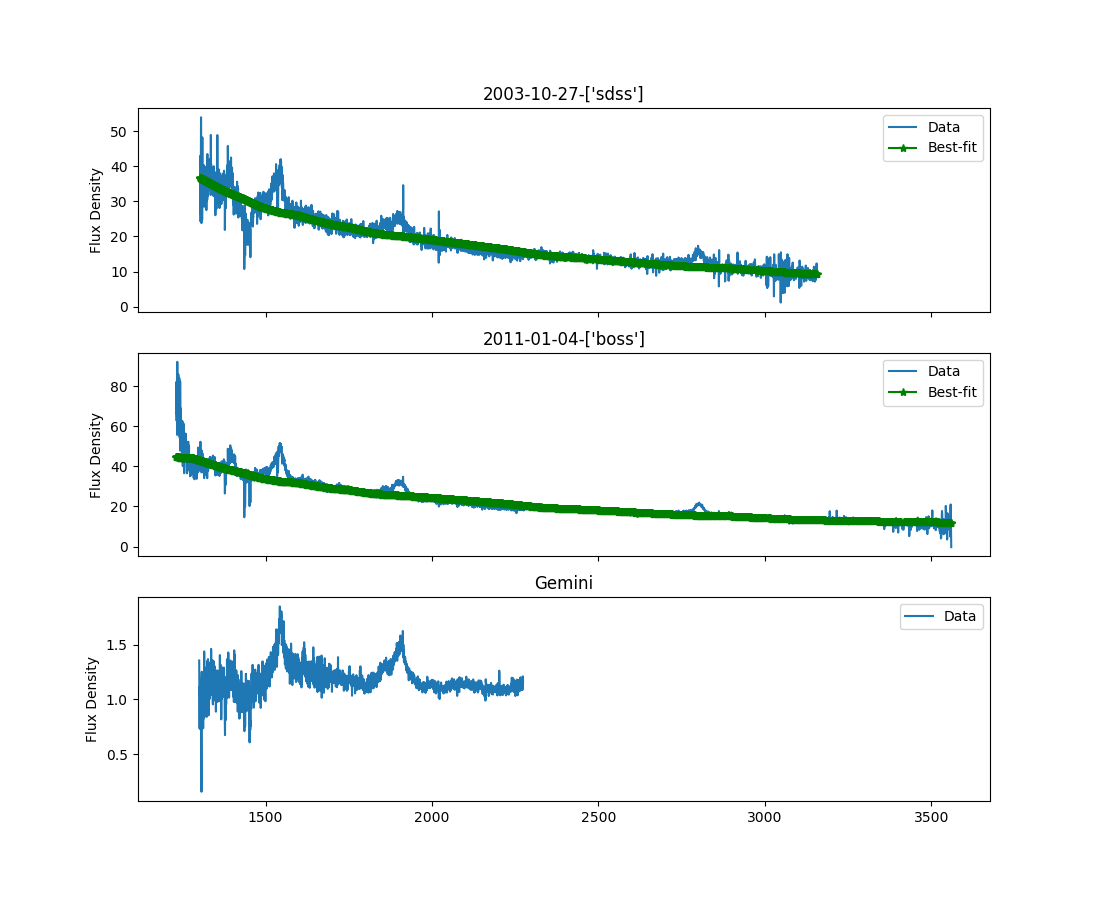

<IPython.core.display.Javascript object>


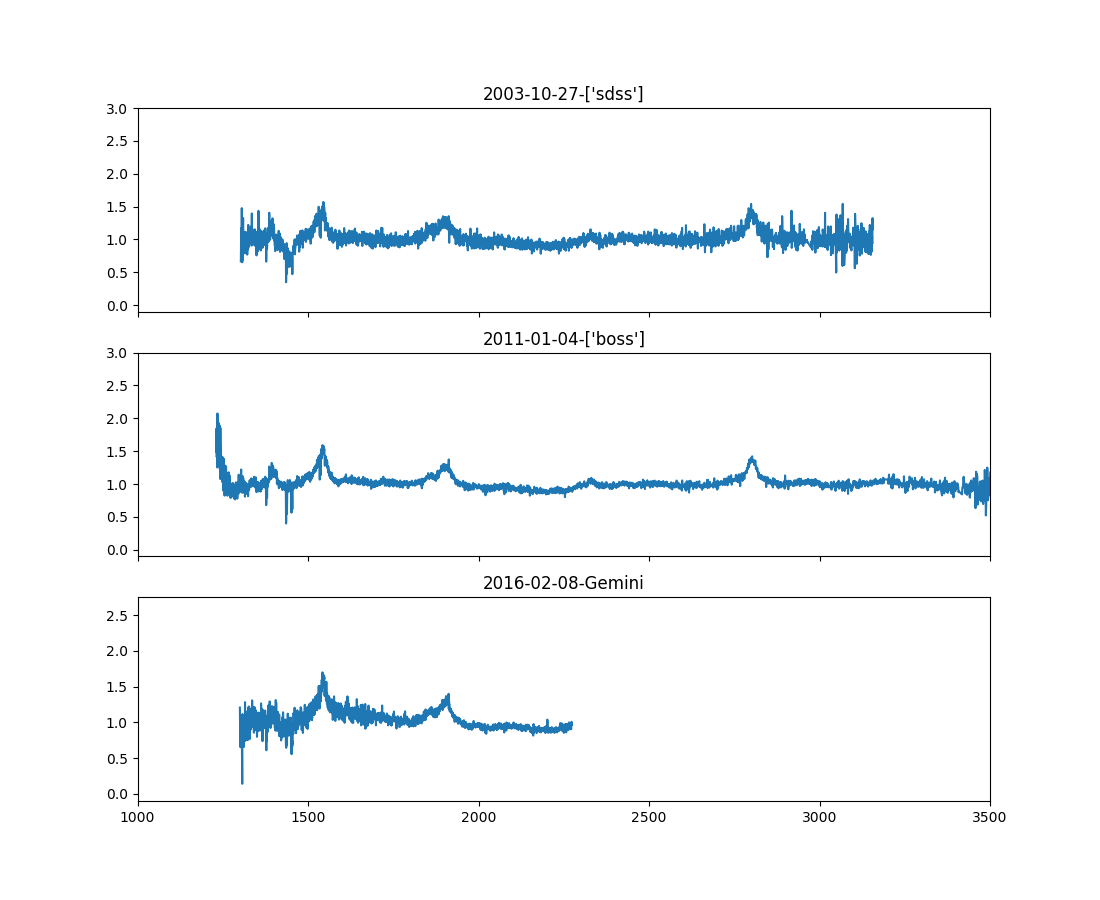

<IPython.core.display.Javascript object>


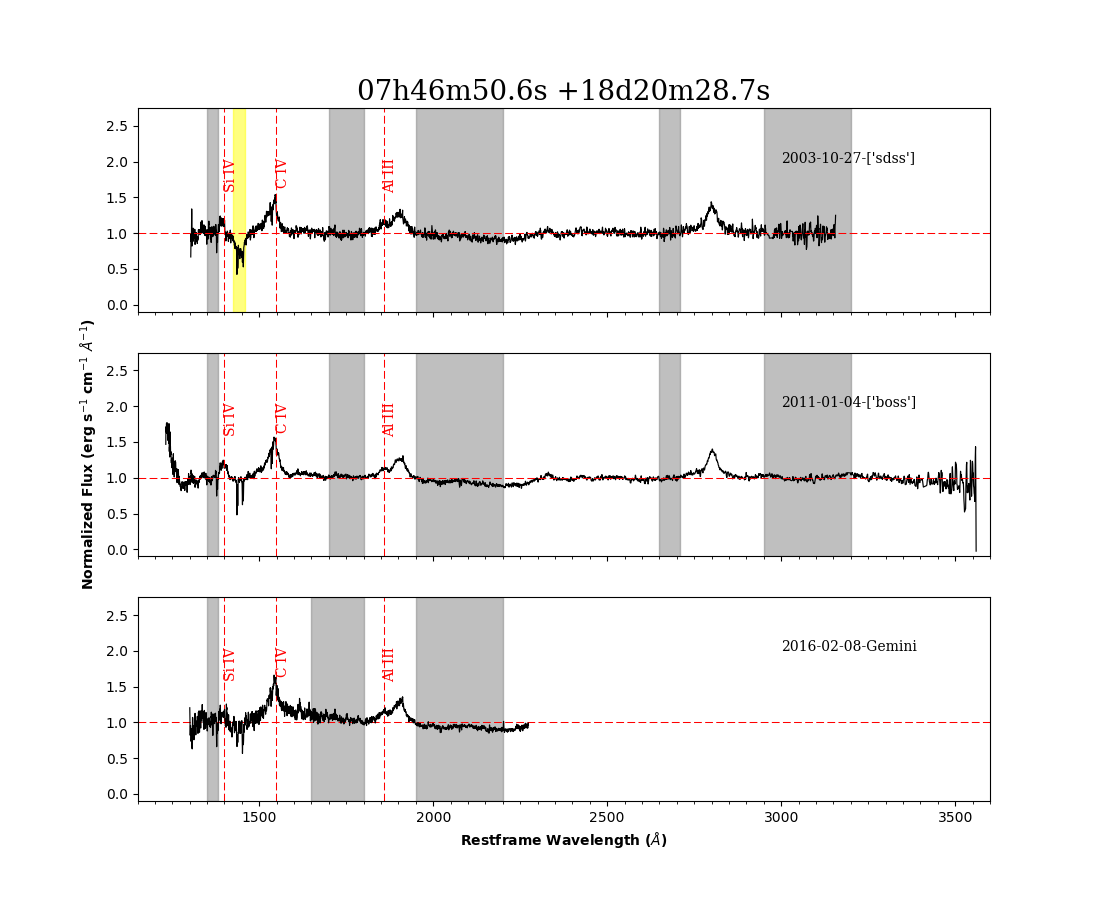

<IPython.core.display.Javascript object>


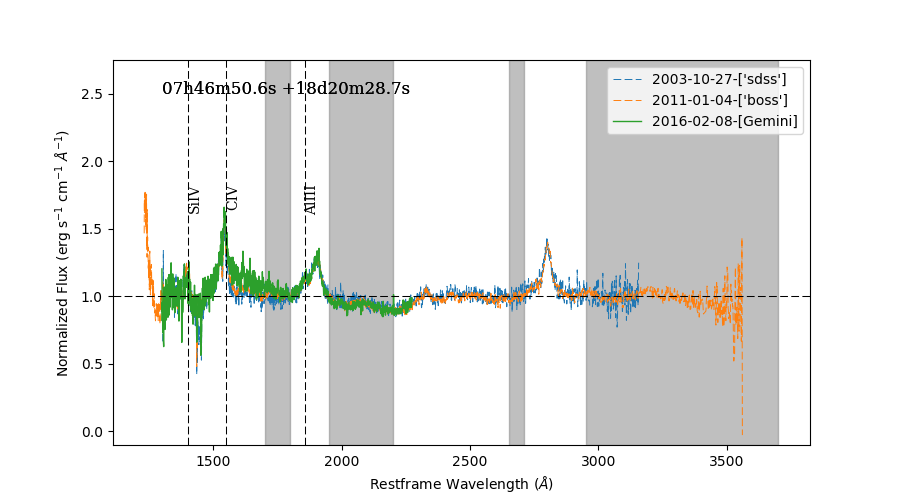

<IPython.core.display.Javascript object>


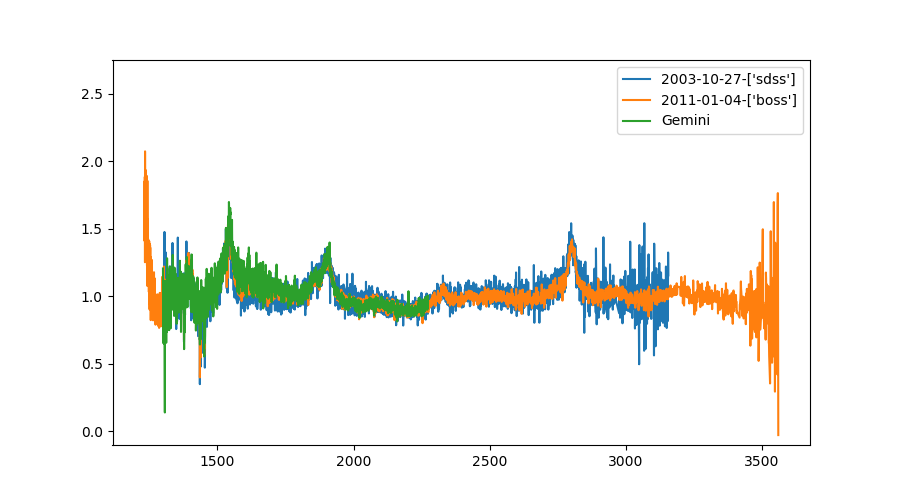

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:142: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[73.81889270713711] [-0.29129117125995668] [1]
[73.81889270713711, 71.40595154307438] [-0.29129117125995668, -0.28668615512493001] [1, 1]
[73.81889270713711, 71.40595154307438, 71.001704499474329] [-0.29129117125995668, -0.28668615512493001, -0.28589869478870517] [1, 1, 1]
[73.81889270713711, 71.40595154307438, 71.001704499474329, 70.719013525138635] [-0.29129117125995668, -0.28668615512493001, -0.28589869478870517, -0.28534526393301513] [1, 1, 1, 1]
[73.81889270713711, 71.40595154307438, 71.001704499474329, 70.719013525138635, 70.658357252885452] [-0.29129117125995668, -0.28668615512493001, -0.28589869478870517, -0.28534526393301513, -0.28522637351573976] [1, 1, 1, 1, 1]
[73.81889270713711, 71.40595154307438, 71.001704499474329, 70.719013525138635, 70.658357252885452, 70.639423448308818] [-0.29129117125995668, -0.28668615512493001, -0.28589869478870517, -0.28534526393301513, -0.28522637351573976, -0.28518918732868992] [1, 1, 1, 1, 1, 1]
[73.81889270713711, 71.40595154307438, 71.001704

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in power


[1.3830044513105393e-05] [1.3825995290521504] [1]
[1.3830044513105393e-05, 1.3624582607128592e-05] [1.3825995290521504, 1.3843569474309285] [1, 1]
[1.3830044513105393e-05, 1.3624582607128592e-05, 1.3686558792710746e-05] [1.3825995290521504, 1.3843569474309285, 1.3837282836843789] [1, 1, 1]
[1.3830044513105393e-05, 1.3624582607128592e-05, 1.3686558792710746e-05, 1.3700628078802098e-05] [1.3825995290521504, 1.3843569474309285, 1.3837282836843789, 1.3835858974103374] [1, 1, 1, 1]
[1.3830044513105393e-05, 1.3624582607128592e-05, 1.3686558792710746e-05, 1.3700628078802098e-05, 1.3700420225313125e-05] [1.3825995290521504, 1.3843569474309285, 1.3837282836843789, 1.3835858974103374, 1.3835880706357842] [1, 1, 1, 1, 1]


In [27]:
#source 2 -- test!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J074650.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['07h46m50.6s +18d20m28.7s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-02-08']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.9163]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1162] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    import uncertainties.unumpy as unumpy  
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    else:
       
        
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        
        red_datum=[]
        red_datum_mod=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))
        
        ct=[]
        for xx in range(len(datum)):
            if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
        
        for xx in range(len(red_datum)):
            if (1350 <= red_datum[xx][0] <= 1380):
                
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
    
        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
        
        
        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])
            
        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            
            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1350 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
                    
            for z,y in zip(wavl,range(len(wavl))):     
                if 1350 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        #axarr2[q].plot(wavl, smoothed_signal)
        axarr2[q].plot(wavl, unumpy.nominal_values(smoothed_signal),color='black',linewidth=0.85)
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        #axarr2[q].tick_params(axis='y',which='minor',left='off')
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        #axarr2[q].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[0].set_title(str(o), fontsize=20,family='serif', color='black')
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)

#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             #axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[q].axvspan(2950, 3200, alpha=0.5, color='grey')
        
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1300:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,flux_err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1350 <= red_datum[xx][0] <= 1380):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1650 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1650 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y))) 
                
        ct=[]
        for xx in range(len(datum)):
            if (2900 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2900 <= red_datum[xx][0] <= 3700):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y))) 
        
        amp=1.0
        
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            
            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1350 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
                    
            for z,y in zip(wavl,range(len(wavl))):     
                if 1350 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1650 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1650 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
                        
            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        smoothed_signal = savgol_filter(normalized, 3, 1)
        if n == "J133211.apo":
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1150,3600)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].tick_params(axis='x',which='minor',direction='in')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             #axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1650, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    #axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

<IPython.core.display.Javascript object>


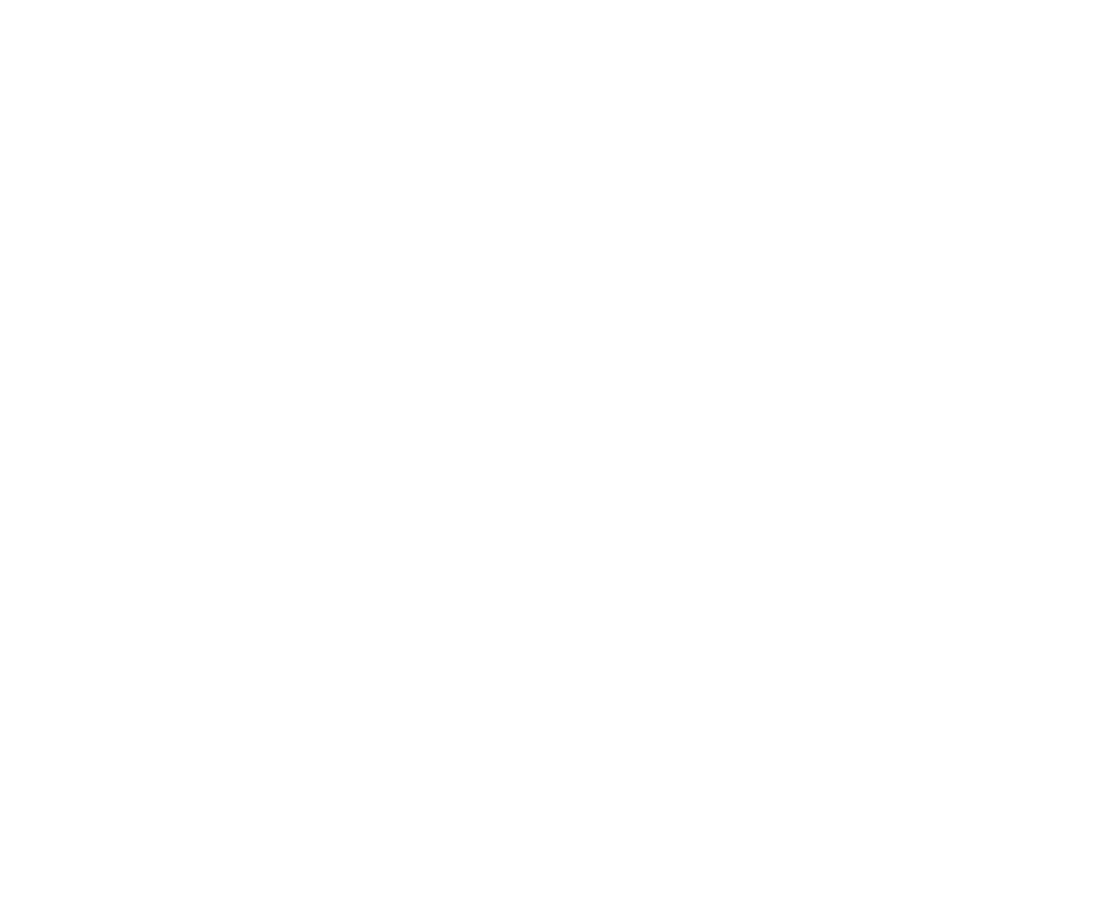

<IPython.core.display.Javascript object>


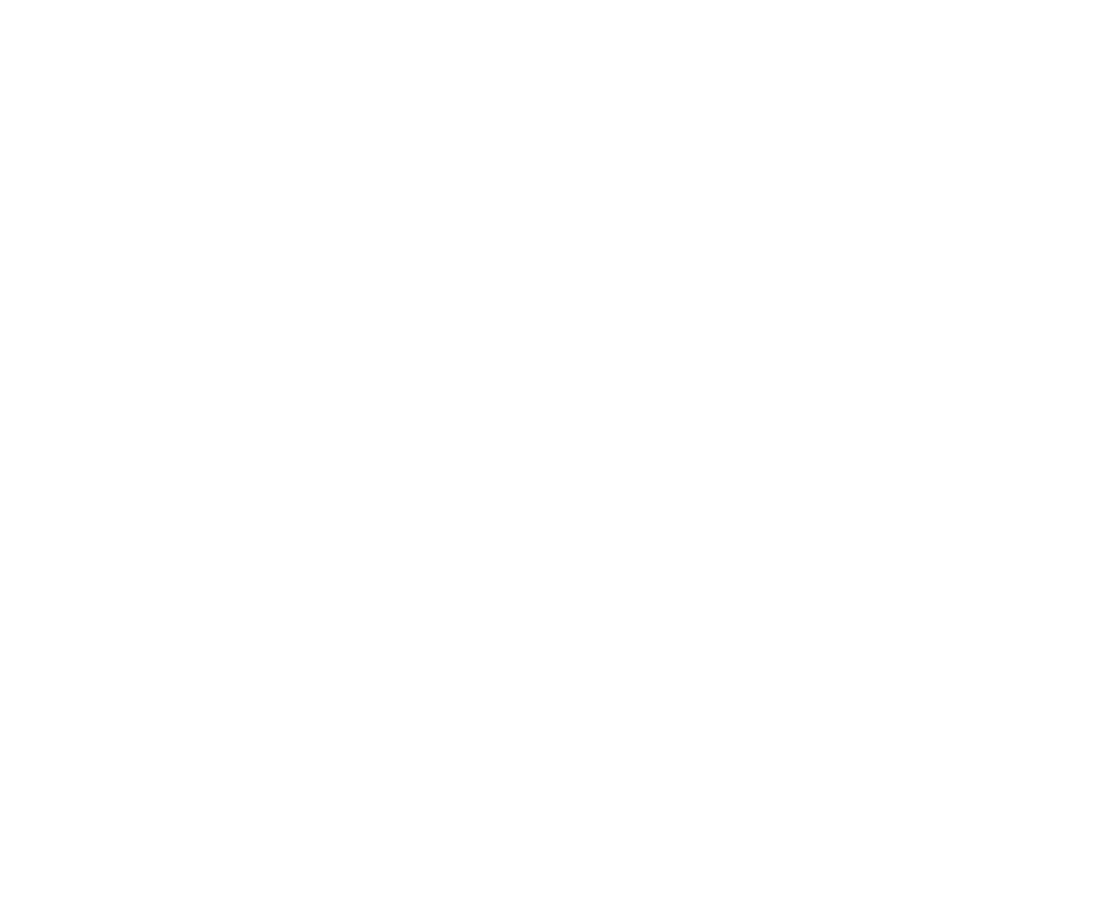

<IPython.core.display.Javascript object>


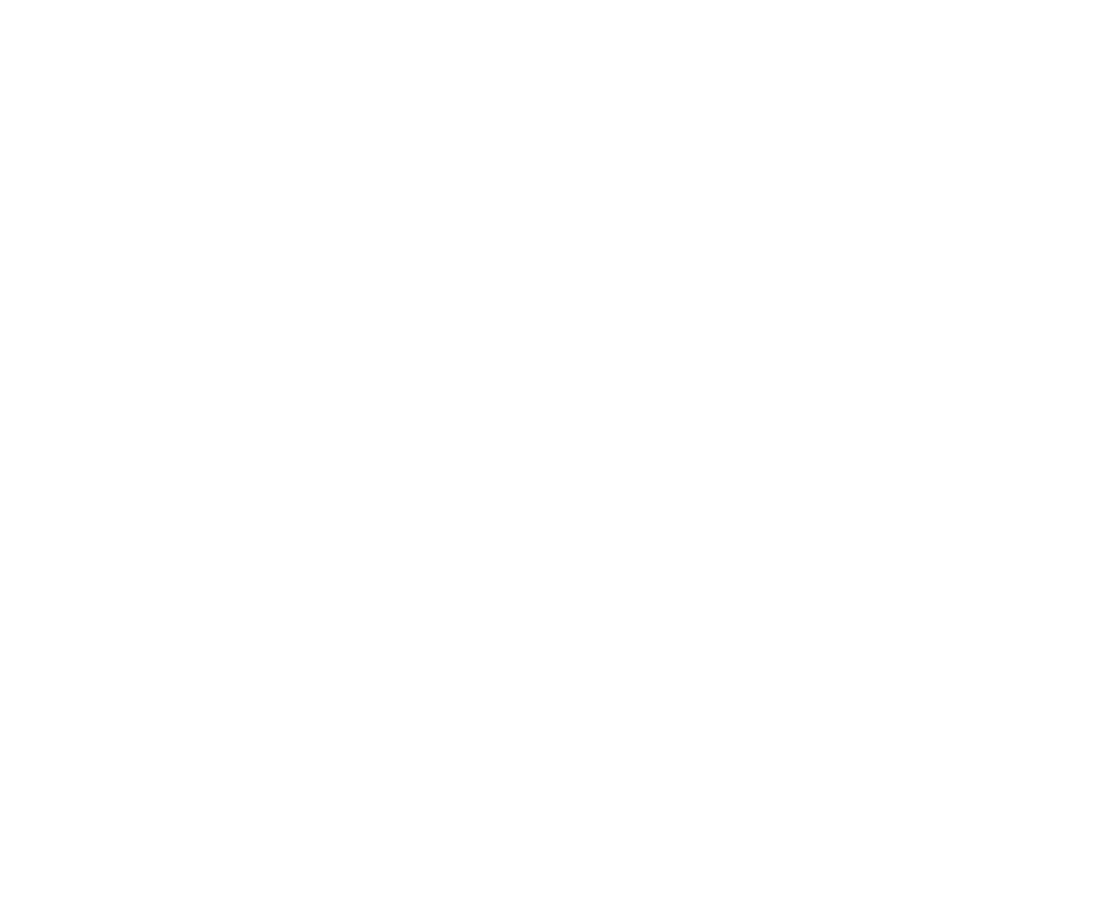

<IPython.core.display.Javascript object>


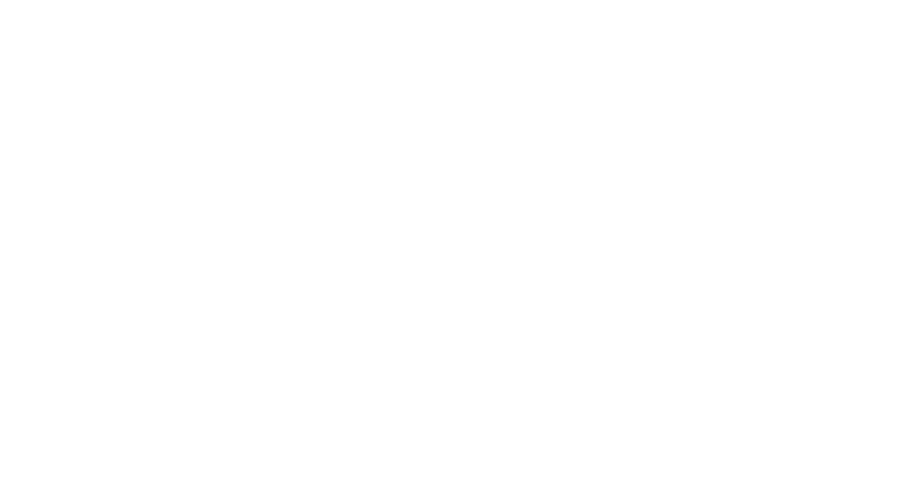

<IPython.core.display.Javascript object>


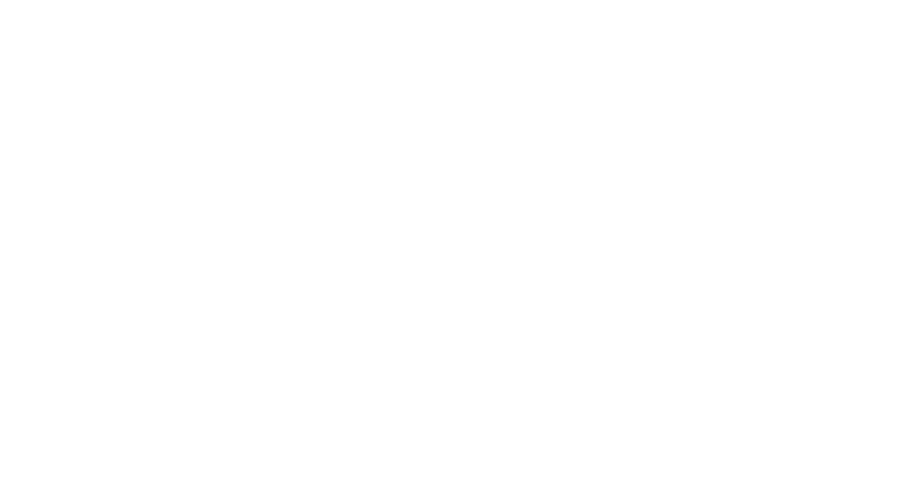

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:159: RuntimeWarning: divide by zero encountered in log


IndexError: tuple index out of range

In [16]:
### source 3 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J085904.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['08h59m04.6s +04d26m47.8s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-02-11']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.8104]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1204] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            if q==0:
                flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
                wavl.append(k/(1.0+p))
                if lm == 0:
                    err.append(dered_flux(r,k,j)/100.0)
                else:
                    err.append(lm)
            
            elif q==1:
                if dered_flux(r,k,j)>0 and k/(1.0+p)>1300:
                    flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
                    wavl.append(k/(1.0+p))
                    if lm == 0:
                        err.append(dered_flux(r,k,j)/100.0)
                    else:
                        err.append(lm)
                        
            else:
                if dered_flux(r,k,j)>0 and k/(1.0+p)>1300:
                    flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
                    wavl.append(k/(1.0+p))
                    if lm == 0:
                        err.append(dered_flux(r,k,j)/100.0)
                    else:
                        err.append(lm)
            
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==0:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if  (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3500) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
       
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
               
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        elif q==1:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if   (1410 <= datum[m][0] <= 1440) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3500) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1300 <= z <= 1380:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1300 <= z <= 1380:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1350 <= z <= 1380:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1350 <= z <= 1380:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
                            
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1550 <= z <= 1800:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1550 <= z <= 1800:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        else:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if (1350 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3500) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1350 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1350 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
                

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])   
                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        if q==0:
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        elif q==1:
            #axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p) > 1250:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1350 <= red_datum[xx][0] <= 1380):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3700):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1240,3750)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        #param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

<IPython.core.display.Javascript object>


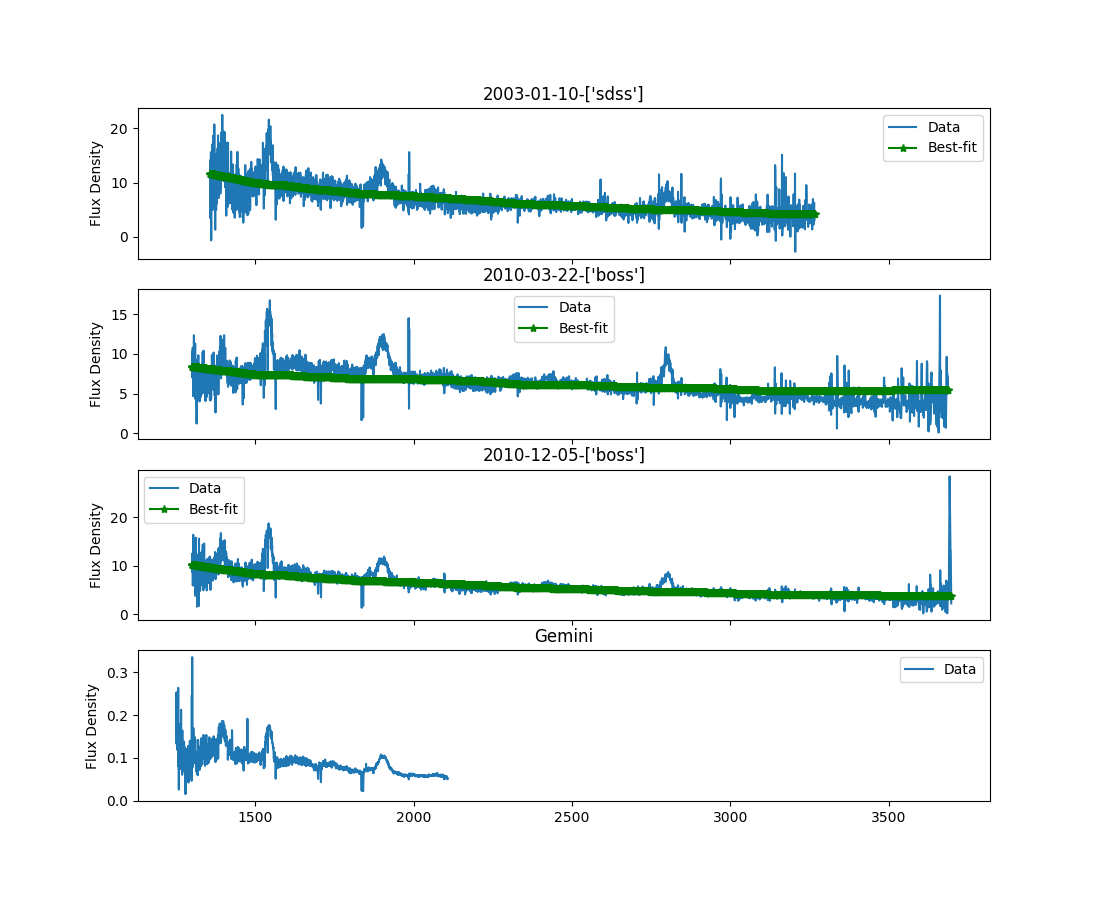

<IPython.core.display.Javascript object>


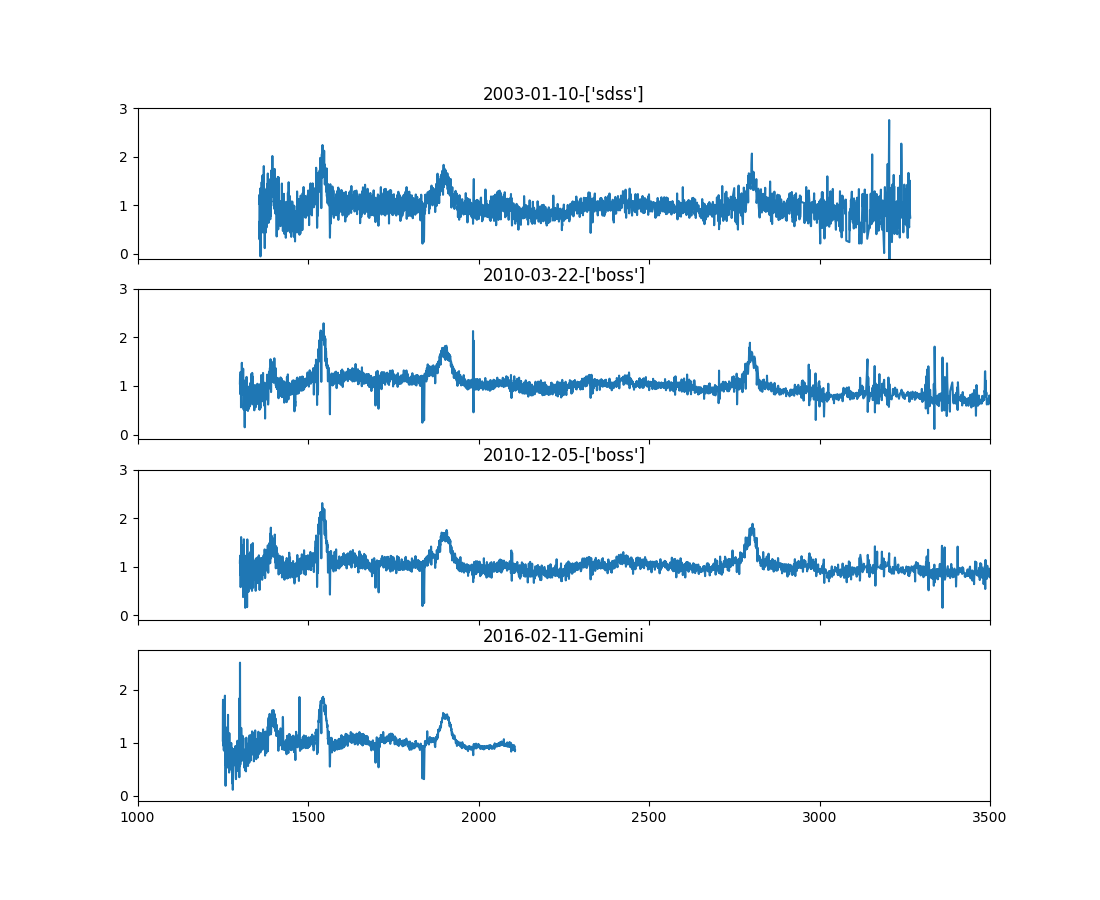

<IPython.core.display.Javascript object>


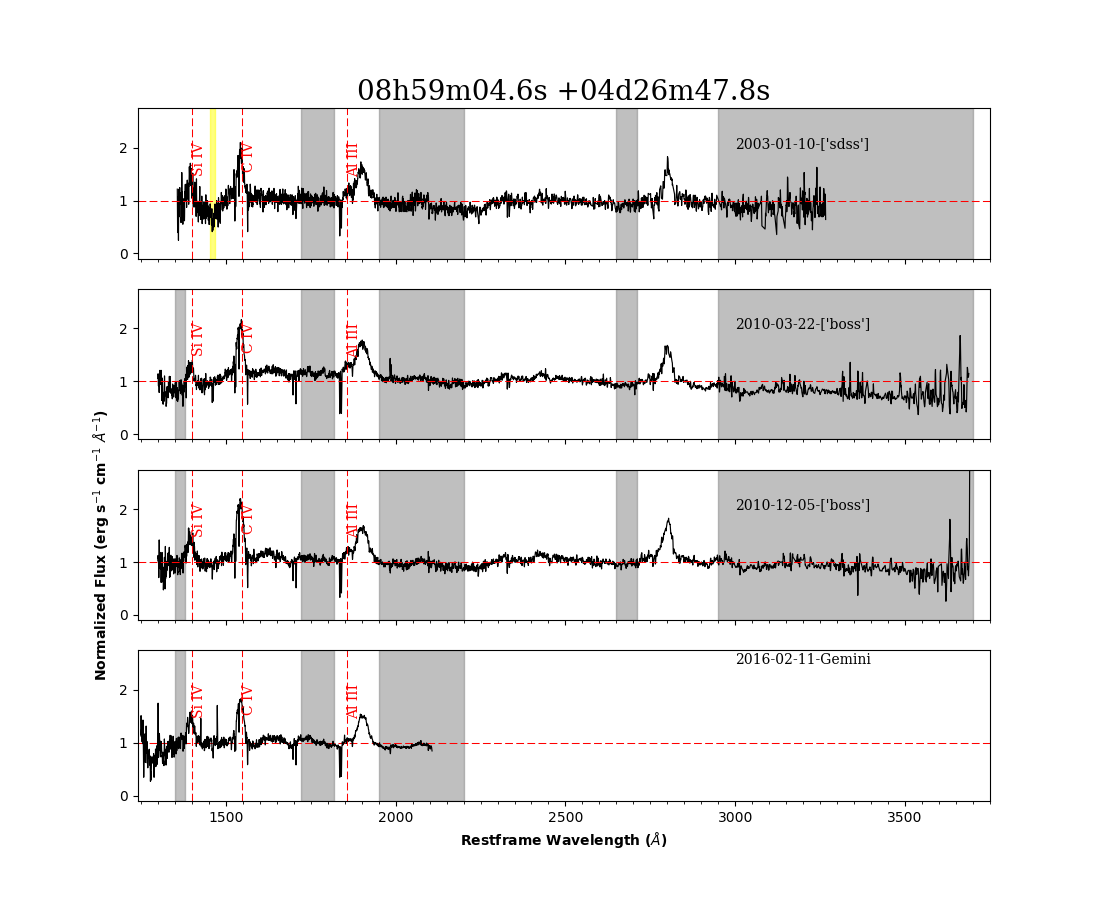

<IPython.core.display.Javascript object>


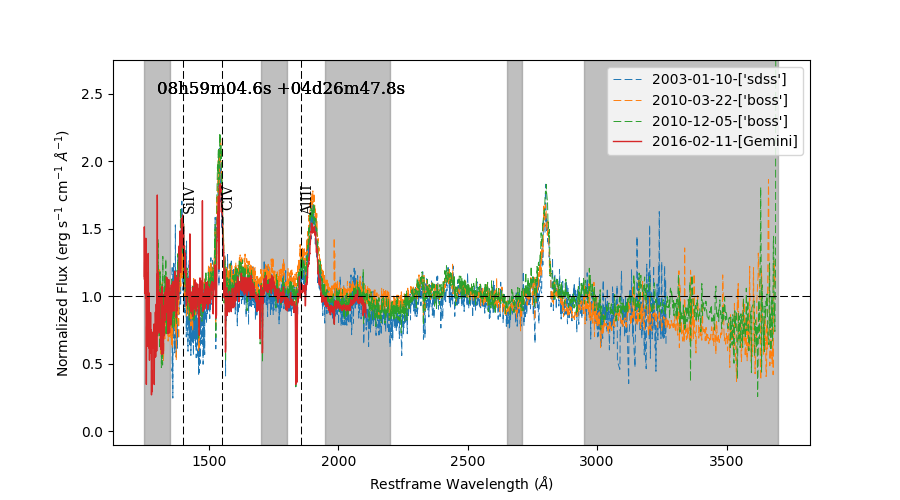

<IPython.core.display.Javascript object>


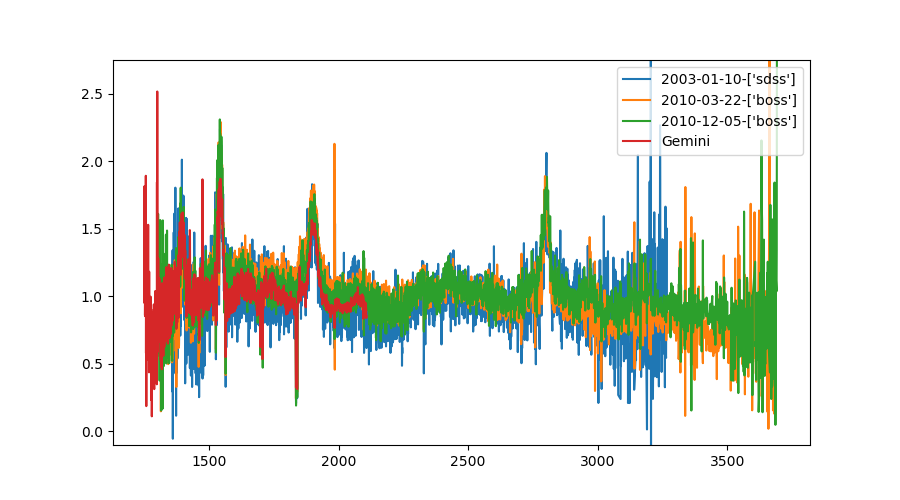

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:159: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[0.47877105473628978] [0.25095927612527424] [1]
[0.47877105473628978, 1.8500262777414449] [0.25095927612527424, 0.071683884206947907] [1, 1]
[0.47877105473628978, 1.8500262777414449, 1.930097452730887] [0.25095927612527424, 0.071683884206947907, 0.065801038955635549] [1, 1, 1]
[0.47877105473628978, 1.8500262777414449, 1.930097452730887, 1.930097452730887] [0.25095927612527424, 0.071683884206947907, 0.065801038955635549, 0.065801038955635549] [1, 1, 1, 1]
[0.0085698053570642911] [0.76594716269169816] [1]
[0.0085698053570642911, 0.0085474670647816171] [0.76594716269169816, 0.76625047731980322] [1, 1]
[0.0085698053570642911, 0.0085474670647816171, 0.0085452887553645954] [0.76594716269169816, 0.76625047731980322, 0.76628148967308307] [1, 1, 1]
[0.0085698053570642911, 0.0085474670647816171, 0.0085452887553645954, 0.0085452669261505357] [0.76594716269169816, 0.76625047731980322, 0.76628148967308307, 0.76628180510148691] [1, 1, 1, 1]
[0.00071552845265868495] [1.1197592574505326] [1]
[0.000715

In [26]:
### source 3 --test-- have a relook--done its' good
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J085904.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['08h59m04.6s +04d26m47.8s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-02-11']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.8104]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1204] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            if q==0:
                flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
                wavl.append(k/(1.0+p))
                if lm == 0:
                    err.append(dered_flux(r,k,j)/100.0)
                else:
                    err.append(lm)
            
            elif q==1:
                if dered_flux(r,k,j)>0 and k/(1.0+p)>1300:
                    flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
                    wavl.append(k/(1.0+p))
                    if lm == 0:
                        err.append(dered_flux(r,k,j)/100.0)
                    else:
                        err.append(lm)
                        
            else:
                if dered_flux(r,k,j)>0 and k/(1.0+p)>1300:
                    flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
                    wavl.append(k/(1.0+p))
                    if lm == 0:
                        err.append(dered_flux(r,k,j)/100.0)
                    else:
                        err.append(lm)
            
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        
        if q==0:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))
            ct=[]
            for xx in range(len(datum)):
                if (1720 <= datum[xx][0] <= 1820) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1720 <= red_datum[xx][0] <= 1820):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1720 <= z <= 1820:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1720 <= z <= 1820:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
            
                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
                
        elif q==1:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

#             ct=[]
#             for xx in range(len(datum)):
#                 if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (1350 <= red_datum[xx][0] <= 1380):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1400 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1400 <= red_datum[xx][0] <= 1440):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (1575 <= datum[xx][0] <= 1675) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (1575 <= red_datum[xx][0] <= 1675):

#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1720 <= datum[xx][0] <= 1820) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1720 <= red_datum[xx][0] <= 1820):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                
                
#                 k=[]
#                 nombr=0
#                 wt=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1350 <= z <= 1380:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)

#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1350 <= z <= 1380:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)
                
                
                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1400 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1400 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
#                 k=[]
#                 nombr=0

#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1575 <= z <= 1675:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1575 <= z <= 1675:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-7*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+7*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)
                
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1720 <= z <= 1820:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1720 <= z <= 1820:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.98*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.98*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
            
                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1350 <= red_datum[xx][0] <= 1380):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1720 <= datum[xx][0] <= 1820) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1720 <= red_datum[xx][0] <= 1820):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1350 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1350 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1720 <= z <= 1820:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1720 <= z <= 1820:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                            
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
            
                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
                 

#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        if q==0:
            axarr2[q].axvspan(1720, 1820, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        elif q==1:
            #axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1720, 1820, alpha=0.5, color='grey')
            axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
#             axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
#             axarr2[q].axvspan(1575, 1675, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1720, 1820, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()

        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p) > 1250:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1350 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1350 <= red_datum[xx][0] <= 1380):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1820) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1820):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
                
                ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3700):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1350 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1350 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1820:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1820:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1240,3750)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        #param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1350, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1720, 1820, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

In [11]:
#source 4 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J093620.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['09h36m20.5s +00d46m49.2s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-11-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.7213]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1855] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            #if k/(1.0+p)>1250:
            flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==2:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                if (1410 <= datum[m][0] <= 1440) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2750) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2750:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2750:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        elif q==1:
            while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if  (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1410 <= z <= 1440:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1410 <= z <= 1440:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        else:
            while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if  (1410 <= datum[m][0] <= 1440) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1350 <= z <= 1380:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1350 <= z <= 1380:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-5*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+5*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1    
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        if q==0 :
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')

            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        elif q==1:
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            #axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')

            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p) > 1300:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            if (1410 <= datum[i][0] <= 1440) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1410 <= z <= 1440:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1410 <= z <= 1440:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1250,3900)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1410, 1440, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close() 

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:136: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[25.75112324462507] [-0.19329606540430794] [1]
[25.75112324462507, 25.75112324462507] [-0.19329606540430794, -0.19329606540430794] [1, 1]
[25.75112324462507, 25.75112324462507, 25.75112324462507] [-0.19329606540430794, -0.19329606540430794, -0.19329606540430794] [1, 1, 1]
[25.75112324462507, 25.75112324462507, 25.75112324462507, 25.75112324462507] [-0.19329606540430794, -0.19329606540430794, -0.19329606540430794, -0.19329606540430794] [1, 1, 1, 1]
[22.218296010539323] [-0.20649228658628299] [1]
[22.218296010539323, 16.033559013529892] [-0.20649228658628299, -0.1628904612327359] [1, 1]
[22.218296010539323, 16.033559013529892, 13.313755923051732] [-0.20649228658628299, -0.1628904612327359, -0.13780645574283951] [1, 1, 1]
[22.218296010539323, 16.033559013529892, 13.313755923051732, 11.191070146609993] [-0.20649228658628299, -0.1628904612327359, -0.13780645574283951, -0.1144854685431575] [1, 1, 1, 1]
[22.218296010539323, 16.033559013529892, 13.313755923051732, 11.191070146609993, 9.9298764

<IPython.core.display.Javascript object>


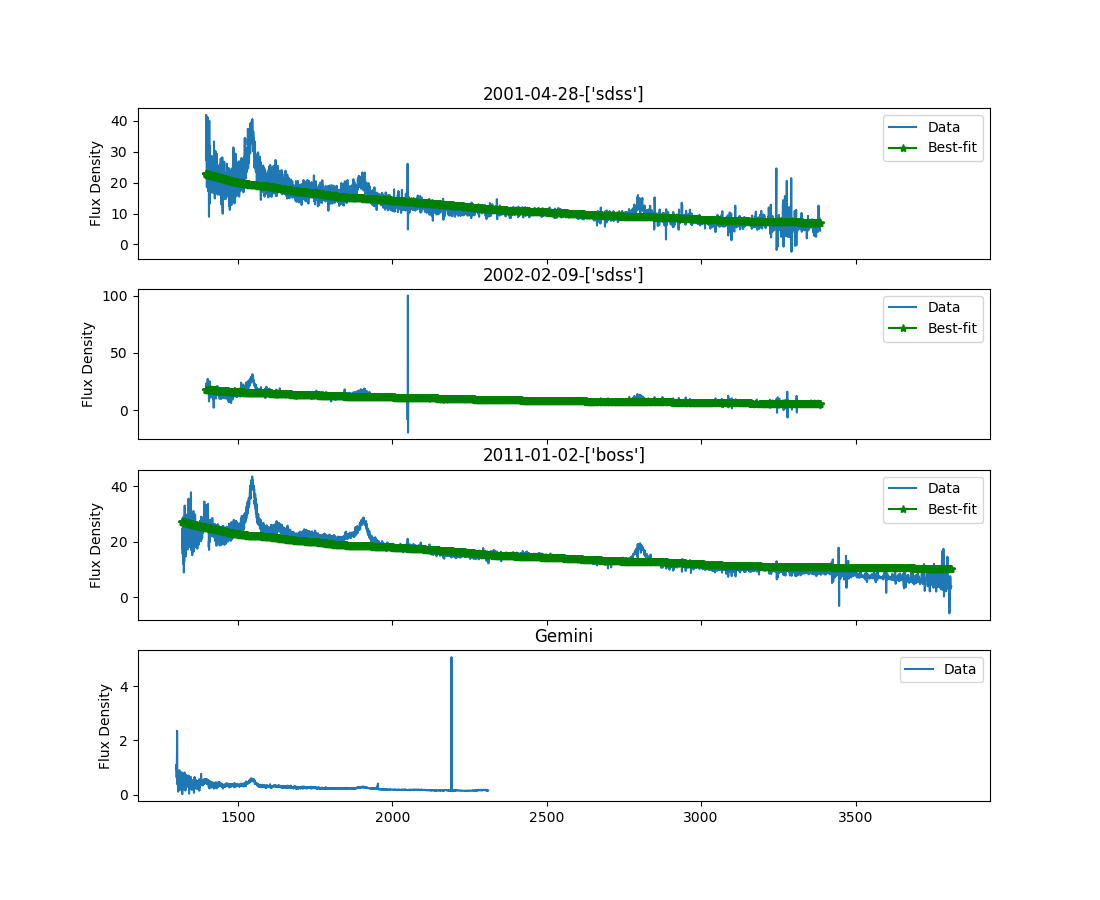

<IPython.core.display.Javascript object>


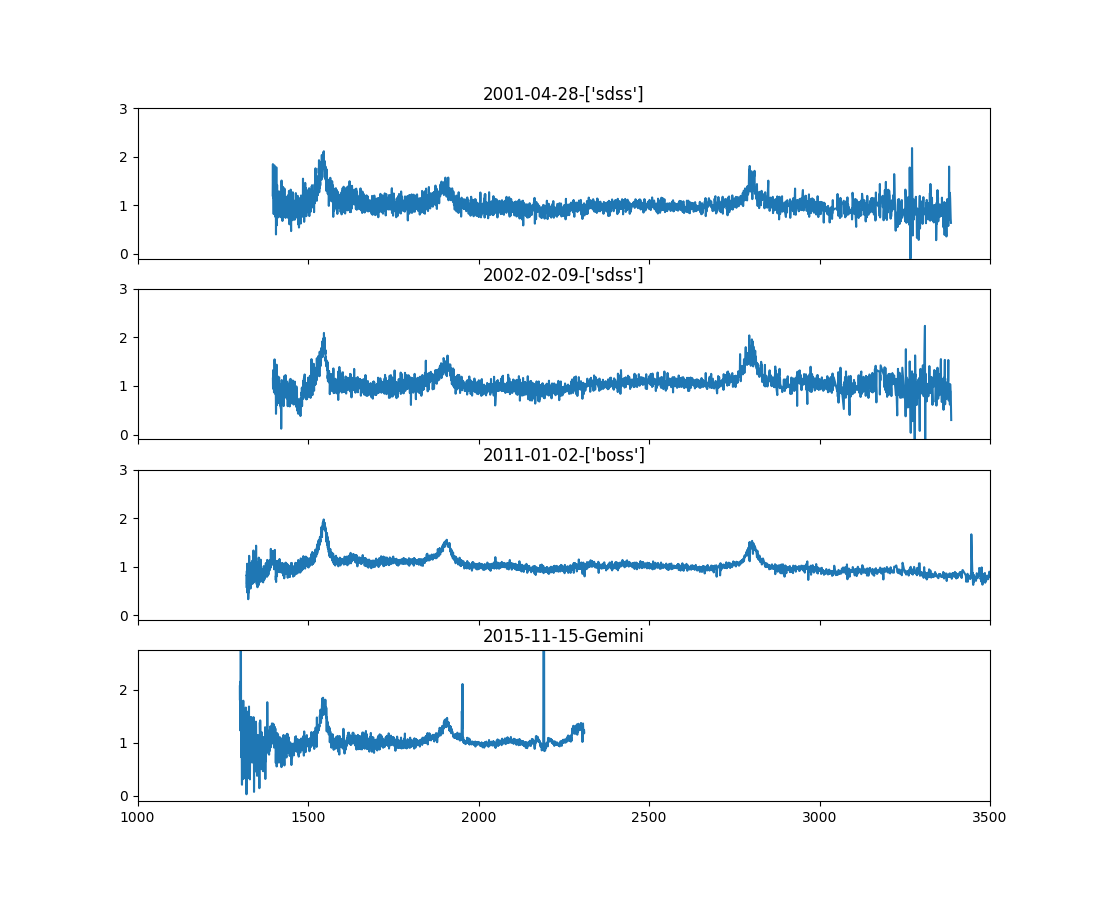

<IPython.core.display.Javascript object>


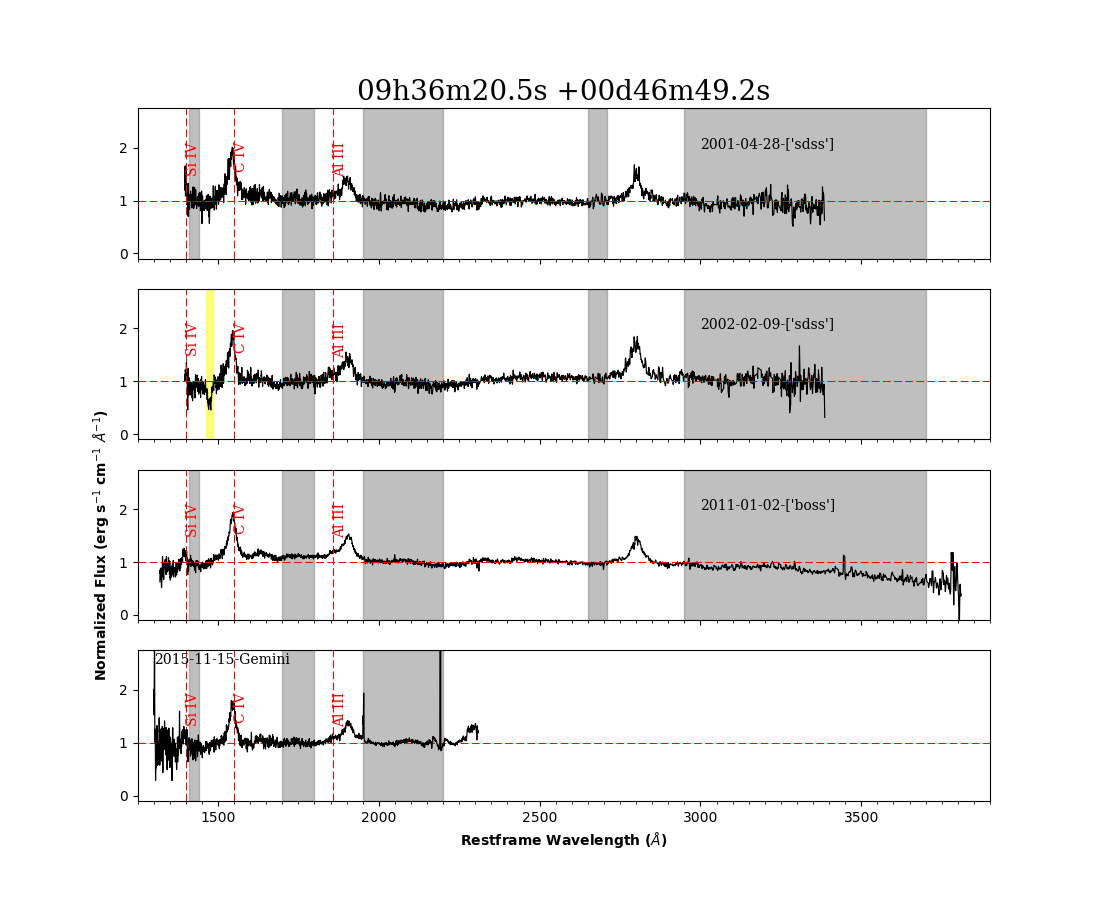

<IPython.core.display.Javascript object>


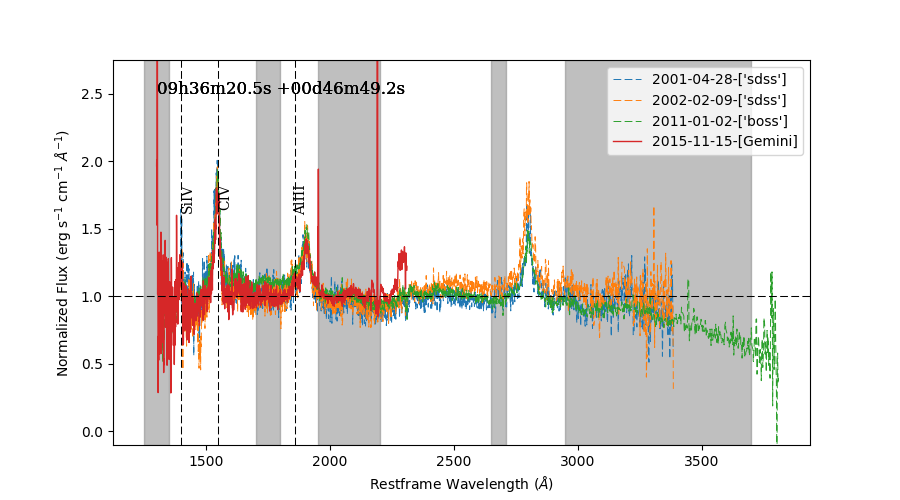

<IPython.core.display.Javascript object>


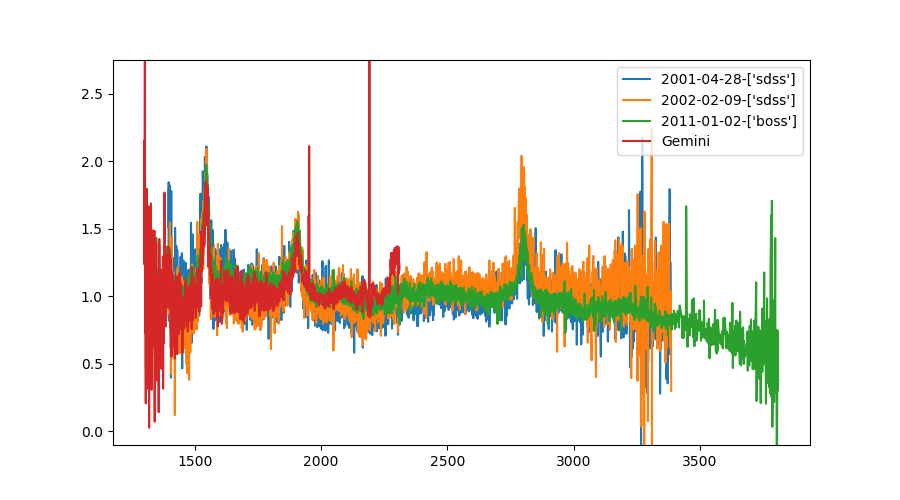

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:136: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[16.914875021493838] [-0.13551574788070381] [1]
[16.914875021493838, 16.914875021493838] [-0.13551574788070381, -0.13551574788070381] [1, 1]
[16.914875021493838, 16.914875021493838, 16.914875021493838] [-0.13551574788070381, -0.13551574788070381, -0.13551574788070381] [1, 1, 1]
[16.914875021493838, 16.914875021493838, 16.914875021493838, 16.914875021493838] [-0.13551574788070381, -0.13551574788070381, -0.13551574788070381, -0.13551574788070381] [1, 1, 1, 1]
[18.127999553416306] [-0.17858075902233095] [1]
[18.127999553416306, 16.305899025666974] [-0.17858075902233095, -0.16431205732433066] [1, 1]
[18.127999553416306, 16.305899025666974, 14.694287889791198] [-0.17858075902233095, -0.16431205732433066, -0.1502546066791334] [1, 1, 1]
[18.127999553416306, 16.305899025666974, 14.694287889791198, 14.176393667757576] [-0.17858075902233095, -0.16431205732433066, -0.1502546066791334, -0.14542031632665059] [1, 1, 1, 1]
[18.127999553416306, 16.305899025666974, 14.694287889791198, 14.17639366775757

In [15]:
#source 4 --testing!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J093620.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['09h36m20.5s +00d46m49.2s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-11-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.7213]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1855] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            #if k/(1.0+p)>1250:
            flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        
        if q==2:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2750) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2750):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2750:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2750:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        elif q==1:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

#             ct=[]
#             for xx in range(len(datum)):
#                 if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (1250 <= red_datum[xx][0] <= 1350):

#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
            
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
            

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-5*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+5*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        if q==0 :
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')

            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        elif q==1:
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            #axarr2[q].axvspan(1350, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')

            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p) > 1300:
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,flux_err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1250 <= red_datum[xx][0] <= 1350):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


#         ct=[]
#         for xx in range(len(datum)):
#             if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2650 <= red_datum[xx][0] <= 2710):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y)))
                
#                 ct=[]
#         for xx in range(len(datum)):
#             if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2950 <= red_datum[xx][0] <= 3700):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y)))
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1410 <= z <= 1440:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1410 <= z <= 1440:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2650 <= z <= 2710:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2650 <= z <= 2710:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2950 <= z <= 3700:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2950 <= z <= 3700:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.75,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.75,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.75,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1250,3900)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1410, 1440, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close() 

In [17]:
sigma

NameError: name 'sigma' is not defined

In [73]:
#source 5 - modified after Prof.P.Hall suggestion as on 6th sept # issue resolved! -testing!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J114546.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['11h45m46.2s +03d22m51.9s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-03-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0075]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0709] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            
            #deredden the flux
           
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==0:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2500) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1300 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if (1365 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2350 <= datum[m][0] <= 2500) :
                    red_datum.append(datum[m])
                m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1365 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1365 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2350 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2350 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3700:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3700:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        else:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2500) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1300 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                if (1365 <= datum[m][0] <= 1380) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2350 <= datum[m][0] <= 2500) :
                    red_datum.append(datum[m])
                m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1365 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1365 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2350 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2350 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3700:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3700:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2500,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
        print (str(o),param[5],param[6])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        if q==0:
            axarr2[q].axvspan(1365, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2350, 2500, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1365, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2350, 2500, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')    
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1350 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            if (1350 <= datum[i][0] <= 1380) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1365 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1365 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+4*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2500,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.90,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.90,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.90,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1250,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10 ,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1365, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    #axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1365, 1380, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
#     axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
#     axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[13.306985800181554] [-0.20617520414632423] [1]
[13.306985800181554, 13.306990203426892] [-0.20617520414632423, -0.20617524913612917] [1, 1]
[13.306985800181554, 13.306990203426892, 13.306990203426892] [-0.20617520414632423, -0.20617524913612917, -0.20617524913612917] [1, 1, 1]
[13.306985800181554, 13.306990203426892, 13.306990203426892, 13.306990203426892] [-0.20617520414632423, -0.20617524913612917, -0.20617524913612917, -0.20617524913612917] [1, 1, 1, 1]
11h45m46.2s +03d22m51.9s 1486.25863726 1501.39300187
[8.1216054508634841] [-0.097917926596203408] [1]
[8.1216054508634841, 8.1216054508634841] [-0.097917926596203408, -0.097917926596203408] [1, 1]
[8.1216054508634841, 8.1216054508634841, 8.1216054508634841] [-0.097917926596203408, -0.097917926596203408, -0.097917926596203408] [1, 1, 1]
[8.1216054508634841, 8.1216054508634841, 8.1216054508634841, 8.1216054508634841] [-0.097917926596203408, -0.097917926596203408, -0.097917926596203408, -0.097917926596203408] [1, 1, 1, 1]
11h45m46.2s +

<IPython.core.display.Javascript object>


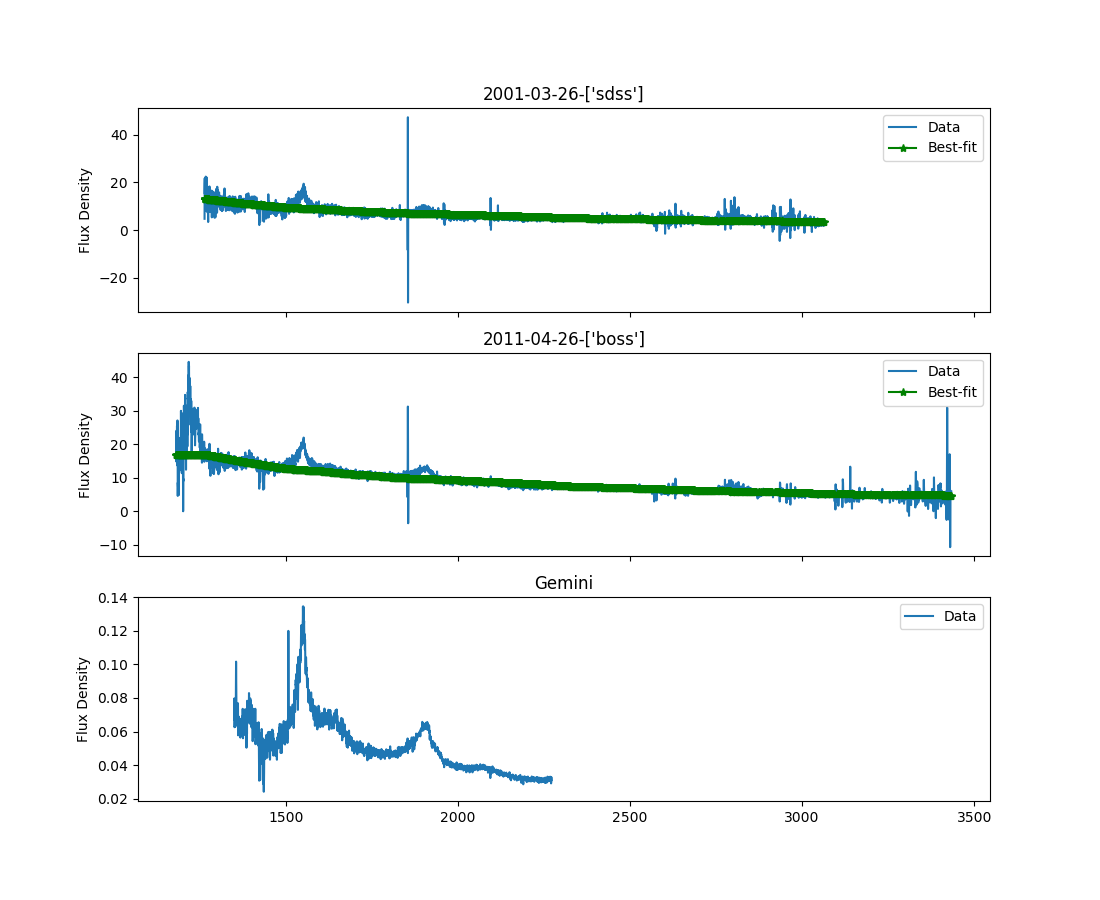

<IPython.core.display.Javascript object>


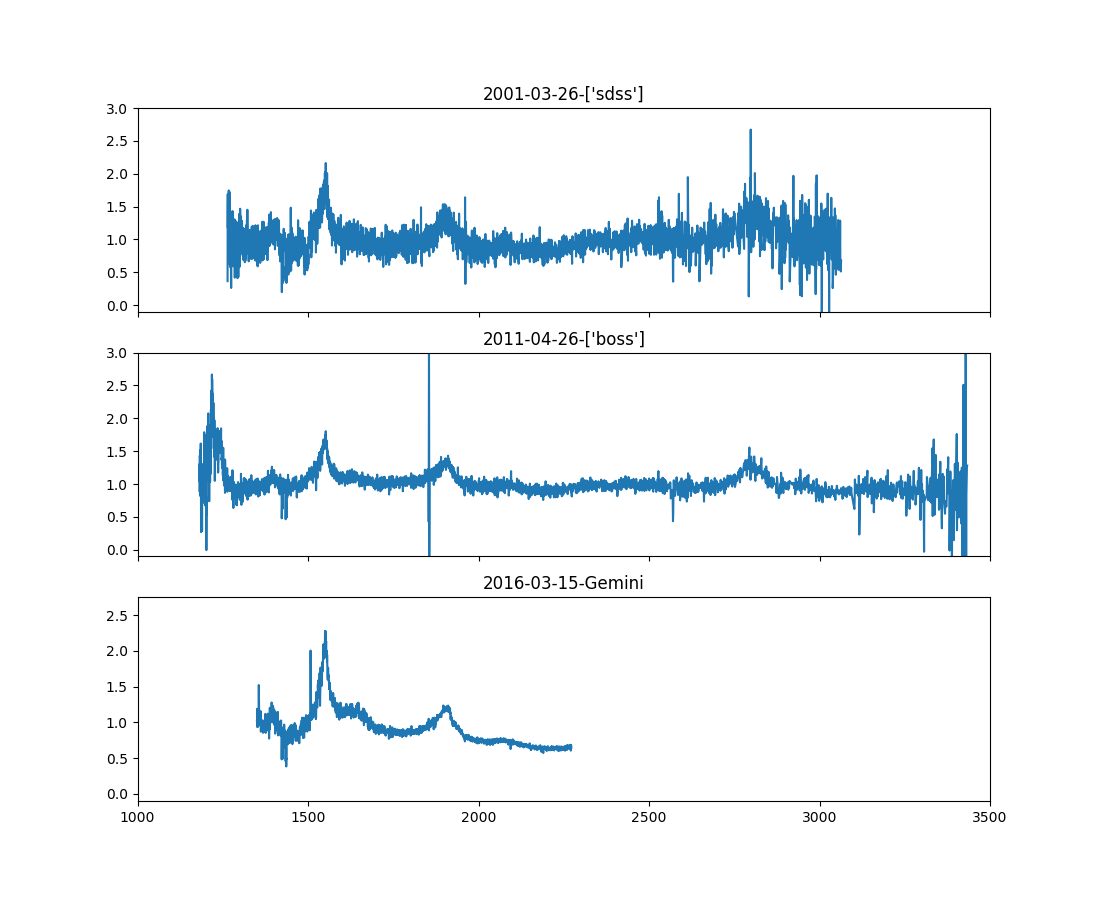

<IPython.core.display.Javascript object>


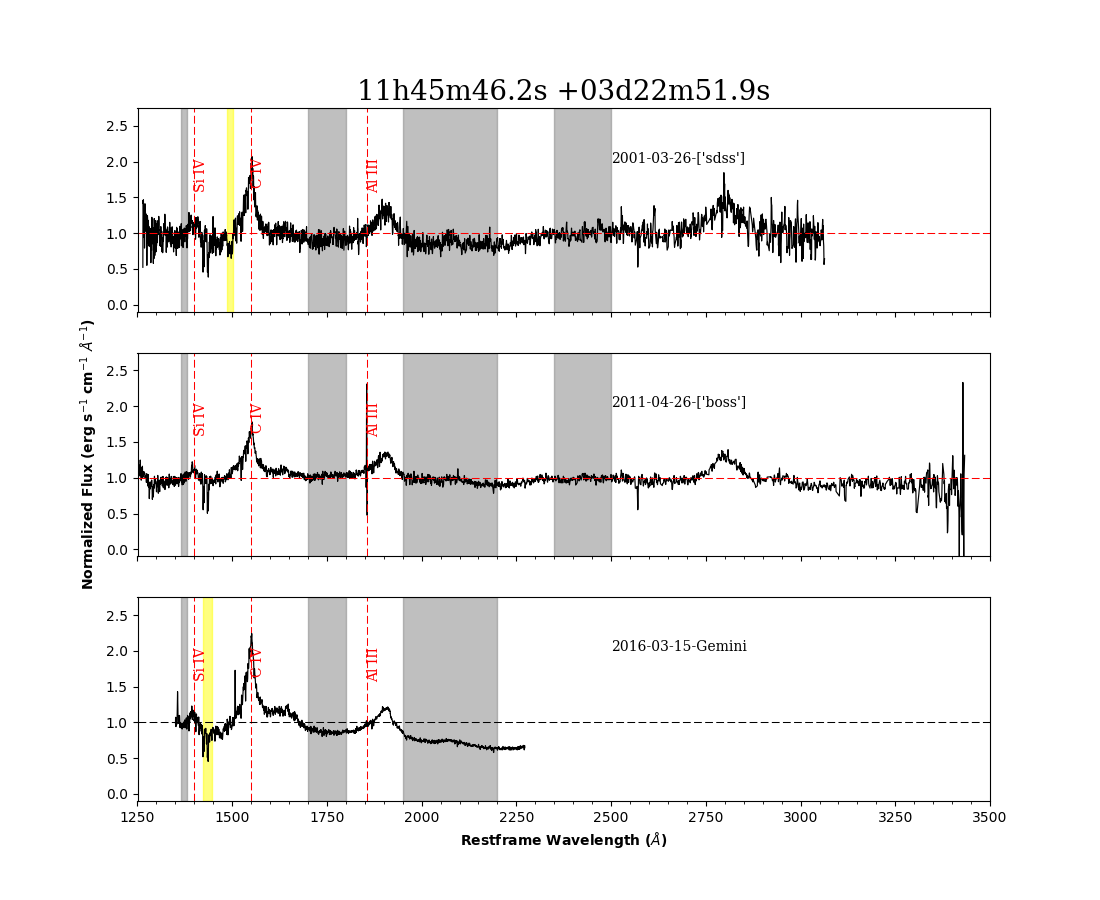

<IPython.core.display.Javascript object>


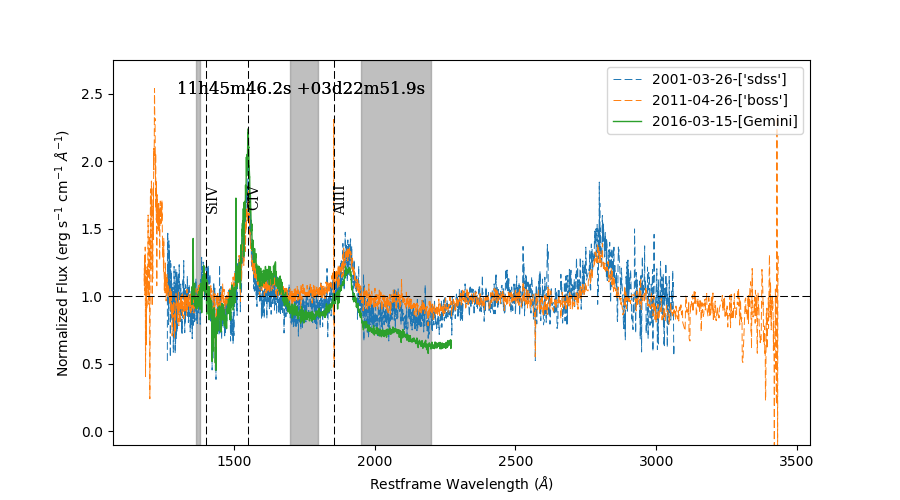

<IPython.core.display.Javascript object>


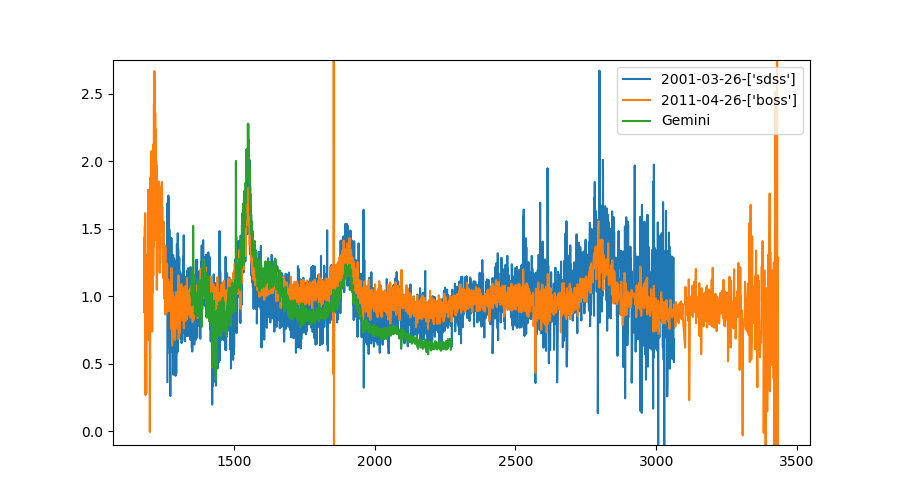

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[21.967079665250409] [-0.27457245374492839] [1]
[21.967079665250409, 22.002539959936016] [-0.27457245374492839, -0.27479547627235551] [1, 1]
[21.967079665250409, 22.002539959936016, 22.002539959936016] [-0.27457245374492839, -0.27479547627235551, -0.27479547627235551] [1, 1, 1]
[21.967079665250409, 22.002539959936016, 22.002539959936016, 22.002539959936016] [-0.27457245374492839, -0.27479547627235551, -0.27479547627235551, -0.27479547627235551] [1, 1, 1, 1]
11h45m46.2s +03d22m51.9s 1486.25863726 1501.39300187
[6.6216642037538129] [-0.070107457749188667] [1]
[6.6216642037538129, 6.5858893978828963] [-0.070107457749188667, -0.069359298551952525] [1, 1]
[6.6216642037538129, 6.5858893978828963, 6.5533776948805569] [-0.070107457749188667, -0.069359298551952525, -0.068670817114935986] [1, 1, 1]
[6.6216642037538129, 6.5858893978828963, 6.5533776948805569, 6.5434748634663125] [-0.070107457749188667, -0.069359298551952525, -0.068670817114935986, -0.068461975482554047] [1, 1, 1, 1]
[6.6216642037

In [11]:
#source 5 - modified after Prof.P.Hall suggestion as on 6th sept # issue resolved! -testing! --testing!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J114546.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['11h45m46.2s +03d22m51.9s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-03-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0075]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0709] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            
            #deredden the flux
           
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        
        if q==0:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1365 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1365 <= red_datum[xx][0] <= 1380):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2350 <= datum[xx][0] <= 2500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2350 <= red_datum[xx][0] <= 2500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))   
                    
                    
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1365 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1365 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2350 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2350 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
                        
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1365 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1365 <= red_datum[xx][0] <= 1380):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2350 <= datum[xx][0] <= 2500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2350 <= datum[xx][0] <= 2500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1365 <= z <= 1380:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1365 <= z <= 1380:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2350 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2350 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

#                 k=[]
#                 nombr=0

#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3700:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3700:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)

                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1           
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2500,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
        print (str(o),param[5],param[6])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        
        if q==0:
            axarr2[q].axvspan(1365, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2350, 2500, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1365, 1380, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2350, 2500, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
#             axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')    
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1350 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,flux_err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1365 <= datum[xx][0] <= 1380) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1365 <= red_datum[xx][0] <= 1380):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


#         ct=[]
#         for xx in range(len(datum)):
#             if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2650 <= red_datum[xx][0] <= 2710):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y)))  
                
#         ct=[]
#         for xx in range(len(datum)):
#             if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2950 <= red_datum[xx][0] <= 3200):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y)))  
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1365 <= z <= 1380:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1365 <= z <= 1380:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2650 <= z <= 2710:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2650 <= z <= 2710:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2950 <= z <= 3200:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2950 <= z <= 3200:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2500,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.90,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.90,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.90,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1250,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10 ,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1365, 1380, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    #axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1365, 1380, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
#     axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
#     axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

In [27]:
flux_err

[0.012365,
 0.0123591,
 0.012477,
 0.0120767,
 0.0120315,
 0.0121216,
 0.0122418,
 0.0122439,
 0.0121887,
 0.0122742,
 0.0121991,
 0.0119712,
 0.011917,
 0.0119607,
 0.0119667,
 0.0120395,
 0.0120332,
 0.0121076,
 0.0122325,
 0.0122257,
 0.0122293,
 0.0119898,
 0.0118679,
 0.0119355,
 0.0119706,
 0.0117106,
 0.0116226,
 0.0115074,
 0.01153,
 0.0112562,
 0.0113941,
 0.0113558,
 0.0115854,
 0.0117216,
 0.0115092,
 0.0114953,
 0.0117139,
 0.011505,
 0.0112446,
 0.0113895,
 0.0111858,
 0.0112156,
 0.0113042,
 0.0112751,
 0.0109082,
 0.0110823,
 0.0111213,
 0.0110272,
 0.0109944,
 0.0110764,
 0.0110413,
 0.0109703,
 0.0109282,
 0.0110258,
 0.011009,
 0.0108707,
 0.0108894,
 0.0108949,
 0.0107888,
 0.0106803,
 0.010903,
 0.0108783,
 0.0106898,
 0.0107353,
 0.0107289,
 0.0108025,
 0.0105925,
 0.010553,
 0.0107575,
 0.0108469,
 0.0106089,
 0.0104546,
 0.0105364,
 0.0106391,
 0.0106136,
 0.0105836,
 0.0106213,
 0.0105295,
 0.0106388,
 0.0103818,
 0.0103875,
 0.0105707,
 0.0104542,
 0.0103044,
 

In [75]:
#source 6 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J133211.apo']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['13h32m11.2s +39d28m25.9s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-06-25']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0520]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0194] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            
            #deredden the flux
            if k/(1.0+p) > 1250:
                flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength
                wavl.append(k/(1.0+p))
                if lm == 0:
                    err.append(dered_flux(r,k,j)/100.0)
                else:
                    err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==0:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2500) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-.5*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+.5*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        else:
            while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].set_title(str(o), fontsize= 12, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
        print (str(o),param[5],param[6])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        if q==1:
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)

            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1300 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-1*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1150,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[6456.0308409888339] [-1.0462693683751074] [1]
[6456.0308409888339, 4042.3973734777569] [-1.0462693683751074, -0.98061368755429779] [1, 1]
[6456.0308409888339, 4042.3973734777569, 3455.8571510102179] [-1.0462693683751074, -0.98061368755429779, -0.95863267881949898] [1, 1, 1]
[6456.0308409888339, 4042.3973734777569, 3455.8571510102179, 3246.0811652893394] [-1.0462693683751074, -0.98061368755429779, -0.95863267881949898, -0.9498804926825698] [1, 1, 1, 1]
[6456.0308409888339, 4042.3973734777569, 3455.8571510102179, 3246.0811652893394, 3156.6520861889589] [-1.0462693683751074, -0.98061368755429779, -0.95863267881949898, -0.9498804926825698, -0.94597613468149466] [1, 1, 1, 1, 1]
[6456.0308409888339, 4042.3973734777569, 3455.8571510102179, 3246.0811652893394, 3156.6520861889589, 3100.281279186423] [-1.0462693683751074, -0.98061368755429779, -0.95863267881949898, -0.9498804926825698, -0.94597613468149466, -0.94345826612669681] [1, 1, 1, 1, 1, 1]
[6456.0308409888339, 4042.3973734777569, 3455.8

In [ ]:
while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1250 <= z <= 1350:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1250 <= z <= 1350:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1

<IPython.core.display.Javascript object>


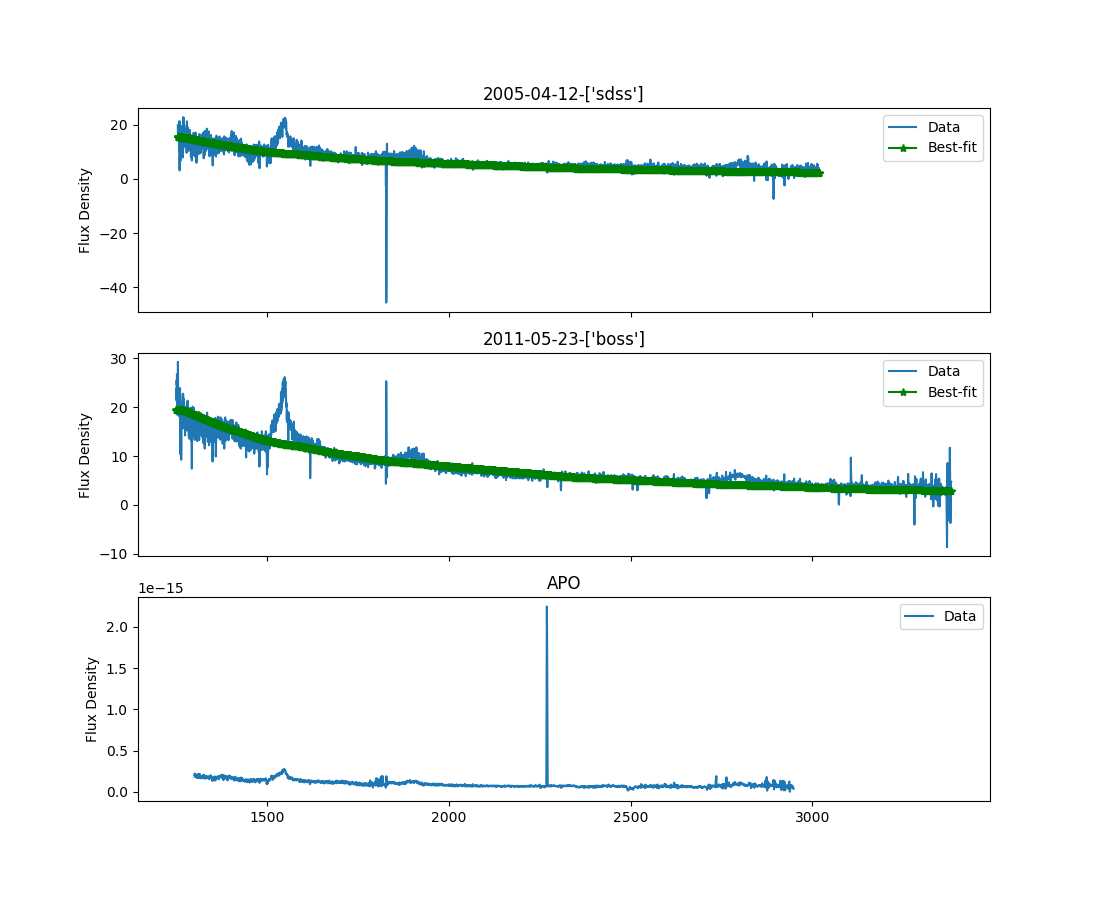

<IPython.core.display.Javascript object>


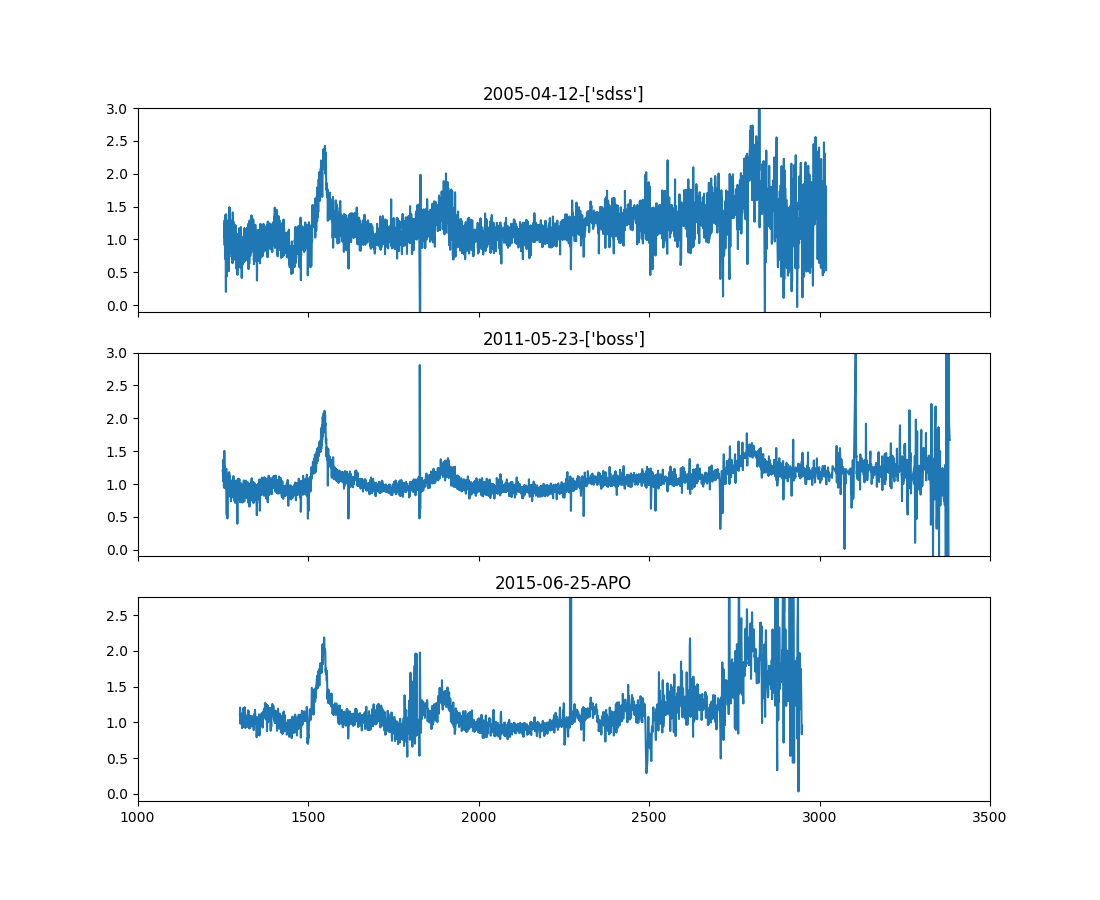

<IPython.core.display.Javascript object>


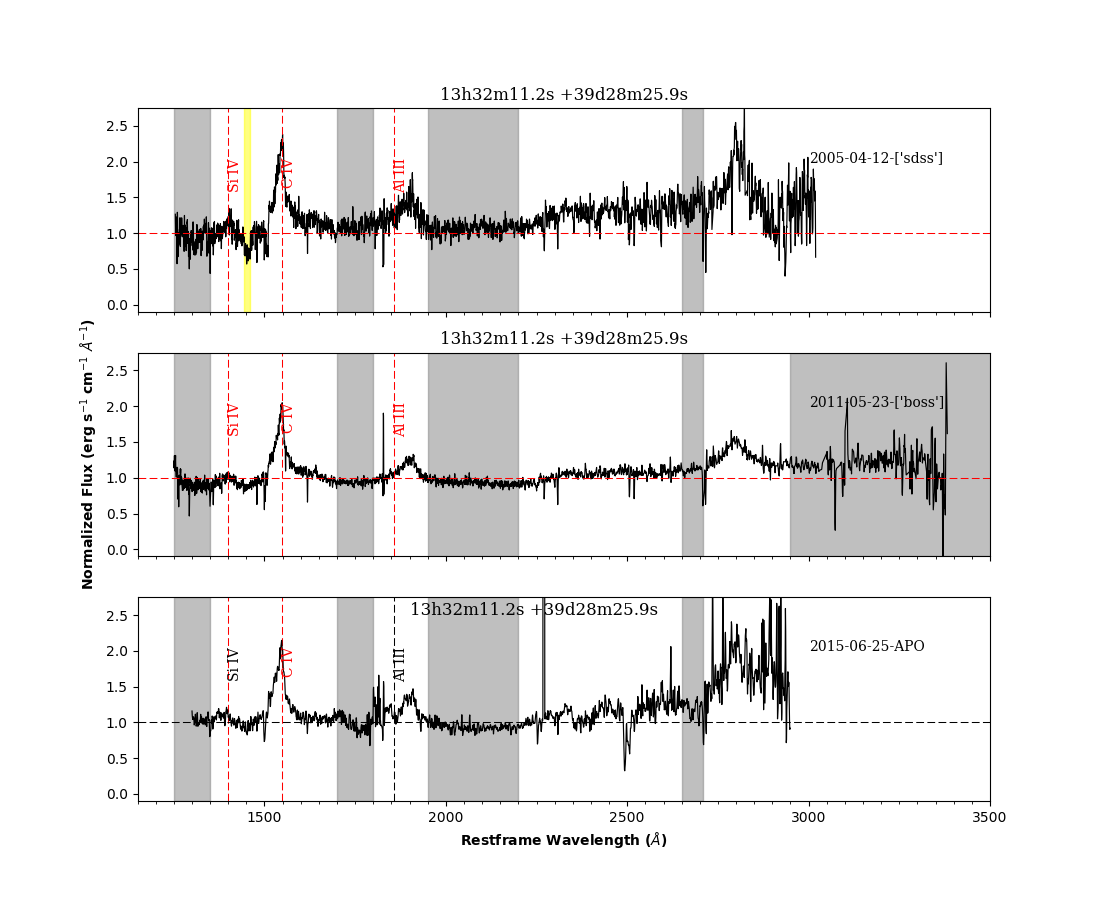

<IPython.core.display.Javascript object>


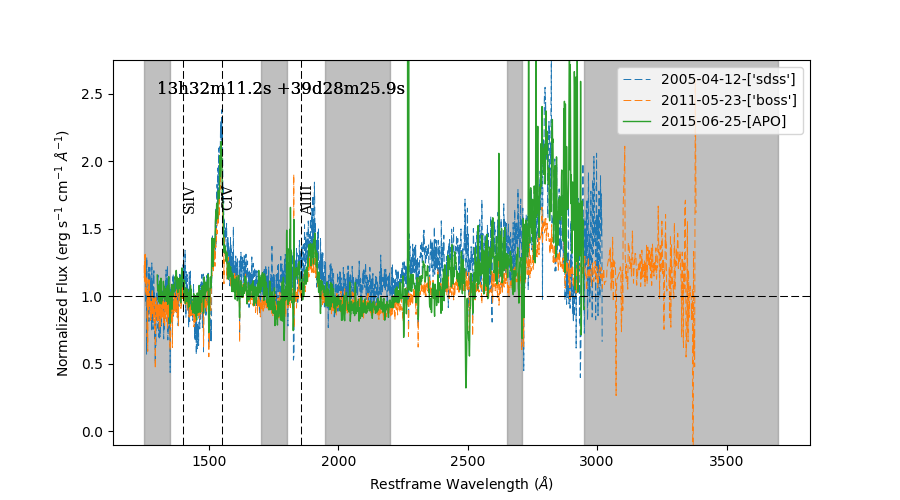

<IPython.core.display.Javascript object>


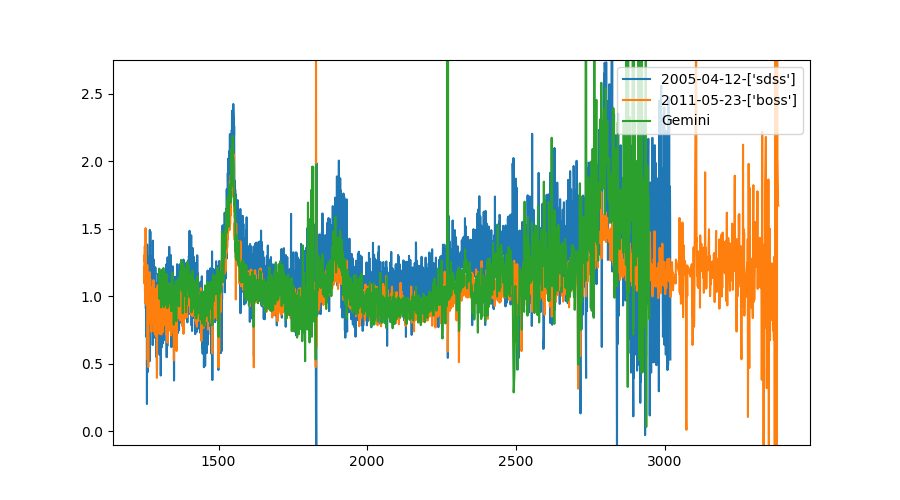

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[2146.1338901293248] [-0.89244029393605162] [1]
[2146.1338901293248, 2233.2633586661736] [-0.89244029393605162, -0.89762112469416921] [1, 1]
[2146.1338901293248, 2233.2633586661736, 2307.74292772234] [-0.89244029393605162, -0.89762112469416921, -0.9022051900788749] [1, 1, 1]
[2146.1338901293248, 2233.2633586661736, 2307.74292772234, 2439.1945667216987] [-0.89244029393605162, -0.89762112469416921, -0.9022051900788749, -0.90994608705378222] [1, 1, 1, 1]
[2146.1338901293248, 2233.2633586661736, 2307.74292772234, 2439.1945667216987, 2468.3144615039473] [-0.89244029393605162, -0.89762112469416921, -0.9022051900788749, -0.90994608705378222, -0.91160505569805839] [1, 1, 1, 1, 1]
[2146.1338901293248, 2233.2633586661736, 2307.74292772234, 2439.1945667216987, 2468.3144615039473, 2531.7912902605908] [-0.89244029393605162, -0.89762112469416921, -0.9022051900788749, -0.90994608705378222, -0.91160505569805839, -0.91515386693439638] [1, 1, 1, 1, 1, 1]
[2146.1338901293248, 2233.2633586661736, 2307.742

In [14]:
#source 6  --testing
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J133211.apo']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['13h32m11.2s +39d28m25.9s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-06-25']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0520]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0194] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            
            #deredden the flux
            if k/(1.0+p) > 1250:
                flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength
                wavl.append(k/(1.0+p))
                if lm == 0:
                    err.append(dered_flux(r,k,j)/100.0)
                else:
                    err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper

        if q==0:
            
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-.5*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+.5*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(3000,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].set_title(str(o), fontsize= 12, family='serif', color='black')
        
        
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
        print (str(o),param[5],param[6])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        
        if q==1:
            axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 and wav/(1.0+p)>1300 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,flux_err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1250 <= red_datum[xx][0] <= 1350):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))  
                
        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3700):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))  
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3700:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3700:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1                
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(3000,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1150,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

<IPython.core.display.Javascript object>


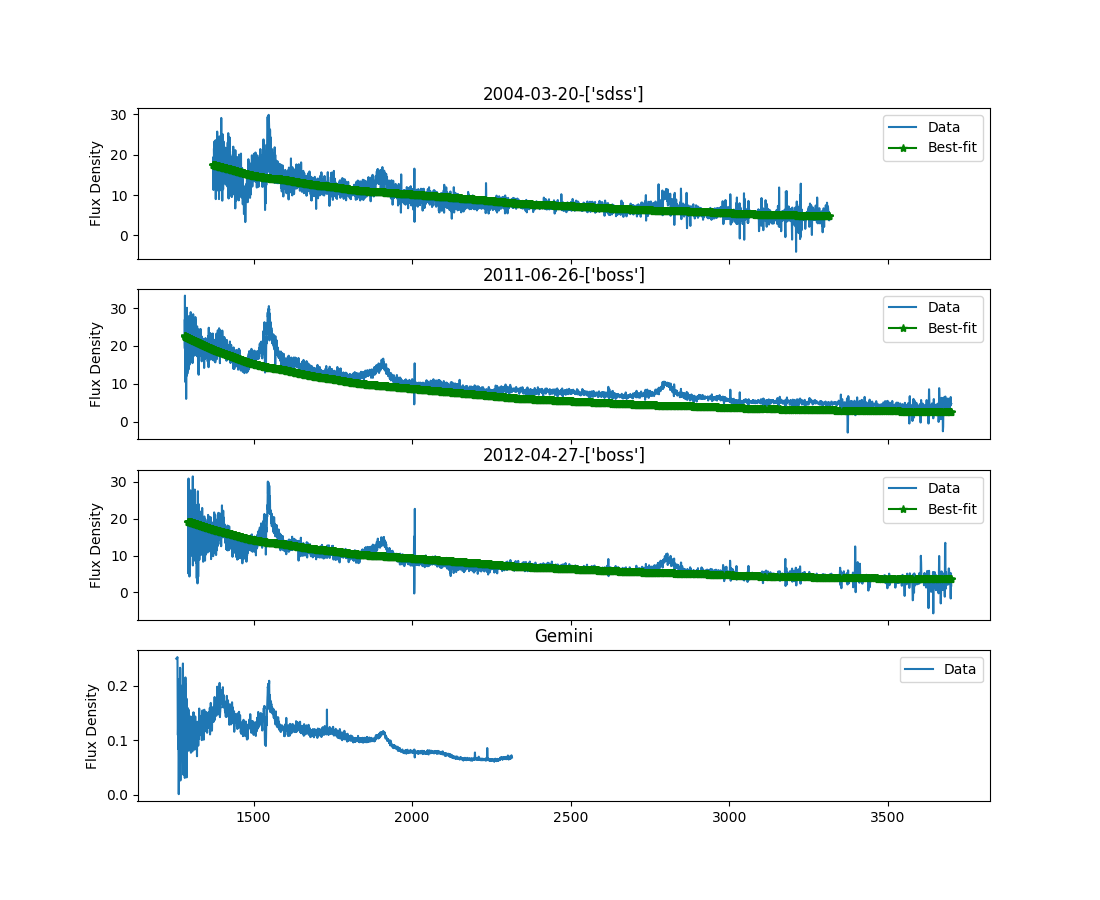

<IPython.core.display.Javascript object>


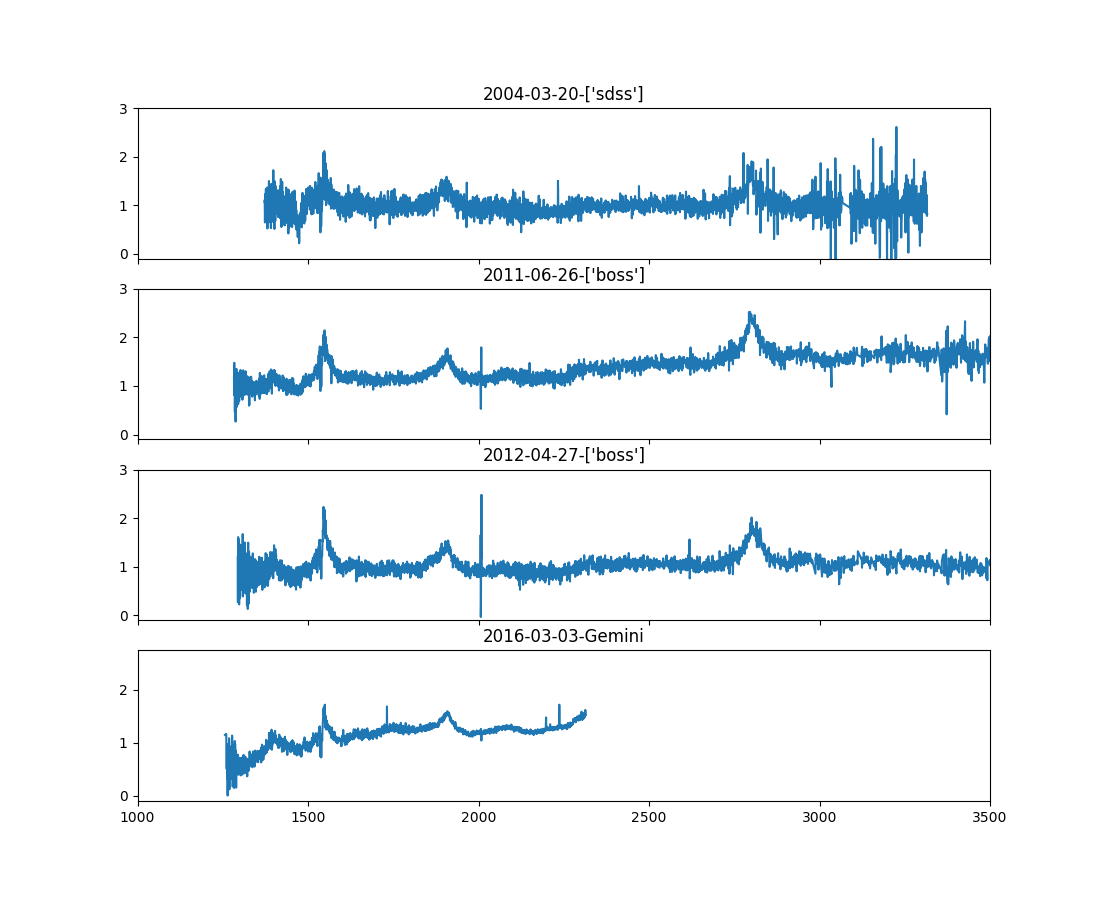

<IPython.core.display.Javascript object>


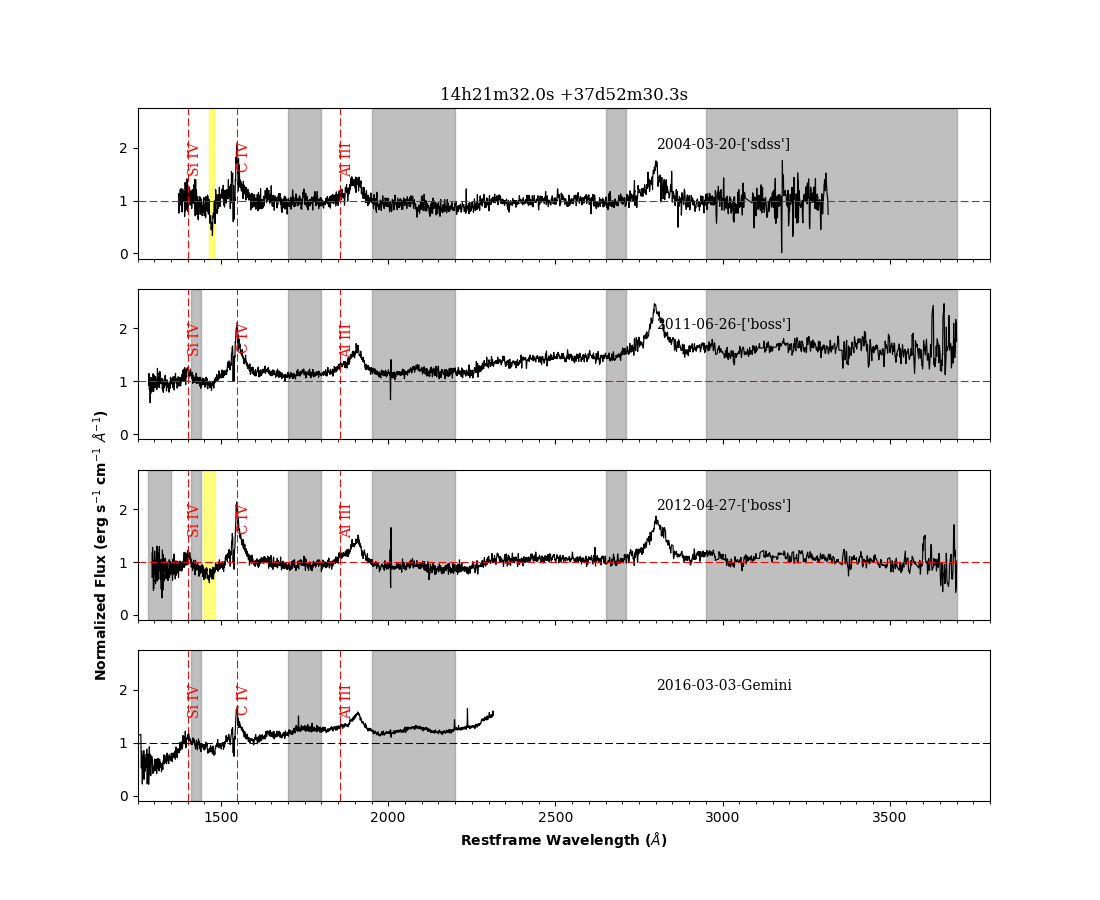

<IPython.core.display.Javascript object>


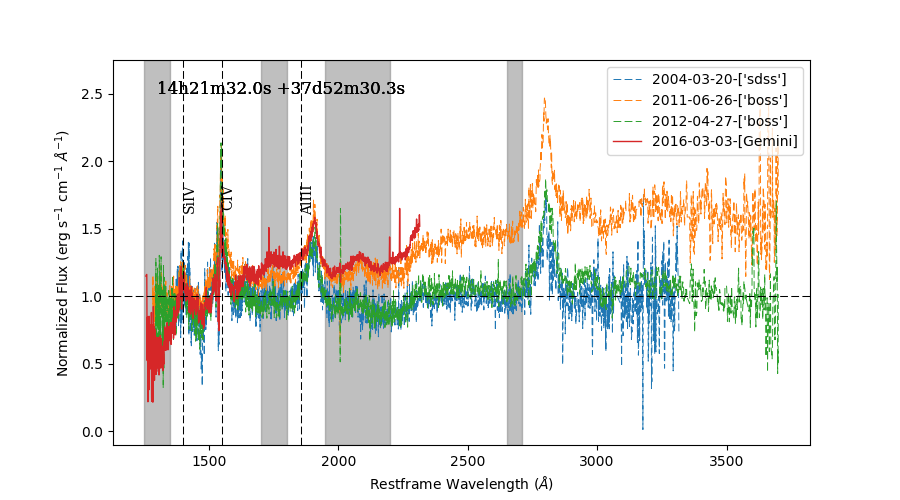

<IPython.core.display.Javascript object>


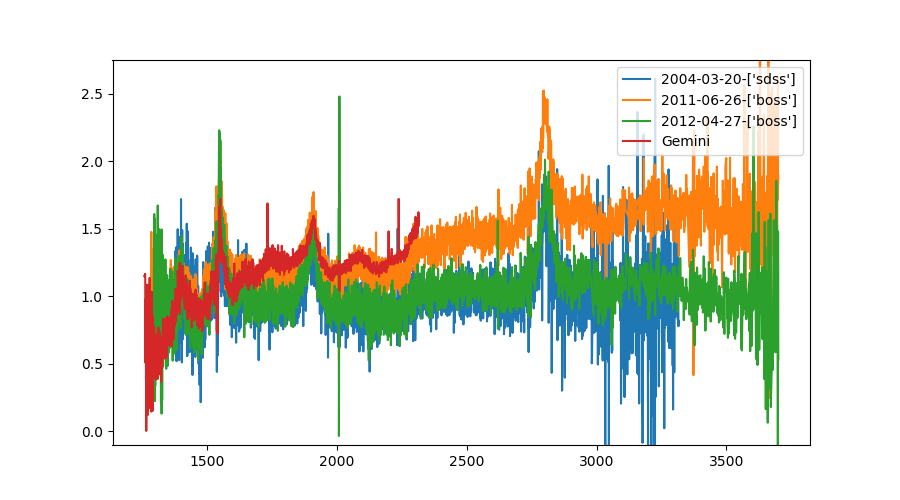

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[29.476008649622976] [-0.25303003546425706] [1]
[29.476008649622976, 29.588722339498705] [-0.25303003546425706, -0.25348852740829053] [1, 1]
[29.476008649622976, 29.588722339498705, 29.588724243817381] [-0.25303003546425706, -0.25348852740829053, -0.25348853562965079] [1, 1, 1]
[29.476008649622976, 29.588722339498705, 29.588724243817381, 29.588724243817381] [-0.25303003546425706, -0.25348852740829053, -0.25348853562965079, -0.25348853562965079] [1, 1, 1, 1]
14h21m32.0s +37d52m30.3s 1465.19663867 1479.0940567
[57878.348496296509] [-1.2950942606186155] [1]
[57878.348496296509, 93222.83663657571] [-1.2950942606186155, -1.3609531096220258] [1, 1]
[57878.348496296509, 93222.83663657571, 60253.060276366254] [-1.2950942606186155, -1.3609531096220258, -1.2995481032525136] [1, 1, 1]
[57878.348496296509, 93222.83663657571, 60253.060276366254, 36708.478470831717] [-1.2950942606186155, -1.3609531096220258, -1.2995481032525136, -1.2301688439769223] [1, 1, 1, 1]
[57878.348496296509, 93222.8366365757

In [10]:
#source 7 --USE THIS 18jAN, WORK ON 2 3 AND 4TH EPOCHS
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J142132.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['14h21m32.0s +37d52m30.3s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-03-03']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.7791]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0568] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            
            #deredden the flux
            if k/(1.0+p) > 1250 and k/(1.0+p) < 3700:
                flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength
                wavl.append(k/(1.0+p))
                if lm == 0:
                    err.append(dered_flux(r,k,j)/100.0)
                else:
                    err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        if q==0 :
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

#                 k=[]
#                 nombr=0
#                 wt=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1250 <= z <= 1350:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)

#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1250 <= z <= 1350:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1

                        
        elif q==1 :
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 


        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)


                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 


        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-8*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+8*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)


                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2800,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 12, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
        print (str(o),param[5],param[6])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        
            
        
        if q==1:
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
        elif q==2:
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1280, 1350, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()

        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1410 <= red_datum[xx][0] <= 1440):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


#         ct=[]
#         for xx in range(len(datum)):
#             if (2650 <= datum[xx][0] <=2710) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2650 <= red_datum[xx][0] <= 2710):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y))) 

#         ct=[]
#         for xx in range(len(datum)):
#             if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2950 <= red_datum[xx][0] <= 3200):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y))) 

#         ct=[]
#         for xx in range(len(datum)):
#             if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                 red_datum.append(datum[xx])
#                 ct.append(datum[xx])

#         for xx in range(len(red_datum)):
#             if (2950 <= red_datum[xx][0] <= 3700):
#                 y=np.asarray(red_datum)
#                 y[xx][3]=(len(ct))**0.5
#                 red_datum=list(tuple(map(tuple, y))) 



        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1410 <= z <= 1440:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1410 <= z <= 1440:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0
            
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2650 <= z <= 2710:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2650 <= z <= 2710:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2650 <= z <= 2710:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2650 <= z <= 2710:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 2950 <= z <= 3200:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 2950 <= z <= 3200:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)



            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(2800,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2800,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1250,3800)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        #param=civ_param(p,wavl,smoothed_signal)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        axarr2[len(sp)].axvspan(1410, 1440, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    #axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

In [42]:

#source 7 ,modifying source 9's - done solved-use above one!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J142132.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['14h21m32.0s +37d52m30.3s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2016-03-03']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[1.7791]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.0568] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
#             if q==0:
#                 if k/(1.0+p)>1275:
#                     flux.append(dered_flux(r,k,j))
#                 #translate observed to rest wavelength

#                     wavl.append(k/(1.0+p))
#         #             if lm == 0:
#         #                 err.append(dered_flux(r,k,j)/100.0)
#         #             else:
#                     err.append(lm)
#             else:
            flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength

            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper

        if q==0:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1

        
        elif q==1:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-8*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+8*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(1100,3900)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(1300,2.5,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\t'+str(y[2])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2.0*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2.0*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal)
        axarr2[len(sp)].set_xlim(1100,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        
        param=civ_param(p,wavl,smoothed_signal)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.png', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:149: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[216.02104532390476] [-0.52375286830647316] [1]
[216.02104532390476, 187.76811545977904] [-0.52375286830647316, -0.50535141020126417] [1, 1]
[216.02104532390476, 187.76811545977904, 191.46071429093638] [-0.52375286830647316, -0.50535141020126417, -0.50804057538744263] [1, 1, 1]
[216.02104532390476, 187.76811545977904, 191.46071429093638, 191.46031146768294] [-0.52375286830647316, -0.50535141020126417, -0.50804057538744263, -0.5080402867422521] [1, 1, 1, 1]
[216.02104532390476, 187.76811545977904, 191.46071429093638, 191.46031146768294, 191.4604523989405] [-0.52375286830647316, -0.50535141020126417, -0.50804057538744263, -0.5080402867422521, -0.50804038773131499] [1, 1, 1, 1, 1]
[216.02104532390476, 187.76811545977904, 191.46071429093638, 191.46031146768294, 191.4604523989405, 191.4604523989405] [-0.52375286830647316, -0.50535141020126417, -0.50804057538744263, -0.5080402867422521, -0.50804038773131499, -0.50804038773131499] [1, 1, 1, 1, 1, 1]
[87225.974808978208] [-1.3525086132542121] 

In [ ]:
  while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
    #             k=[]
    #             for z,y in zip(wavl,range(len(wavl))):
    #                 if 1250 <= z <= 1350:
    #                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
    #                 dev=np.std(k)
    #             for z,y in zip(wavl,range(len(wavl))):     
    #                 if 1250 <= z <= 1350:
    #                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
    #                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

    #                         fluxar.append(flux[y])
    #                         wavlar.append(wavl[y])
    #                         errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1

In [52]:
#source 8 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J152149.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['15h21m49.8s +01d02m36.4s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-04-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.2386]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1592] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            
            flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        while m<len(datum):
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
            #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
            if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                red_datum.append(datum[m])
            m=m+1
        # obtaining fit parameters    
        #print (red_datum)
        
        #x=pow_fita(red_datum,amp,index)
        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        if q==1 or q==0:
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1250 <= z <= 1350:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1250 <= z <= 1350:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
        else:
              while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-4*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl,smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2650,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'AlIII',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        #axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) and datum[i][1]>0:
            if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]
#             k=[]
#             for z,y in zip(wavl,range(len(wavl))):
#                 if 1250 <= z <= 1350:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 1250 <= z <= 1350:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        
            k=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-2*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
            
            
            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
            
            else: 
                fittar=list(zip(wavlar,fluxar,errar))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])
        
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0001:
                    xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(2650,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2650,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1100,3250)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        #param=civ_param(p,wavl,smoothed_signal)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[175.35042858504619] [-0.53016775035163966] [1]
[175.35042858504619, 175.70183778328325] [-0.53016775035163966, -0.53043818281945709] [1, 1]
[175.35042858504619, 175.70183778328325, 175.70188950740751] [-0.53016775035163966, -0.53043818281945709, -0.53043822190217671] [1, 1, 1]
[175.35042858504619, 175.70183778328325, 175.70188950740751, 175.70188950740751] [-0.53016775035163966, -0.53043818281945709, -0.53043822190217671, -0.53043822190217671] [1, 1, 1, 1]
[66.138976943545643] [-0.31670199595817206] [1]
[66.138976943545643, 68.420417463865761] [-0.31670199595817206, -0.32095729867186418] [1, 1]
[66.138976943545643, 68.420417463865761, 68.246890177753002] [-0.31670199595817206, -0.32095729867186418, -0.32061328486061363] [1, 1, 1]
[66.138976943545643, 68.420417463865761, 68.246890177753002, 68.246841296367819] [-0.31670199595817206, -0.32095729867186418, -0.32061328486061363, -0.32061318972770986] [1, 1, 1, 1]
[65242.864253962907] [-1.2252973690363727] [1]
[65242.864253962907, 30109.26

<IPython.core.display.Javascript object>


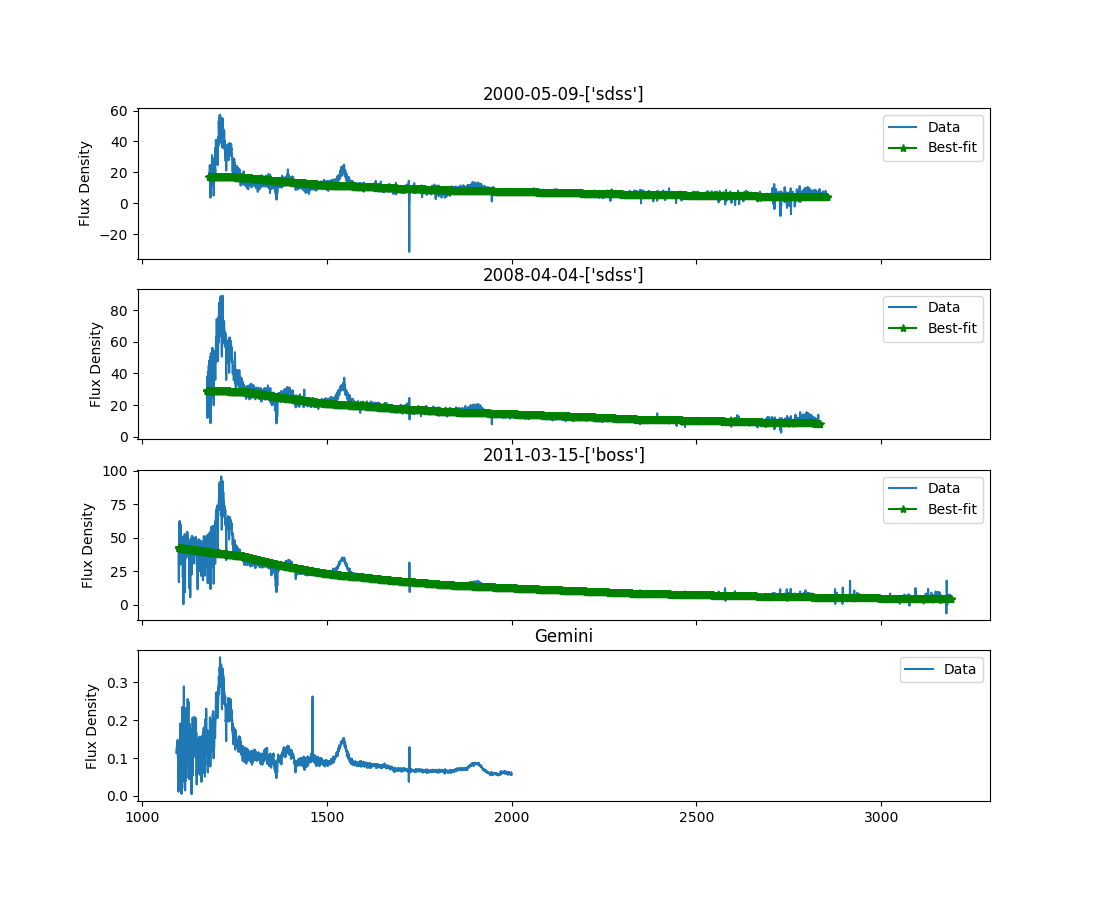

<IPython.core.display.Javascript object>


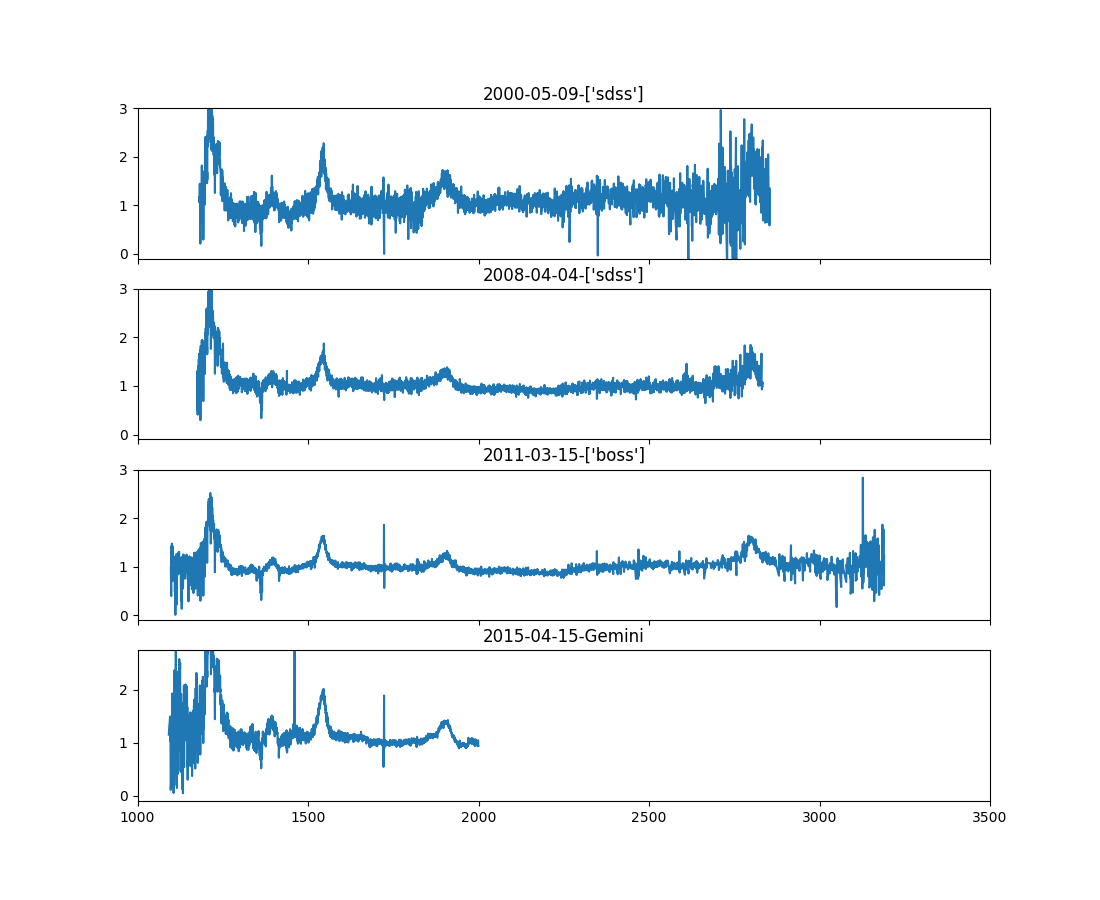

<IPython.core.display.Javascript object>


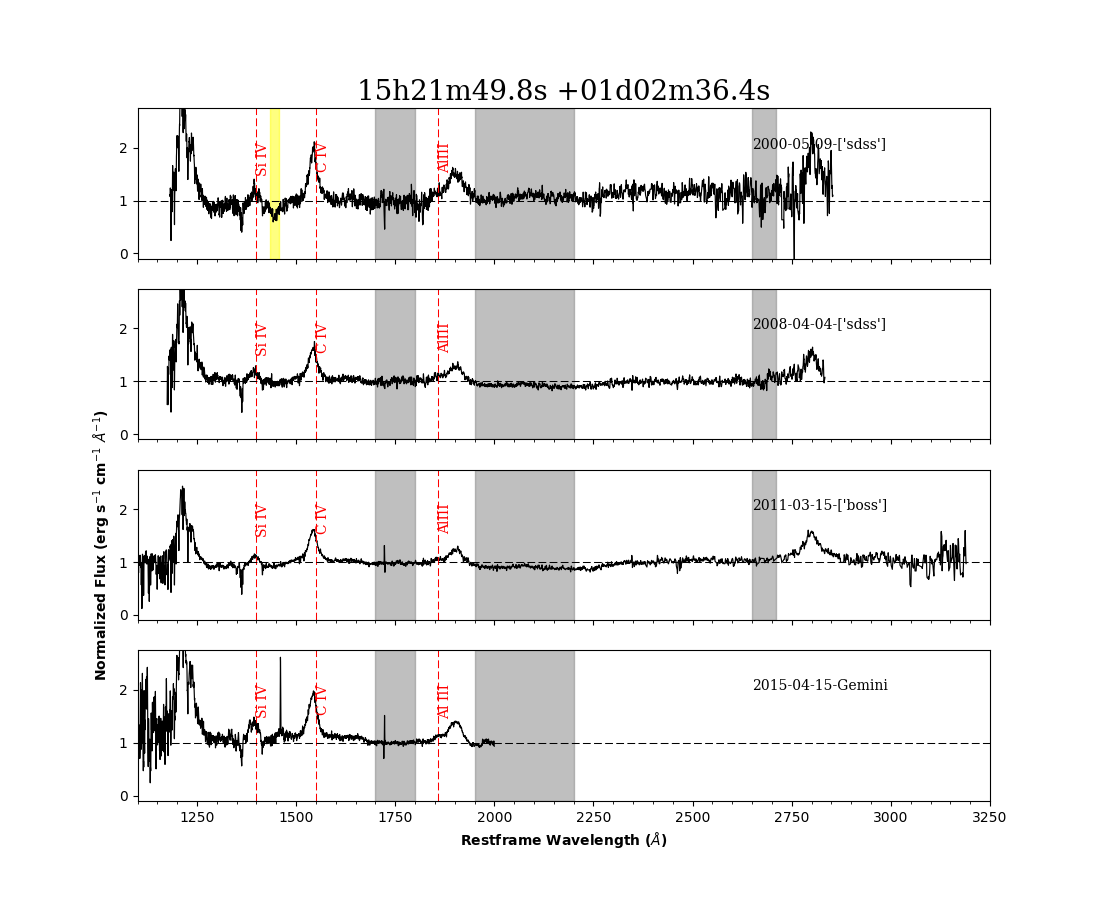

<IPython.core.display.Javascript object>


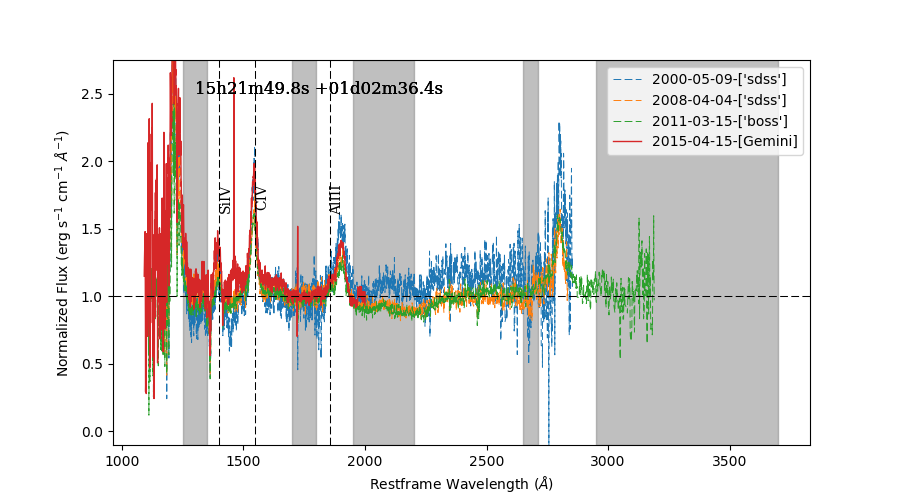

<IPython.core.display.Javascript object>


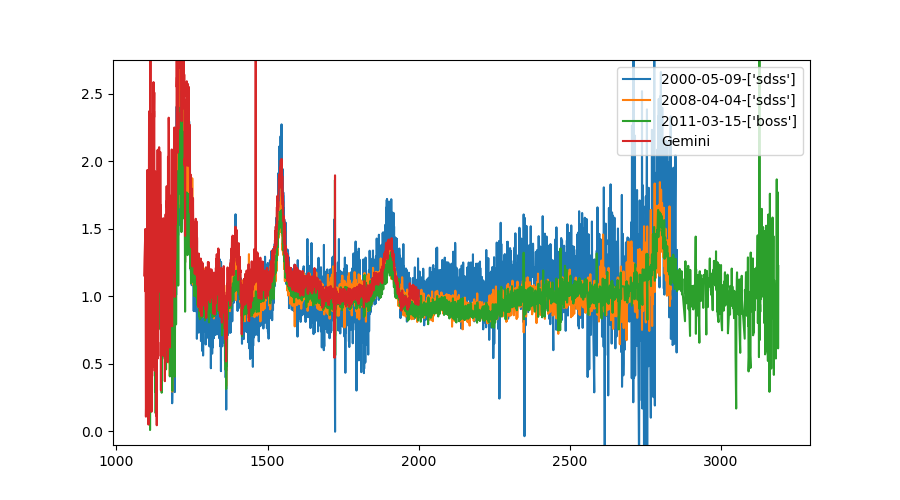

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[192.6017792089263] [-0.54278511589392375] [1]
[192.6017792089263, 193.46643650971825] [-0.54278511589392375, -0.54339519546199766] [1, 1]
[192.6017792089263, 193.46643650971825, 193.46643650971825] [-0.54278511589392375, -0.54339519546199766, -0.54339519546199766] [1, 1, 1]
[192.6017792089263, 193.46643650971825, 193.46643650971825, 193.46643650971825] [-0.54278511589392375, -0.54339519546199766, -0.54339519546199766, -0.54339519546199766] [1, 1, 1, 1]
[49.708345300225574] [-0.2776402087250503] [1]
[49.708345300225574, 49.698228772821139] [-0.2776402087250503, -0.27761079098422575] [1, 1]
[49.708345300225574, 49.698228772821139, 49.698224810425359] [-0.2776402087250503, -0.27761079098422575, -0.27761078048936921] [1, 1, 1]
[49.708345300225574, 49.698228772821139, 49.698224810425359, 49.698224810425359] [-0.2776402087250503, -0.27761079098422575, -0.27761078048936921, -0.27761078048936921] [1, 1, 1, 1]
[21253.290681254846] [-1.0912322719563345] [1]
[21253.290681254846, 25418.6770778067

In [11]:
#source 8 --testing..

#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J152149.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['15h21m49.8s +01d02m36.4s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-04-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.2386]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1592] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            
            flux.append(dered_flux(r,k,j))
        #translate observed to rest wavelength
            wavl.append(k/(1.0+p))
            if lm == 0:
                err.append(dered_flux(r,k,j)/100.0)
            else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        if q==1 or q==0:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2500) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2500):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

#                 k=[]
#                 nombr=0
#                 wt=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1250 <= z <= 1350:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)

#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1250 <= z <= 1350:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-1*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+1*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2500:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2500:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            red_datum=[]
            numr=[1] * len(wavl)
            datum=list(zip(wavl,flux,err,numr))

            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

                    
            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0
                
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl,smoothed_signal,color='black',linewidth=0.85)
             
        #axarr2[q].set_xlim(800,3000)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2650,2.0,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'AlIII',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        
        #axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
        axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()

        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))



#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 


        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

#             k=[]
#             nombr=0

#             for z,y in zip(wavl,range(len(wavl))):
#                 if 1700 <= z <= 1800:
#                     k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                     nombr=nombr+1
#                 dev=np.std(k)
#             for z,y in zip(wavl,range(len(wavl))):     
#                 if 1700 <= z <= 1800:
#                     #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                     if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

#                         fluxar.append(flux[y])
#                         wavlar.append(wavl[y])
#                         errar.append(err[y])
#                         wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-2*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+2*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)


            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1

                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(2650,2.0,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2650,2.0,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1100,3250)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        #param=civ_param(p,wavl,smoothed_signal)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
#         axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

In [54]:
#source 9 
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J152244.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['15h22m44.0s +03d27m19.8s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-04-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0002]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1418] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            if q==0:
                if k/(1.0+p)>1275:
                    flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength

                    wavl.append(k/(1.0+p))
        #             if lm == 0:
        #                 err.append(dered_flux(r,k,j)/100.0)
        #             else:
                    err.append(lm)
            else:
                flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength

                wavl.append(k/(1.0+p))
    #             if lm == 0:
    #                 err.append(dered_flux(r,k,j)/100.0)
    #             else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==0:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                if (1250 <= datum[m][0] <= 1350) | (1410 <= datum[m][0] <= 1440) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) :
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:
                        

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3200:
#                         k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3200:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
        else:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                if (1250 <= datum[m][0] <= 1350) | (1410 <= datum[m][0] <= 1440) |(1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
            
            
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
             
        axarr2[q].set_xlim(1100,3900)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(2750,2.1,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[q].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        axarr2[0].set_title(str(o), fontsize= 20, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(param[5], param[6], alpha=0.5, color='yellow')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(2750,2.1,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(2750,2.1,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1549,1.9,r'C IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1400,1.9,r'Si IV',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='red')
        axarr2[len(sp)].text(1857,1.9,r'Al III',rotation=90,fontsize= 10, family='serif', color='red')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='red')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal,color='black',linewidth=0.85)
        axarr2[len(sp)].set_xlim(1100,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        #axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)',fontsize=10,fontweight='bold')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)',fontsize=10,fontweight='bold')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.pdf', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:149: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[90.848262880509651] [-0.40890511440818927] [1]
[90.848262880509651, 89.954706186069586] [-0.40890511440818927, -0.40768142455358147] [1, 1]
[90.848262880509651, 89.954706186069586, 90.238512984603062] [-0.40890511440818927, -0.40768142455358147, -0.40812153759473285] [1, 1, 1]
[90.848262880509651, 89.954706186069586, 90.238512984603062, 90.240073902434844] [-0.40890511440818927, -0.40768142455358147, -0.40812153759473285, -0.40812325697012031] [1, 1, 1, 1]
[90.848262880509651, 89.954706186069586, 90.238512984603062, 90.240073902434844, 90.240073902434844] [-0.40890511440818927, -0.40768142455358147, -0.40812153759473285, -0.40812325697012031, -0.40812325697012031] [1, 1, 1, 1, 1]
[0.19041356090284248] [0.38085450942288462] [1]
[0.19041356090284248, 0.18847769924055105] [0.38085450942288462, 0.38192018464430155] [1, 1]
[0.19041356090284248, 0.18847769924055105, 0.19070763331693827] [0.38085450942288462, 0.38192018464430155, 0.3800649233707421] [1, 1, 1]
[0.19041356090284248, 0.18847769

In [145]:
while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:
                        

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1

In [12]:
#source 9  -testing! - seems fine
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J152244.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['15h22m44.0s +03d27m19.8s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-04-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0002]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1418] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            if q==0:
                if k/(1.0+p)>1275:
                    flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength

                    wavl.append(k/(1.0+p))
        #             if lm == 0:
        #                 err.append(dered_flux(r,k,j)/100.0)
        #             else:
                    err.append(lm)
            else:
                flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength

                wavl.append(k/(1.0+p))
    #             if lm == 0:
    #                 err.append(dered_flux(r,k,j)/100.0)
    #             else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        datum=list(zip(wavl,flux,err))
        m=0
        if q==0:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                #if (1250 <= datum[m][0] <= 1350) | (1410 <= datum[m][0] <= 1440) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) :
                if (1250 <= datum[m][0] <= 1350) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) :
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3200) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
        
        
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1410 <= z <= 1440:
#                         k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1410 <= z <= 1440:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1700 <= z <= 1800:
#                         k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1700 <= z <= 1800:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:
                        

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

#                 k=[]
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3200:
#                         k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3200:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
        else:
            while m<len(datum):
                #if (1250 <= datum[m][0] <= 1350) | (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) | (3950 <= datum[m][0] <= 4050) and datum[m][1]>0:
                if (1250 <= datum[m][0] <= 1350) | (1410 <= datum[m][0] <= 1440) |(1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                #if (1700 <= datum[m][0] <= 1800) | (1950 <= datum[m][0] <= 2200) | (2650 <= datum[m][0] <= 2710) | (2950 <= datum[m][0] <= 3700) and datum[m][1]>0:
                    red_datum.append(datum[m])
                m=m+1
            # obtaining fit parameters    
            #print (red_datum)

            #x=pow_fita(red_datum,amp,index)

            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
            
            
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal)
             
        axarr2[q].set_xlim(1100,3900)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(1300,2.5,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal)
#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        datum=list(zip(wavl,flux,flux_err))
        i=0
        while i<len(datum):
            #if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3700) | (3950 <= datum[i][0] <= 4050 and datum[i][1]>0):
            if (1250 <= datum[i][0] <= 1350) | (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            #if (1700 <= datum[i][0] <= 1800) | (1950 <= datum[i][0] <= 2200) | (2650 <= datum[i][0] <= 2710) | (2950 <= datum[i][0] <= 3200) and datum[i][1]>0:
            
                red_datum.append(datum[i])
            i=i+1
       
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]
                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])

                k=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3200:
                        k.append(abs(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1]))))
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-0.75*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+0.75*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])


                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.0000001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.0000001:
                        xm=1
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal)
        axarr2[len(sp)].set_xlim(1100,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        
        param=civ_param(p,wavl,smoothed_signal)
        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try: 
            y=civ_param(p,wavl,smoothed_signal)
            #y=civ_param(wavl,normalized)
            fpar.write(str(o)+'\t'+str(dt)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[3])+'\t'+str(y[2])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(dt)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.png', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:149: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[158.34642152643067] [-0.48649050297635782] [1]
[158.34642152643067, 177.72263998059771] [-0.48649050297635782, -0.50275135178090857] [1, 1]
[158.34642152643067, 177.72263998059771, 179.66385710600699] [-0.48649050297635782, -0.50275135178090857, -0.50426713553790026] [1, 1, 1]
[158.34642152643067, 177.72263998059771, 179.66385710600699, 179.66385710600699] [-0.48649050297635782, -0.50275135178090857, -0.50426713553790026, -0.50426713553790026] [1, 1, 1, 1]
[0.19041356090284248] [0.38085450942288462] [1]
[0.19041356090284248, 0.18847769924055105] [0.38085450942288462, 0.38192018464430155] [1, 1]
[0.19041356090284248, 0.18847769924055105, 0.19070763331693827] [0.38085450942288462, 0.38192018464430155, 0.3800649233707421] [1, 1, 1]
[0.19041356090284248, 0.18847769924055105, 0.19070763331693827, 0.18997436627391148] [0.38085450942288462, 0.38192018464430155, 0.3800649233707421, 0.38040352514486825] [1, 1, 1, 1]
[0.19041356090284248, 0.18847769924055105, 0.19070763331693827, 0.189974366273

<IPython.core.display.Javascript object>


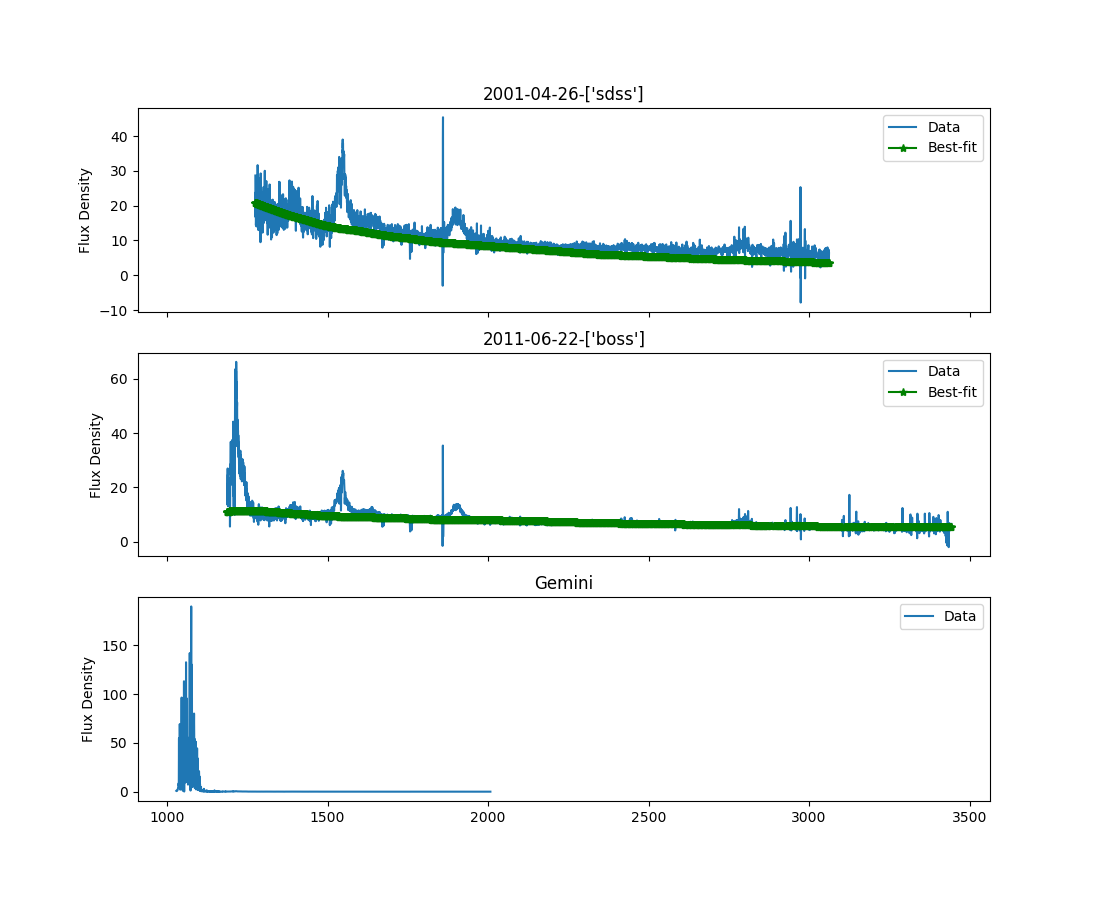

<IPython.core.display.Javascript object>


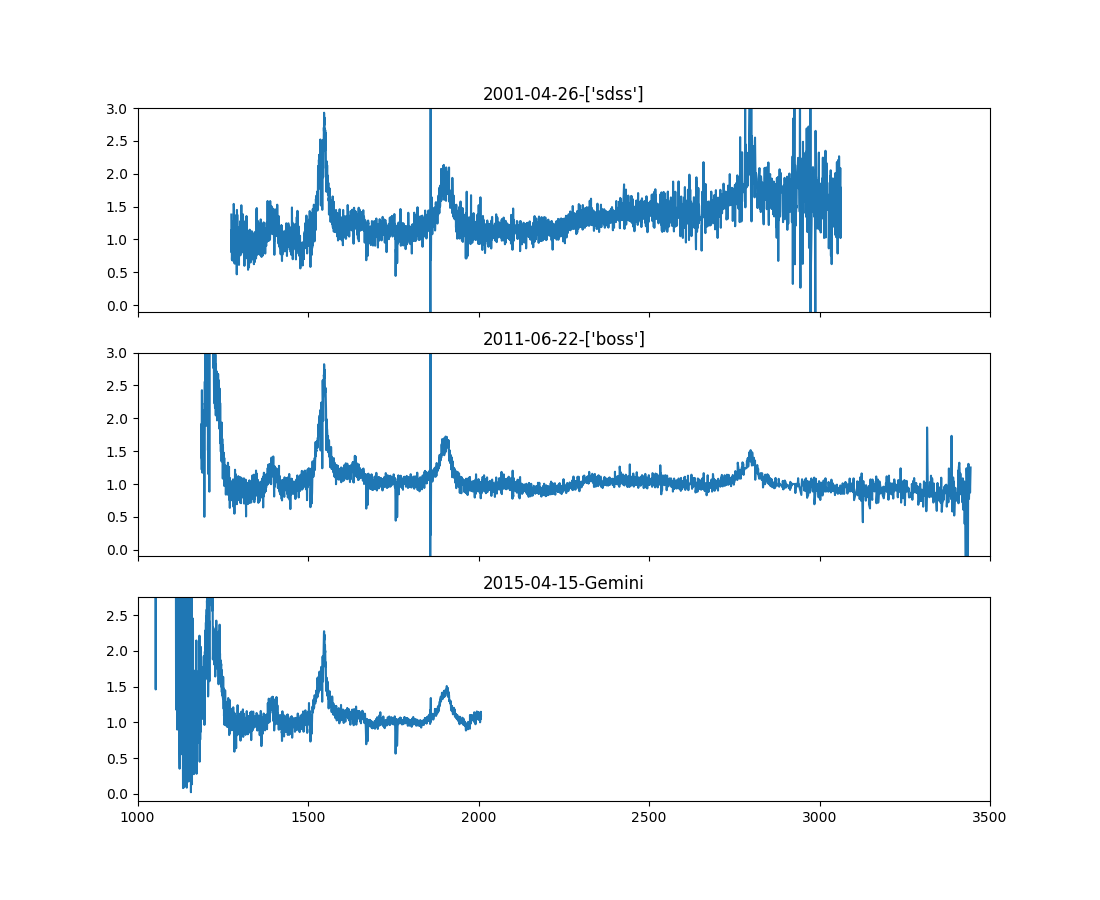

<IPython.core.display.Javascript object>


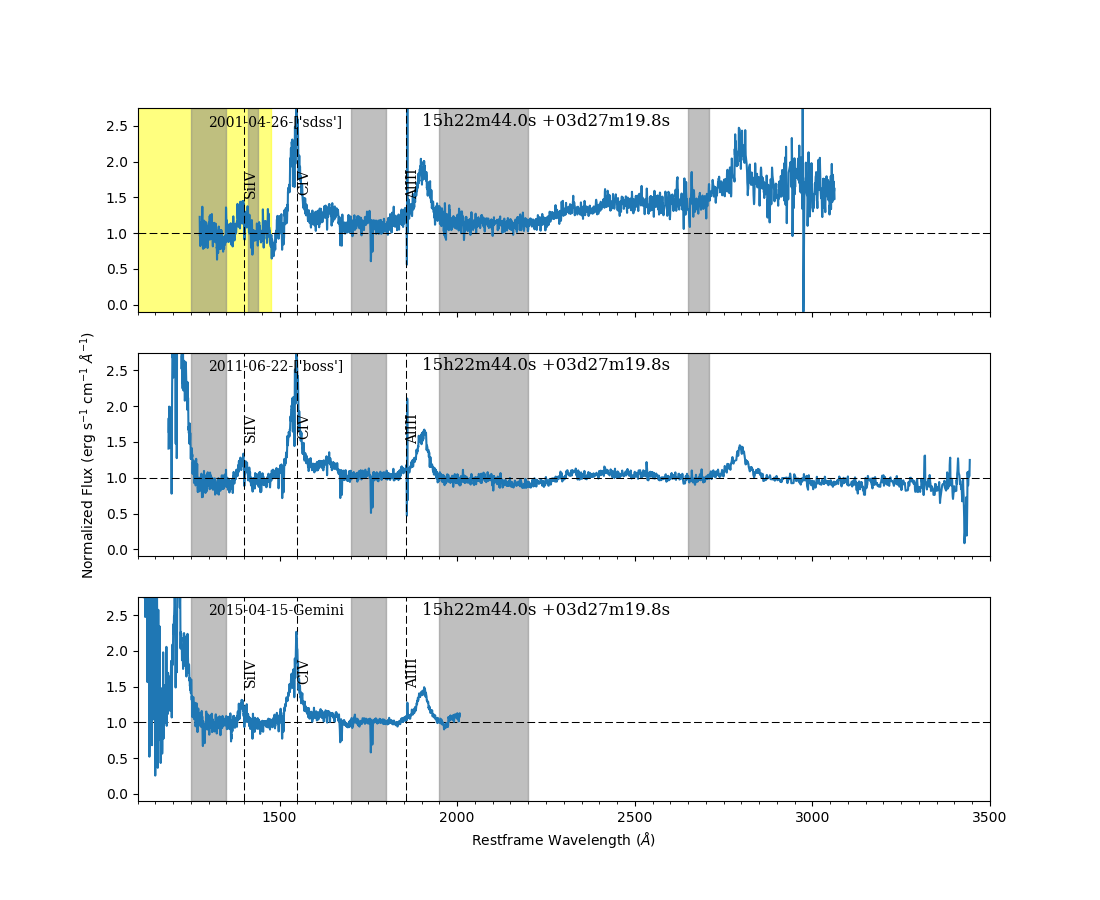

<IPython.core.display.Javascript object>


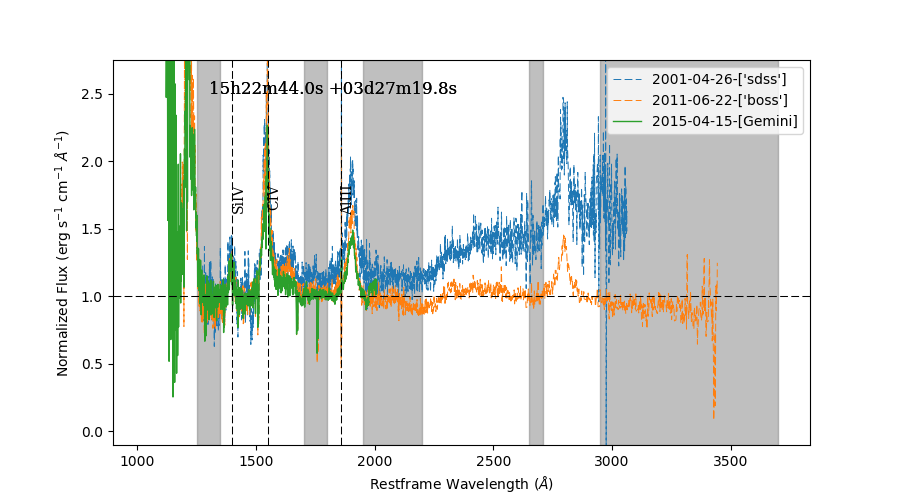

<IPython.core.display.Javascript object>


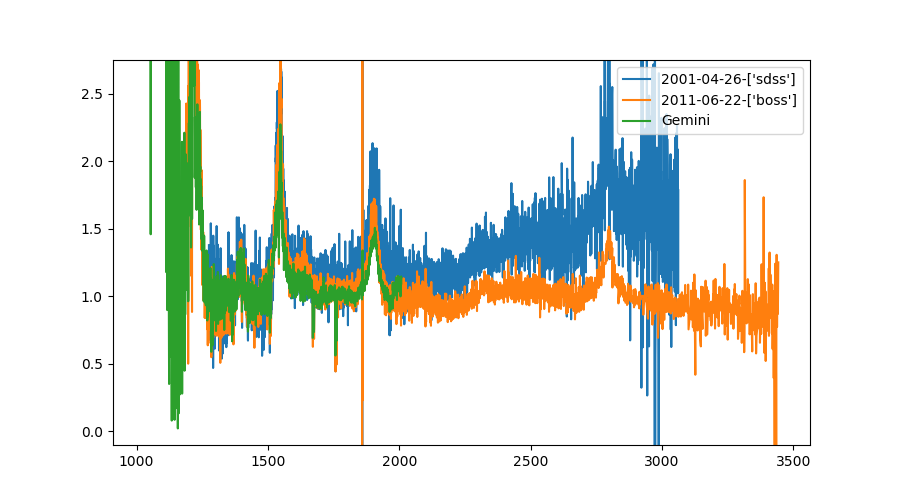

/home/sameer/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:149: RuntimeWarning: divide by zero encountered in log
/home/sameer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[775.35435570169011] [-0.70521381767010916] [1]
[775.35435570169011, 971.6306309061589] [-0.70521381767010916, -0.73670016566893992] [1, 1]
[775.35435570169011, 971.6306309061589, 1019.9811173469693] [-0.70521381767010916, -0.73670016566893992, -0.74347632133894759] [1, 1, 1]
[775.35435570169011, 971.6306309061589, 1019.9811173469693, 1049.3469855020389] [-0.70521381767010916, -0.73670016566893992, -0.74347632133894759, -0.74743846213613063] [1, 1, 1, 1]
[775.35435570169011, 971.6306309061589, 1019.9811173469693, 1049.3469855020389, 1067.4533139188175] [-0.70521381767010916, -0.73670016566893992, -0.74347632133894759, -0.74743846213613063, -0.74982501982995686] [1, 1, 1, 1, 1]
[775.35435570169011, 971.6306309061589, 1019.9811173469693, 1049.3469855020389, 1067.4533139188175, 1067.8918865875048] [-0.70521381767010916, -0.73670016566893992, -0.74347632133894759, -0.74743846213613063, -0.74982501982995686, -0.74988098579586671] [1, 1, 1, 1, 1, 1]
[775.35435570169011, 971.6306309061589, 10

In [17]:
#source 9  -testing! - seems fine--TESTING!
#f1_array=[None,'J074650.gem','J085904.gem','J093620.gem','J114546.gem','J133211.apo','J142132.gem','J152149.gem','J152244.gem']
f1_array=['J152244.gem']

#f1_array=['J152244.gem']
#coordinates of objects of interest
#name_array=['00h40m22.4s +00d59m39.6s','07h46m50.6s +18d20m28.7s','08h59m04.6s +04d26m47.8s','09h36m20.5s +00d46m49.2s','11h45m46.2s +03d22m51.9s','13h32m11.2s +39d28m25.9s','14h21m32.0s +37d52m30.3s','15h21m49.8s +01d02m36.4s','15h22m44.0s +03d27m19.8s']
name_array=['15h22m44.0s +03d27m19.8s']
#name_array=['15h22m44.0s +03d27m19.8s']
#dates=['No obs.','2016-02-08','2016-02-11','2015-11-15','2016-03-15','2015-06-25','2016-03-03','2015-04-15','2015-04-15']
dates=['2015-04-15']
#dates=['2015-04-15']

#redshifts of objects of interest
#z_array=[2.5650,1.9163,1.8104,1.7213,2.0075,2.0520,1.7791,2.2386,2.0002]
z_array=[2.0002]
#z_array=[2.0002]

#Av in the direction of objects of interest
#Av_array=[0.0570,1,0.1036,0.1595,0.0610,0.0167,0.0489,0.1369,0.122] #s&f-2011
#Av_array=[0.0663,0.1162,0.1204,0.1855,0.0709,0.0194,0.0568,0.1592,0.1418] #sfd-1998
Av_array=[0.1418] #sfd-1998

#Av_array=[0.122]0.0194
fpar=open('civparams'+str(name_array)+'.txt','w')
for n,o,p,r,dt in zip(f1_array,name_array,z_array,Av_array,dates):
    
    from astropy.table import Table
    from astropy.io import fits
    from astropy import units as u
    from specutils import extinction
    from astroquery.sdss import SDSS
    from astropy import coordinates as coords
    from astropy.time import Time
    from astropy.io import fits
    from pylab import *
    import matplotlib.pyplot as plt
    import powerlaw
    from scipy import optimize
    from outliers import smirnov_grubbs as grubbs
    from astropy.convolution import convolve, Box1DKernel
    from astropy.table import Table
    from sherpa.data import Data1D
    from sherpa.models import PowLaw1D
    from sherpa.stats import Chi2DataVar
    from sherpa.optmethods import LevMar
    from sherpa.fit import Fit
    from scipy import integrate
    from scipy.signal import savgol_filter
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    minorLocator = MultipleLocator(50)
    
    #hdulist = fits.open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/Optical_Patrick_Nabeel/spec-4222-55444-0692.fits')
    
    pos = coords.SkyCoord(o, frame='icrs')   
    xid = SDSS.query_region(pos, spectro=True)
    sp = SDSS.get_spectra(matches=xid)
    
#     if o == "00h40m22.4s +00d59m39.6s":
#         sp.append(hdulist)
#         print (len(sp))
    
    z=p
    Av=r
    plt.close('all') # close any existing plot memory

    # defining plot dimensions equal to the (number of id's present + 1(for gemini data)) 
    if o=="00h40m22.4s +00d59m39.6s":
        
        f, axarr = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp),1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
    else:
        f, axarr = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))     
        f2, axarr1 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f_bin, axarr2 = plt.subplots(len(sp)+1,1,sharex=True,figsize=(11,9))
        f3, axarr3 = plt.subplots(1, 1,figsize=(9,5))
        f4, axarr4 = plt.subplots(1, 1,figsize=(9,5))
        
    # reading the .gem file for gemini data of corresponding source as in array n
    
        
    h=[]
    i=0
    S=[]*(len(sp)-1)
    while i < len(sp):
        S.append(sp[i][3].data.field(1)[0])
        
        i=i+1
    
    y=np.arange(len(sp))
    zippa=zip(y,S)
    sorteda=sorted(zippa,key=lambda x: x[1]) 
    
        
    for q in range(len(sorteda)):
        i=sorteda[q][0]
        wavl_obs=[]
        wavl=[]
        flux=[]
        ch=[]
        err=[]
        flx=sp[i][1].data.field(0)
        w = 10.**(sp[i][1].data.field(1))
        error= sp[i][1].data.field(2)
        #err=np.divide(err,flx)
        
        for j,k,lm in zip(flx,w,error):
            #deredden the flux
            if q==0:
                if k/(1.0+p)>1275:
                    flux.append(dered_flux(r,k,j))
                #translate observed to rest wavelength

                    wavl.append(k/(1.0+p))
        #             if lm == 0:
        #                 err.append(dered_flux(r,k,j)/100.0)
        #             else:
                    err.append(lm)
            else:
                flux.append(dered_flux(r,k,j))
            #translate observed to rest wavelength

                wavl.append(k/(1.0+p))
    #             if lm == 0:
    #                 err.append(dered_flux(r,k,j)/100.0)
    #             else:
                err.append(lm)
                
        axarr[q].plot(wavl,flux,label="Data")
        #axarr[q].errorbar(wavl,flux,yerr=err)
        axarr[q].set_ylabel('Flux Density')
        S=sp[i][3].data.field(1)[0]# mjd
        plate=sp[i][3].data.field(0)[0]# plate
        fiber=sp[i][3].data.field(2)[0]# fiber
        
        t = Time(S,format='mjd',out_subfmt='date').iso
        
        axarr[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
    
        
        # identify the brightpixels
        brightpix=[]
        for v in range(len(sp[i][1].data.field(3))):
            if log(sp[i][1].data.field(3)[v])/log(2) == 23:
                brightpix.append(v)
        
        
        
        wavl_reduced=wavl
        flux_reduced=flux
        err_reduced=err
        # creating arrays with deleted brightpixels
        
        wavl_reduced=np.delete(wavl_reduced,brightpix)
        flux_reduced=np.delete(flux_reduced,brightpix)
        err_reduced=np.delete(err_reduced,brightpix)
        
        wavl=wavl_reduced
        flux=flux_reduced
        err=err_reduced
        
        #interpolating the bright pixels
        
        ###############################################
#         to_interp_wavl=[]
        
#         for s in brightpix:
#             to_interp_wavl.append(wavl[s])
        
#         interp_flux=np.interp(to_interp_wavl,wavl_reduced,flux_reduced)
           
        
#         flux=np.append(interp_flux,flux_reduced)
#         wavl=np.append(to_interp_wavl,wavl_reduced)

#         tx=zip(wavl,flux)

#         t2=sorted(tx, key=lambda x: x[0])
#         wavl=[x[0] for x in t2]
#         flux=[x[1] for x in t2]
        
        ###############################################
        
        # choosing the RLF intervals according to Filiz.Ak's (2012) paper
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))
        if q==0:
            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

#             ct=[]
#             for xx in range(len(datum)):
#                 if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (1700 <= red_datum[xx][0] <= 1800):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y)))

                    
            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3200):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

#                 k=[]
#                 nombr=0
                
#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 1700 <= z <= 1800:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 1700 <= z <= 1800:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)

                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-3*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+3*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
#                 k=[]
#                 nombr=0

#                 for z,y in zip(wavl,range(len(wavl))):
#                     if 2950 <= z <= 3200:
#                         k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
#                         nombr=nombr+1
#                     dev=np.std(k)
#                 for z,y in zip(wavl,range(len(wavl))):     
#                     if 2950 <= z <= 3200:
#                         #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
#                         if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-4*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+4*dev:

#                             fluxar.append(flux[y])
#                             wavlar.append(wavl[y])
#                             errar.append(err[y])
#                             wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
        else:
            ct=[]
            for xx in range(len(datum)):
                if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1250 <= red_datum[xx][0] <= 1350):

                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            ct=[]
            for xx in range(len(datum)):
                if (1410 <= datum[xx][0] <= 1440) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1410 <= red_datum[xx][0] <= 1440):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))
                    
                    
            ct=[]
            for xx in range(len(datum)):
                if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1700 <= red_datum[xx][0] <= 1800):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

                    
            ct=[]
            for xx in range(len(datum)):
                if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (1950 <= red_datum[xx][0] <= 2200):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))

            
            ct=[]
            for xx in range(len(datum)):
                if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2650 <= red_datum[xx][0] <= 2710):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y)))


#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3200):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 
                    
            ct=[]
            for xx in range(len(datum)):
                if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
                    red_datum.append(datum[xx])
                    ct.append(datum[xx])

            for xx in range(len(red_datum)):
                if (2950 <= red_datum[xx][0] <= 3700):
                    y=np.asarray(red_datum)
                    y[xx][3]=(len(ct))**0.5
                    red_datum=list(tuple(map(tuple, y))) 

        
            amp=1.0
            index=-1.0
            coeff=0.05
            test_amp=[]
            test_index=[]
            test_coeff=[]
            x=pow_fita(red_datum,amp,index)
            xm=0
            while xm!=1:
                fluxar=[]
                wavlar=[]
                errar=[]

                k=[]
                nombr=0
                wt=[]
                for z,y in zip(wavl,range(len(wavl))):
                    if 1250 <= z <= 1350:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)

                for z,y in zip(wavl,range(len(wavl))):     
                    if 1250 <= z <= 1350:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                k=[]
                nombr=0
                
                for z,y in zip(wavl,range(len(wavl))):
                    if 1410 <= z <= 1440:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1410 <= z <= 1440:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0
                
                            
                            
                for z,y in zip(wavl,range(len(wavl))):
                    if 1700 <= z <= 1800:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1700 <= z <= 1800:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)


                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 1950 <= z <= 2200:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 1950 <= z <= 2200:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2650 <= z <= 2710:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2650 <= z <= 2710:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)
                            
                k=[]
                nombr=0

                for z,y in zip(wavl,range(len(wavl))):
                    if 2950 <= z <= 3700:
                        k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                        nombr=nombr+1
                    dev=np.std(k)
                for z,y in zip(wavl,range(len(wavl))):     
                    if 2950 <= z <= 3700:
                        #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                        if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                            fluxar.append(flux[y])
                            wavlar.append(wavl[y])
                            errar.append(err[y])
                            wt.append(nombr**0.5)

                
                if len(test_amp) <=2:
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)

                else: 
                    fittar=list(zip(wavlar,fluxar,errar,wt))
                    try:
                        x=pow_fita(fittar,x[0][0],x[0][1])

                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    except:
                        print ("Issue with"+str(t))
                        test_amp.append(x[0][0])
                        test_index.append(x[0][1])
                        test_coeff.append(1)
                        print (test_amp,test_index,test_coeff)
                    if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                        xm=1
            
            
            
            
        # plotting corrected raw data
        
        axarr[q].plot(wavl, x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        #axarr[q].plot(wavl, powerlaw(wavl,ext_coeff(wavl),ps[0], ps[1]) ,'g*-', label="Best-fit")
    
        axarr[q].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        #axarr[q].text(0.8*max(wavl), 0.7*max(flux), 'Index = %5.2f +/- %5.2f' % (ps[1], errs[1][1]))    
            
        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[q].set_xlim(1000,3500)
        axarr1[q].set_ylim(-0.1,3)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
        axarr1[q].plot(wavl, normalized , label="Normalized")
        axarr1[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)

        
        axarr2[q].plot(wavl, smoothed_signal)
             
        axarr2[q].set_xlim(1100,3900)
        axarr2[q].set_ylim(-0.1,2.75)
        axarr2[q].text(1300,2.5,str(t)+'-'+str(sp[i][2].data.field(0)), fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[q].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr2[q].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        
        param=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)

#         print (str(o),param[4],param[5])
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[q], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[q], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        # overplotting normalized data binned
        
#         for kwa in range(len(sp)):
#             axarr2[kwa].axvspan(param[4], param[5], alpha=0.5, color='grey')
        axarr2[q].xaxis.set_minor_locator(minorLocator)
        axarr2[q].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        if q==0:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1410, 1440, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        else:
            axarr2[q].axvspan(1250, 1350, alpha=0.5, color='grey')
            axarr2[q].axvspan(1700, 1800, alpha=0.5, color='grey')
            axarr2[q].axvspan(1950, 2200, alpha=0.5, color='grey')
            axarr2[q].axvspan(2650, 2710, alpha=0.5, color='grey')
        #axarr2[q].axvspan(2950, 3700, alpha=0.5, color='grey')
        fpar_x=open(str(t)+'-'+str(sp[i][2].data.field(0))+str(name_array)+'.txt','w')
        
        for wr,xk in zip(wavl,unumpy.nominal_values(smoothed_signal)):
            fpar_x.write(str(wr)+'\t'+str(xk)+'\n')
        fpar_x.close()

        
        axarr3.plot(wavl, smoothed_signal, label=str(t)+'-'+str(sp[i][2].data.field(0)),linestyle='--',linewidth=0.7)
        axarr3.text(1300, 2.5, str(o), fontsize= 12, family='serif', color='black')
        #axarr3.set_xlim(1200,2000)
        axarr3.set_ylim(-0.1,2.75)
        
        #axarr31 = axarr3.twiny()
        axarr4.plot(wavl, normalized , label=str(t)+'-'+str(sp[i][2].data.field(0)))
        
        #axarr4.set_xlim(1200,2000)
        axarr4.set_ylim(-0.1,2.75)
        #axarr4.legend(loc='upper right')
        
        #axarr3.set_ylim(0,1.5)
        #axarr2[q].set_title(str(t)+'-'+str(sp[i][2].data.field(0)))    
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    #i=i+1
    i=0
    if n != None:
        f1=open('/home/sameer/Desktop/Sameer/impfiles/Sameer/Research/opt/Geminispectra/'+n,'r')
        get_all=f1.readlines()
        num_f_r = sum(1 for line in get_all)
        #wavl_obs=[]
        wavl=[]
        res_wavlng=[]
        flux=[]
        flux_err=[]
        f1.close()
        while i<num_f_r:
            # second column in .gem file is flux
            fluxa=float(get_all[i].split()[1])
            #if flux > 0:
            # first column in .gem file is the observed wavelength
            #wavl_obs=air_to_vac(float(get_all[i].split()[0]))
            # converting the observed air wavelength to vacuum wavelength
            wav=air_to_vac(float(get_all[i].split()[0]))
            #flux_err=(float(get_all[i].split()[2]))
            # dereddening the flux
            if fluxa>0 :
                flux.append(dered_flux(r,wav,fluxa))
            # translating the observed wavelengths to rest wavelengths
                wavl.append(wav/(1.0+p))
            # third column in .gem file is the error in flux 
            #flux_err.append(float(get_all[i].split()[2])/dered_flux(r,wav,flux))
                flux_err.append(float(get_all[i].split()[2]))
            i=i+1
        # plotting the gem data into the last element in axarr plot array.
        axarr[len(sp)].plot(wavl,flux,label="Data")
        #axarr[len(xid)].errorbar(wavl,flux1, yerr=flux_err)
        axarr[len(sp)].set_ylabel('Flux Density')
        if n == "J133211.apo":
            axarr[len(sp)].set_title('APO')
        else:
            axarr[len(sp)].set_title('Gemini')
#        axarra2 = axarr[len(xid)].twiny()
#        axarra2.set_xlim(axarr[len(xid)].get_xlim())
#        axarra2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
        red_datum=[]
        numr=[1] * len(wavl)
        datum=list(zip(wavl,flux,err,numr))
        ct=[]
        for xx in range(len(datum)):
            if (1250 <= datum[xx][0] <= 1350) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1250 <= red_datum[xx][0] <= 1350):

                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))

        ct=[]
        for xx in range(len(datum)):
            if (1700 <= datum[xx][0] <= 1800) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1700 <= red_datum[xx][0] <= 1800):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (1950 <= datum[xx][0] <= 2200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (1950 <= red_datum[xx][0] <= 2200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2650 <= datum[xx][0] <= 2710) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2650 <= red_datum[xx][0] <= 2710):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


        ct=[]
        for xx in range(len(datum)):
            if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
                red_datum.append(datum[xx])
                ct.append(datum[xx])

        for xx in range(len(red_datum)):
            if (2950 <= red_datum[xx][0] <= 3200):
                y=np.asarray(red_datum)
                y[xx][3]=(len(ct))**0.5
                red_datum=list(tuple(map(tuple, y)))


#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3200) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3200):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 
                    
#             ct=[]
#             for xx in range(len(datum)):
#                 if (2950 <= datum[xx][0] <= 3700) and datum[xx][1]>0:
#                     red_datum.append(datum[xx])
#                     ct.append(datum[xx])

#             for xx in range(len(red_datum)):
#                 if (2950 <= red_datum[xx][0] <= 3700):
#                     y=np.asarray(red_datum)
#                     y[xx][3]=(len(ct))**0.5
#                     red_datum=list(tuple(map(tuple, y))) 

        
        amp=1.0
        index=-1.0
        coeff=0.05
        test_amp=[]
        test_index=[]
        test_coeff=[]
        x=pow_fita(red_datum,amp,index)
        xm=0
        while xm!=1:
            fluxar=[]
            wavlar=[]
            errar=[]

            k=[]
            nombr=0
            wt=[]
            for z,y in zip(wavl,range(len(wavl))):
                if 1250 <= z <= 1350:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)

            for z,y in zip(wavl,range(len(wavl))):     
                if 1250 <= z <= 1350:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1410 <= z <= 1440:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1410 <= z <= 1440:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0



            for z,y in zip(wavl,range(len(wavl))):
                if 1700 <= z <= 1800:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1700 <= z <= 1800:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)


            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 1950 <= z <= 2200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 1950 <= z <= 2200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)
            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2650 <= z <= 2710:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2650 <= z <= 2710:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)

            k=[]
            nombr=0

            for z,y in zip(wavl,range(len(wavl))):
                if 2950 <= z <= 3200:
                    k.append(flux[y]-(x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])))
                    nombr=nombr+1
                dev=np.std(k)
            for z,y in zip(wavl,range(len(wavl))):     
                if 2950 <= z <= 3200:
                    #print (x[0] * ext_coeff(z) * np.power(z,x[1])-3*dev,flux[y],x[0] * ext_coeff(z) * np.power(z,x[1])+3*dev)
                    if x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])-0.75*dev <= flux[y] <= x[0][0] * 1 * ext_coeff(z) * np.power(z,x[0][1])+0.75*dev:

                        fluxar.append(flux[y])
                        wavlar.append(wavl[y])
                        errar.append(err[y])
                        wt.append(nombr**0.5)


            if len(test_amp) <=2:
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)

            else: 
                fittar=list(zip(wavlar,fluxar,errar,wt))
                try:
                    x=pow_fita(fittar,x[0][0],x[0][1])

                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                except:
                    print ("Issue with"+str(t))
                    test_amp.append(x[0][0])
                    test_index.append(x[0][1])
                    test_coeff.append(1)
                    print (test_amp,test_index,test_coeff)
                if abs(test_amp[len(test_amp)-1]-test_amp[len(test_amp)-2])<0.00001  and abs(test_index[len(test_index)-1]-test_index[len(test_index)-2])<0.00001:
                    xm=1
            
                
                
                    
        
        #axarr[len(sp)].plot(wavl, x[0][0] * 1 * np.asarray(ext_coeff(wavl)) * np.power(wavl,x[0][1]) ,'g*-', label="Best-fit")
        axarr[len(sp)].legend(loc=0); # upper right corner
        #axarr[i+1].text(0.8*max(wavl), 0.8*max(flux), 'Ampli = %5.2f +/- %5.2f' % (x[3], x[4]))
        #axarr.text(0.8*max(wavl), 0.7*max(flux1), 'Index = %5.2f +/- %5.2f' % (x[1], x[2]))
        normalized=[]
        for b, c in zip(wavl, flux):
            normalized.append(c/(x[0][0] * 1 * ext_coeff(b) * np.power(b,x[0][1])))
            #normalized.append(c/powerlaw(b, ext_coeff(b),ps[0], ps[1]))

        #axarr1[q].set_xlim(min(wavl),max(wavl))
        axarr1[len(sp)].set_xlim(1000,3500)
        axarr1[len(sp)].set_ylim(-0.1,2.75)
        #axarr1[q].set_autoscale_on(False)
        #axarr1[q].scatter(wavl, normalized ,'g*-', label="Normalized")
        
        #plotting normalized data without boxcar
        axarr1[len(sp)].plot(wavl, normalized , label="Normalized")
        if n == "J133211.apo":
            axarr1[len(sp)].set_title(str(dt)+'-APO')
        else :
            axarr1[len(sp)].set_title(str(dt)+'-Gemini')
        
        axarr1[len(sp)].set_autoscale_on(False)
        
        #smoothed_signal = savitzky_golay(normalized, window_size=31, order=4)
        #smoothed_signal = convolve(normalized, Box1DKernel(3),'same')
        smoothed_signal = savgol_filter(normalized, 3, 1)
        
        if n == "J133211.apo":
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-APO', fontsize= 10, family='serif', color='black')
        else:
            axarr2[len(sp)].text(1300,2.5,str(dt)+'-Gemini', fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr2[len(sp)].text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr2[len(sp)].axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        
        axarr2[len(sp)].plot(wavl, smoothed_signal)
        axarr2[len(sp)].set_xlim(1100,3500)
        axarr2[len(sp)].set_ylim(-0.1,2.75)
        axarr2[len(sp)].text(1900, 2.5, str(o), fontsize= 12, family='serif', color='black')
        axarr2[len(sp)].set_xlabel(r'Restframe Wavelength ($\AA$)')
        
        if n == "J133211.apo":
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[APO]',linewidth=1.0)
        else:
            axarr3.plot(wavl, smoothed_signal,label=str(dt)+'-[Gemini]',linewidth=1.0)
        ext_coeffi=[]
        for i in wavl:
            ext_coeffi.append(ext_coeff(i))
        param=civ_param(p,wavl,smoothed_signal,x[0][0]*1*np.asarray(ext_coeffi)*np.power(wavl,x[0][1]),flux,flux_err)

        
#         if param[4]!=0 and param[5]!=0:
#             axins = zoomed_inset_axes(axarr2[len(sp)], 2.5, loc=4)
#             axins.plot(wavl, smoothed_signal)
#             x1, x2, y1, y2 = param[4], param[5], 0.50, 1.70 # specify the limits
#             axins.set_xlim(x1, x2) # apply the x-limits
#             axins.set_ylim(y1, y2) # apply the y-limits
        
#             plt.yticks(visible=False)
#             plt.xticks(visible=False)
        
#             mark_inset(axarr2[len(sp)], axins, loc1=3, loc2=4, fc="none", ec="0.4")
        
        axarr2[len(sp)].axvspan(param[4], param[5], alpha=0.5, color='yellow')
        
        axarr2[len(sp)].axvspan(1250, 1350, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1700, 1800, alpha=0.5, color='grey')
        axarr2[len(sp)].axvspan(1950, 2200, alpha=0.5, color='grey')
        #axarr2[len(sp)].axvspan(2650, 2710, alpha=0.5, color='grey')
        axarr2[len(sp)].xaxis.set_minor_locator(minorLocator)
        #axarr2[len(sp)].axvspan(2950, 3700, alpha=0.5, color='grey')
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.75,linestyle='--', color='black')
        axarr4.plot(wavl,normalized,label="Gemini")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
        #hdu[3].data.field(0)[0] #plate
        #hdu[3].data.field(1)[0] #mjd
        #hdu[3].data.field(2)[0] #fiber
        try:
            y=civ_param(p,wavl,smoothed_signal,x[0][0] * 1 * ext_coeff(wavl) * np.power(wavl,x[0][1]),flux,err)
            #y=civ_param(wavl,normalized)    
            fpar.write(str(o)+'\t'+str(t)+'\t'+str(plate)+'-'+str(S)+'-'+str(fiber)+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(y[2])+'\t'+str(y[4])+'\t'+str(y[3])+'\t'+str(y[5])+'\t'+str(y[6])+'\n')
        except:
            fpar.write(str(o)+'\t'+str(t)+'\t'+'Problem'+'\n')
    else:
        
        axarr3.axvline(1549,linewidth=0.75,linestyle='--', color='black')
        axarr3.text(1549,1.75,r'CIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1400,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1400,1.75,r'SiIV',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axvline(1857,linewidth=0.45,linestyle='--', color='black')
        axarr3.text(1857,1.75,r'AlIII',rotation=90,fontsize= 10, family='serif', color='black')
        
        axarr3.axhline(1.0,linewidth=0.35,linestyle='--', color='black')
        #axarr.scatter([],[],s=20,label="Data")
        #axarr[len(xid)].errorbar([],[], yerr=[])
        #axarr.set_ylabel('Flux Density')
        
        if n == "J133211.apo":
            axarr.set_title(str(dt)+'-APO')
#         else:
#             axarr.set_title(str(dt)+'-Gemini')
        
        #axarr1.scatter([],[],s=20,label="Normalized")
        
        axarr3.legend(loc='upper right')
        axarr4.legend(loc='upper right')
        axarr3.set_xlabel(r'Restframe Wavelength ($\AA$)')
        axarr3.set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
        
#test2=wavl    
#     axarr.set_xlabel('Rest wavelength (Angstrom)')
#     axarr1.set_xlabel('Rest wavelength (Angstrom)')
#     axarr2.set_xlabel(r'Restframe Wavelength ($\AA$)')
    axarr2[int(round(len(sp)/2))].set_ylabel(r'Normalized Flux (erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$)')
    axarr3.axvspan(1250, 1350, alpha=0.5, color='grey')
    axarr3.axvspan(1700, 1800, alpha=0.5, color='grey')
    axarr3.axvspan(1950, 2200, alpha=0.5, color='grey')
    axarr3.axvspan(2650, 2710, alpha=0.5, color='grey')
    axarr3.axvspan(2950, 3700, alpha=0.5, color='grey')
    #axarr3.axvspan(3950, 4050, alpha=0.5, color='grey')
    
    f.savefig(o+'_rawdata.png', dpi=400)
    f2.savefig(o+'_normalized.png', dpi=400)
    f_bin.savefig(o+'_binned.png', bbox_inches='tight', dpi=400)
    f3.savefig(o+'_overplot_binned.png',bbox_inches='tight',dpi=400)
    f4.savefig(o+'_overplot_unbinned.png',dpi=400)
#f.close()
fpar.close()